# Función completa 

Calcula hasta tiempos de anticipación del peak cambiando solo fecha y grafica los tiempos que se quieran 

## Paquetes

In [1]:
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import re

/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
##############################
##    1. Download GOES data   #
##############################

## 1.0. Ensure 1 min resolution
def ensure_1min_resolution(ts):
    """
    Revisa si el TimeSeries está en resolución de 1 minuto.
    Si no, lo re-muestrea a 1 min con la media.

    Check if the TimeSeries has a resolution of 1 minute.
    If no, it will be shown again in 1 minute with the media
    """
    # Pasar a DataFrame
    df = ts.to_dataframe()
    
    # Calcular la resolución actual (diferencia entre los 2 primeros tiempos)
    current_res = (df.index[1] - df.index[0]).total_seconds()
    
    if abs(current_res - 60) < 1:  # ya es 1 min (tolerancia de 1s)
        print("Resolution = 1 minute")
        return ts
    else:
        print(f"Resolution detected: {current_res:.2f} s → resampling at 1 min")
        df_resampled = df.resample("1min").mean()
        return TimeSeries(df_resampled, ts.meta)

## 1.1. Download data
def Download_Data(start_time, end_time, resolution="avg1m", log_file="errores_goes.log"):
    
    """
    Entrada / Input:
        start_time (str): Tiempo inicial del intervalo de búsqueda, en formato compatible con SunPy.
        end_time (str): Tiempo final del intervalo de búsqueda, en formato compatible con SunPy.
        resolution (str, opcional / optional): Resolución temporal de los datos GOES. 
            Opciones válidas: "flx1s", "avg1m". Por defecto es 'avg1m'.

    Salida / Output:
        TimeSeries: Objeto de SunPy que contiene los datos XRS del satélite GOES 
                    dentro del intervalo de tiempo especificado.
                    con la resolución especificada.

    Descripción / Description:
        Esta función busca, descarga y carga datos del instrumento GOES (X-Ray Sensor, XRS)
        en el intervalo de tiempo especificado y con la resolución deseada. Utiliza Fido para la búsqueda
        y retorna un objeto TimeSeries con los datos.

        This function searches for, downloads, and loads data from the GOES (X-Ray Sensor, XRS)
        within the specified time interval and chosen resolution. It uses Fido for querying and 
        returns a TimeSeries object with the data.
    """

    # Validar resolución / Validate resolution
    valid_resolutions = ["flx1s", "avg1m"]
    if resolution not in valid_resolutions:
        raise ValueError(f"Resolución no válida. Usa una de: {valid_resolutions}")

     # Buscar y descargar los datos de GOES / Search and download GOES data
    print(f"Buscando datos de: {start_time}")
    result = Fido.search(a.Time(start_time, end_time), a.Instrument.goes, a.Resolution(resolution))

    # Por si exiten días sin datos
    if len(result[0]) == 0 or len(result[0]) == 0:
        print(f"No hay datos GOES disponibles para {start_time} - {end_time}. Día saltado")
        msg = f" No hay datos GOES para {start_time} - {end_time}. Día saltado."
        print(msg)
        with open(log_file, "a") as f:
            f.write(msg + "\n")
        return None  
    

    print(f"Data found according to the date({start_time}): {result}")

    print(f"Downloading data of {start_time}: ")
    files = Fido.fetch(result)

    if len(files) == 0:
        print(f"No se descargaron archivos GOES para {start_time}. Día saltado.")
        return None
    
    # Cargar los datos en un TimeSeries / Load the data into a TimeSeries
    try:    # Intenta cargar el archivo descargado (files[0]) en un objeto TimeSeries de SunPy.
        print(f"Cargando datos de {start_time} en un TimeSeries:")
        ts = TimeSeries(files[0], source="XRS") # source="XRS" le dice a SunPy que lo interprete como datos del instrumento GOES/XRS.
    except Exception as e: # Si ocurre cualquier error durante la carga (archivo vacío, fechas inválidas, formato corrupto) el programa no se rompe.
        print(f" Error al abrir archivo GOES de {start_time}: {e}")
        msg = f" Error al abrir archivo GOES de {start_time}: {e}"
        print(msg)
        with open(log_file, "a") as f:
            f.write(msg + "\n")
        return None # En su lugar, imprime un aviso con el error y devuelve None
    
    print(f"Nos aseguramos que los datos de {start_time} tengan resolución de un min")
    goes_ts = ensure_1min_resolution(ts)
    
    print(f"Print data with 1 min resolution: {goes_ts}")
    goes_ts.peek()

    # Extraer el observatorio (ejemplo: "GOES-16")
    try:
        meta0 = goes_ts.meta.metas[0]
        platform = meta0["platform"]   # ej. "g16"
        numero = int("".join(filter(str.isdigit, platform)))
        observatory = f"GOES-{numero}"
    except Exception:
        observatory = None
    
    return goes_ts, observatory

## 1.2. Truncar datos
def Truncate_Data(goes_ts, flare_start_time, flare_end_time):
    
    """
    Entrada / Input:
        goes_ts (TimeSeries): Objeto TimeSeries con los datos GOES completos.
        flare_start_time (str): Tiempo de inicio de la fulguración (en formato compatible con SunPy).
        flare_end_time (str): Tiempo de fin de la fulguración (en formato compatible con SunPy).

    Salida / Output:
        TimeSeries: Objeto TimeSeries con los datos recortados al intervalo de la fulguración.

    Descripción / Description:
        Esta función recorta un conjunto de datos GOES a un intervalo de tiempo específico
        correspondiente al inicio y fin de una fulguración solar. Si el intervalo no contiene datos,
        se lanza una excepción.

        This function trims a GOES TimeSeries dataset to a specific time interval
        corresponding to the start and end of a solar flare. If the interval contains no data,
        an exception is raised.
    """

    # Seleccionar el rango de interés / Select the time range of interest
    goes_flare = goes_ts.truncate(flare_start_time, flare_end_time)

    # Verificar si hay datos disponibles  / Check if data is available
    if len(goes_flare.to_dataframe()) == 0:
        raise ValueError("El rango de datos seleccionado está vacío. Revisa las fechas.")
        # The selected time range is empty. Please check the input times.

    # Visualizar los datos truncados / Plot the trimmed data
    goes_flare.peek()

    return goes_flare

## 2. Background
def running_difference(goes_ts, fai_dt=5, plot=False):
    """
    Calcula las diferencias de flujo de rayos X GOES a un intervalo definido (default 5 min).
    
    Parámetros
    ----------
    goes_ts : XRSTimeSeries
        Serie temporal original de GOES.
    fai_dt : int, optional
        Intervalo de diferencia en número de pasos (default=5).
    plot : bool, optional
        Si True, grafica comparación entre original y corregido.
        
    Retorna
    -------
    goes_diff_ts : XRSTimeSeries
        Serie temporal corregida con las diferencias.
    """

    # 1. Extraer datos como DataFrame
    df = goes_ts.to_dataframe()
    flux_xrsb = df["xrsb"]
    flux_xrsa = df["xrsa"]

    npts = len(df)

    # 2. Calcular diferencias
    diffa = np.array(flux_xrsa[fai_dt:]) - np.array(flux_xrsa[:npts - fai_dt])
    diffb = np.array(flux_xrsb[fai_dt:]) - np.array(flux_xrsb[:npts - fai_dt])

    # 3. Llenar arreglos completos con ceros hasta el fai_dt
    diffa_full = np.zeros(npts)
    diffb_full = np.zeros(npts)
    diffa_full[fai_dt:] = diffa
    diffb_full[fai_dt:] = diffb

    # 4. Crear nuevo DataFrame con el mismo índice de tiempo
    df_diff = pd.DataFrame(data={'xrsa': diffa_full, 'xrsb': diffb_full}, index=df.index)

    # 5. Crear un nuevo TimeSeries con las unidades correctas
    units = {'xrsa': u.W / u.m**2, 'xrsb': u.W / u.m**2}
    goes_diff_ts = XRSTimeSeries(df_diff, units=units, meta=goes_ts.meta)

    # 6. Graficar (opcional)
    if plot:
        df_original = df
        df_corr = goes_diff_ts.to_dataframe()

        plt.figure(figsize=(12, 6))

        # Canal XRSA
        plt.plot(df_original.index, df_original['xrsa'], label='XRSA original', color='blue')
        plt.plot(df_corr.index, df_corr['xrsa'], label='XRSA corregido', color='blue', linestyle='--')

        # Canal XRSB
        plt.plot(df_original.index, df_original['xrsb'], label='XRSB original', color='red')
        plt.plot(df_corr.index, df_corr['xrsb'], label='XRSB corregido', color='red', linestyle='--')

        plt.xlabel('Time')
        plt.ylabel('Flux [W/m²]')
        plt.title(f'GOES Data Comparison (Δt={fai_dt} steps)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return goes_diff_ts


#####################################
# 5. Temperatura y Emission Measure #
#####################################

## 5.1. Calcular la Temperatura y Medida de emisión con los datos corregidos
#Calculate_Tem_EM(goes_flare_corrected, abundance='photospheric')
#Calculate_Tem_EM(goes_flare_corrected, abundance='coronal')
def Calculate_Tem_EM(goes_flare_corrected, abundance='coronal'):
    
    """
    Entrada / Input:
        goes_flare_corrected: Objeto TimeSeries corregido que contiene los datos del flare solar en los
        canales XRSA y XRSB. Debe ser compatible con la función `calculate_temperature_em` de SunPy.
        abundance (str): Tipo de abundancia elemental a usar en el cálculo (por defecto: 'coronal').
                         Otras opciones posibles incluyen 'photospheric', dependiendo del modelo de SunPy.

    Salida / Output:
        temp_em: Objeto que contiene la temperatura (T) y medida de emisión (EM) derivadas a partir de los
        datos GOES corregidos.

    Descripción / Description:
        Esta función utiliza los datos corregidos del satélite GOES para calcular la temperatura del plasma
        y la medida de emisión (EM) durante un evento de fulguración solar. Permite especificar el modelo
        de abundancia elemental a utilizar en el cálculo.

        This function uses corrected GOES data to compute the plasma temperature and emission measure (EM)
        during a solar flare. It allows specifying the elemental abundance model to be used in the calculation.

    Notas / Notes:
        - Usa la función `calculate_temperature_em` de SunPy.
        - El parámetro `abundance` controla el modelo de abundancias (por ejemplo, 'coronal' o 'photospheric').
        - Se desactiva temporalmente la verificación del hash de calibración del instrumento.
        - Los datos deben estar previamente corregidos y limpios.
    """

    print(f'Ahora vamos a calcular la T y EM con el modelo de abundancias:{abundance}')
    #  Saltar la verificación del hash temporalmente
    with manager.skip_hash_check():
        #temp_em = calculate_temperature_em(goes_flare_corrected, abundance='coronal')
        temp_em = calculate_temperature_em(goes_flare_corrected, abundance)
    
    print(f'se calculó T y EM con el modelo de abundancias:{abundance}')
    print(temp_em)
    return temp_em


# mostrar un rango de datos de un TimeSeries
def show_range_ts(ts, start_idx, end_idx, height=300):
    df = ts.to_dataframe()
    subdf = df.iloc[start_idx:end_idx]
    display(HTML(f"""
    <div style="height:{height}px; overflow:auto; border:1px solid #ccc; padding:10px">
        {subdf.to_html()}
    </div>
    """))

# Uso:
#show_range_ts(goes_ts01, 0, 10)

#####################################
#     6. Calcula tiempos de FAI     #
#####################################

def calcular_fai_times(df, 
                       T_min=7, T_max=14, 
                       EM_threshold=0.005, 
                       col_T="T_cor", 
                       col_EM="EM_cor_norm"):
    """
    Calcula los tiempos en los que se cumplen los criterios del índice FAI.
    """

    # Copiar para no modificar el original
    df_fai = df.copy()

    # Condiciones del criterio FAI
    fai_condition = (
        (df_fai[col_T] >= T_min) & 
        (df_fai[col_T] <= T_max) & 
        (df_fai[col_EM] > EM_threshold)
    )

    # Selección
    df_fai_selected = df_fai[fai_condition]
    fai_times = df_fai_selected.index

    # Mostrar los resultados como en tu código original
    print(f"Se encontraron {len(df_fai_selected)} puntos que cumplen el criterio FAI.\n")
    print(df_fai_selected[[col_T, col_EM]].head())

    return fai_times, df_fai_selected

#######################
# 7. Descargar Flares #
#######################

## 7.1. Descarga de datos de flares
def get_flares(start_time, end_time):
    # Buscar fulguraciones solares
    print("Search flares")
    result = Fido.search(a.Time(start_time, end_time), a.hek.FL, 
                        a.hek.OBS.Observatory == "GOES" )   # Para filtrar solo flares de GOES 
    print("It found?")
    #Verifica si encontró flares:
    if len(result[0]) == 0:
        print(f"No solar flares were found between {start_time} and {end_time}.")
        return None
    print("YES, It found")
    # Filtrar nombres de columnas que sean 1D
    names = [name for name in result[0].colnames if len(result[0][name].shape) <= 1]
    print("filter")
    # Convertir a DataFrame solo las columnas 1D
    table = result[0][names].to_pandas()
    print("Create dataframe")
    # Seleccionar solo las columnas que te interesan
    flare_data = table[[
        "event_starttime",
        "event_endtime",
        "fl_goescls",
        "obs_observatory",
        "event_peaktime"
    ]]
    print("table")
    # Renombrar columnas
    flare_data.columns = ["StartTime", "EndTime", "Class", "Observatory", "PeakTime"]

    # Imprimir número de flares encontrados
    print(f"Se encontraron {len(flare_data)} fulguraciones solares entre {start_time} y {end_time}.")

    return flare_data
    
#######################
# 8. Graphs #
#######################

# Plot with ticks every minute
def plot_fai_and_flare_lines(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare peaks.

    Parameters:
    - df_combined: DataFrame with 'xrsa' and 'xrsb' columns and a DatetimeIndex.
    - df_fai_selected: DataFrame with temporal index for FAI events.
    - df_flare_data: DataFrame with 'event_peaktime' and 'Class' columns.
    - flare_start_time (str or pd.Timestamp): Start time of the plot interval.
    - flare_end_time (str or pd.Timestamp): End time of the plot interval.
    - ymin (float): Lower limit for y-axis (log scale).
    - ymax (float): Upper limit for y-axis (log scale).
    """
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    # Filter data
    df_plot = df_combined.loc[flare_start_time:flare_end_time]
    df_fai_interval = df_fai_selected.loc[flare_start_time:flare_end_time]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 3.5))

    # Plot XRS A and B
    ax.plot(df_plot.index, df_plot['xrsa'], label='XRS A', color='blue')
    ax.plot(df_plot.index, df_plot['xrsb'], label='XRS B', color='red')

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel('Time [UTC]')
    ax.set_title('XRS A and B with FAI and Flare Peak Lines (7 < T < 14 MK and EM > 0.005)')
    ax.grid(True)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval.index:
        ax.axvline(x=fai_time, color='red', linestyle='-', linewidth=1.5, alpha=0.6)

    # Blue dashed vertical lines: flare peaks + class labels
    for _, row in df_flare_data.iterrows():
        peak_time = row['PeakTime']
        flare_class = row.get('Class', '')
        if flare_start_time <= peak_time <= flare_end_time:
            ax.axvline(x=peak_time, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            if flare_class:
                ax.annotate(flare_class,
                            xy=(peak_time, ymin * 5),
                            xytext=(peak_time + pd.Timedelta(minutes=0.2), ymin * 10),
                            fontsize=8,
                            color='blue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", lw=0.5, alpha=0.6))

    # X-axis ticks
    major_locator = mdates.MinuteLocator(byminute=range(0, 60, 10), interval=1)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 60, 1)))
    ax.tick_params(axis='x', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4, color='gray')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Final layout
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

# Plot with Auto ticks for time axis
def plot_fai_and_flare_lines2(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare peaks.
    """
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    # Filter data
    df_plot = df_combined.loc[flare_start_time:flare_end_time]
    df_fai_interval = df_fai_selected.loc[flare_start_time:flare_end_time]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 3.5))

    # Plot XRS A and B
    ax.plot(df_plot.index, df_plot['xrsa'], label='XRS A', color='blue')
    ax.plot(df_plot.index, df_plot['xrsb'], label='XRS B', color='red')

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel('Time [UTC]')
    ax.set_title('XRS A and B with FAI and Flare Peak Lines (7 < T < 14 MK and EM > 0.005)')
    ax.grid(True)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval.index:
        ax.axvline(x=fai_time, color='red', linestyle='-', linewidth=1.5, alpha=0.6)

    # Blue dashed vertical lines: flare peaks + class labels
    for _, row in df_flare_data.iterrows():
        peak_time = row['PeakTime']
        flare_class = row.get('Class', '')
        if flare_start_time <= peak_time <= flare_end_time:
            ax.axvline(x=peak_time, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            if flare_class:
                ax.annotate(flare_class,
                            xy=(peak_time, ymin * 5),
                            xytext=(peak_time + pd.Timedelta(minutes=0.2), ymin * 10),
                            fontsize=8,
                            color='blue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", lw=0.5, alpha=0.6))

    # Auto ticks for time axis
    locator = mdates.AutoDateLocator()
    formatter = mdates.AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Final layout
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

# Plot T vs EM  con uno (coronal o fotosférico) o ambos modelos
def plot_T_vs_EM(df_full,
                 model="cor",   # "cor", "phot" or "both"
                 time_colors=None, 
                 title="", method_name="", integration_time="",
                 T_min=5, T_max=30, EM_min=1e46, EM_max=1e50,
                 temp_threshold=30, color_by_time=True,
                 start_time=None, end_time=None):
    """
    Plot Temperature vs Emission Measure (EM) from a DataFrame containing both models.

    Parameters
    ----------
    df_full : pandas.DataFrame
        DataFrame with columns ['T_cor','EM_cor','T_phot','EM_phot'].
    model : str, default="cor"
        Which model to plot: "cor" (coronal), "phot" (photospheric), or "both".
    time_colors : str or None
        Time limit to split colors (format 'YYYY-MM-DD HH:MM:SS').
    title : str
        Plot title.
    method_name : str
        Method label for the title.
    integration_time : str
        Integration time label for the title.
    T_min, T_max : float
        Limits for the temperature axis (MK).
    EM_min, EM_max : float
        Limits for the EM axis (cm⁻³, log scale).
    temp_threshold : float
        Maximum temperature (MK) to filter values.
    color_by_time : bool
        If True, color points by elapsed time (only applies to a single model).
    start_time, end_time : str or None
        Time interval to crop the DataFrame ('YYYY-MM-DD HH:MM:SS').

    Output
    ------
    None (shows a matplotlib plot).
    """

    # Crop DataFrame by time interval if specified
    if start_time is not None:
        start_time = pd.to_datetime(start_time)
        df_full = df_full[df_full.index >= start_time]
    if end_time is not None:
        end_time = pd.to_datetime(end_time)
        df_full = df_full[df_full.index <= end_time]

    plt.figure(figsize=(6, 5))
    t0 = df_full.index[0]

    # ---- Coronal model ----
    if model in ["cor", "both"]:
        T_cor = df_full["T_cor"].to_numpy()
        EM_cor = df_full["EM_cor"].to_numpy()
        elapsed_time = (df_full.index - t0).total_seconds()

        mask_cor = T_cor < temp_threshold
        T_cor, EM_cor, time_cor = T_cor[mask_cor], EM_cor[mask_cor], elapsed_time[mask_cor]

        if model == "cor" and color_by_time and time_colors is not None:
            limit_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
            limit_seconds = (limit_dt - t0).total_seconds()
            mask_colored = time_cor <= limit_seconds
            mask_gray = time_cor > limit_seconds

            sc = plt.scatter(EM_cor[mask_colored], T_cor[mask_colored],
                             c=time_cor[mask_colored],
                             cmap="viridis", marker="+", s=30)
            plt.scatter(EM_cor[mask_gray], T_cor[mask_gray],
                        color="gray", marker=".", s=5)

            cbar = plt.colorbar(sc)
            cbar.set_label("Time since start (s)")
        else:
            plt.scatter(EM_cor, T_cor, color="red", marker="o", s=12, label="Coronal")

    # ---- Photospheric model ----
    if model in ["phot", "both"]:
        T_phot = df_full["T_phot"].to_numpy()
        EM_phot = df_full["EM_phot"].to_numpy()
        elapsed_time = (df_full.index - t0).total_seconds()

        mask_phot = T_phot < temp_threshold
        T_phot, EM_phot, time_phot = T_phot[mask_phot], EM_phot[mask_phot], elapsed_time[mask_phot]

        if model == "phot" and color_by_time and time_colors is not None:
            limit_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
            limit_seconds = (limit_dt - t0).total_seconds()
            mask_colored = time_phot <= limit_seconds
            mask_gray = time_phot > limit_seconds

            sc = plt.scatter(EM_phot[mask_colored], T_phot[mask_colored],
                             c=time_phot[mask_colored],
                             cmap="viridis", marker="+", s=30)
            plt.scatter(EM_phot[mask_gray], T_phot[mask_gray],
                        color="gray", marker=".", s=5)

            cbar = plt.colorbar(sc)
            cbar.set_label("Time since start (s)")
        else:
            plt.scatter(EM_phot, T_phot, color="blue", marker="^", s=12, label="Photospheric")

    # ---- Plot adjustments ----
    plt.xscale("log")
    plt.xlim(EM_min, EM_max)
    plt.ylim(T_min, T_max)
    plt.xlabel("EM (cm⁻³)")
    plt.ylabel("Temperature (MK)")
    plt.title(rf"{title} - {method_name}, Δt={integration_time}")
    if model == "both":
        plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


######################################
# 8. Tiempo de Anticipacion de flare #
######################################

def anticipation_fai_block_df_only(fai_times, df_flare_data, peak_time_column="event_peaktime", 
                                   show_all=False, max_gap_minutes=5):
    """
    Calcula el tiempo de anticipación desde el primer FAI de una secuencia continua anterior al flare.
    
    Parámetros:
    - fai_times: lista o serie de timestamps (DatetimeIndex o similar)
    - df_flare_data: DataFrame con columna de tiempo pico del flare
    - peak_time_column: nombre de la columna con los tiempos de pico del flare
    - show_all: si False, descarta flares sin FAI anterior
    - max_gap_minutes: tiempo máximo entre FAIs para considerarlos parte del mismo grupo

    Retorna:
    - df_flare_data con dos nuevas columnas:
        - 'Anticipation (min)': tiempo entre el FAI más antiguo del grupo y el pico del flare
        - 'Previous FAI': timestamp del FAI más antiguo del grupo
    """
    df_flare_data = df_flare_data.copy()
    df_flare_data[peak_time_column] = pd.to_datetime(df_flare_data[peak_time_column])
    fai_times = pd.to_datetime(fai_times).sort_values()

    anticipation_minutes = []
    used_fai = []

    for peak_time in df_flare_data[peak_time_column]:
        # 1. Obtener solo FAIs que ocurrieron antes del pico del flare
        previous_fais = fai_times[fai_times < peak_time]

        if not previous_fais.empty:
            # 2. Calcular diferencias de tiempo entre FAIs consecutivos en minutos
            diffs = previous_fais.to_series().diff().dt.total_seconds().div(60).fillna(0)

            # 3. Identificar grupos de FAIs separados por más de 'max_gap_minutes'
            group_ids = (diffs > max_gap_minutes).cumsum()

            # 4. Obtener el grupo más reciente (último grupo antes del pico)
            last_group = group_ids.iloc[-1]
            group_fais = previous_fais[group_ids == last_group]

            # 5. Seleccionar el FAI más antiguo de ese grupo como punto de anticipación
            earliest_fai = group_fais.min()
            anticipation = (peak_time - earliest_fai).total_seconds() / 60.0

            anticipation_minutes.append(anticipation)
            used_fai.append(earliest_fai)
        else:
            anticipation_minutes.append(None)
            used_fai.append(None)

    # 6. Agregar resultados al DataFrame
    df_flare_data["Anticipation (min)"] = anticipation_minutes
    df_flare_data["Previous FAI"] = used_fai

    # 7. Filtrar si se desea solo flares con anticipación válida
    if not show_all:
        df_flare_data = df_flare_data[df_flare_data["Anticipation (min)"].notna()]

    return df_flare_data

## Join in one dataframe

def build_full_dataframe(goes_resampled, goes_corrected, temp_em_cor, temp_em_phot,
                         clip_negative=True):
    """
    Combina datos originales, corregidos y parámetros de temperatura/EM
    en un solo DataFrame.

    Parámetros
    ----------
    goes_resampled : sunpy.timeseries.TimeSeries
        Serie temporal GOES remuestreada (contiene 'xrsa', 'xrsb').
    goes_corrected : sunpy.timeseries.TimeSeries
        Serie temporal con GOES corregido (xrsa, xrsb corregidos).
    temp_em_cor : sunpy.timeseries.TimeSeries
        Serie temporal con temperatura y EM coronal.
    temp_em_phot : sunpy.timeseries.TimeSeries
        Serie temporal con temperatura y EM fotosférica.
    clip_negative : bool, opcional
        Si True, corrige valores negativos en T y EM poniéndolos en 0.

    Retorna
    -------
    pd.DataFrame
        DataFrame combinado con todas las columnas.
    """

    # Originales
    df_original = goes_resampled.to_dataframe()[['xrsa', 'xrsb']]

    # Corregidos
    df_corr = goes_corrected.to_dataframe().rename(
        columns={'xrsa': 'xrsa_corr', 'xrsb': 'xrsb_corr'}
    )

    # Coronal
    df_cor = temp_em_cor.to_dataframe()[['temperature', 'emission_measure']].rename(
        columns={'temperature': 'T_cor', 'emission_measure': 'EM_cor'}
    )

    # Fotosférica
    df_phot = temp_em_phot.to_dataframe()[['temperature', 'emission_measure']].rename(
        columns={'temperature': 'T_phot', 'emission_measure': 'EM_phot'}
    )

    # Combinar todo
    df_full = pd.concat([df_original, df_corr, df_cor, df_phot], axis=1)

    # Opcional: corregir valores negativos
    if clip_negative:
        df_full[['T_cor', 'T_phot']] = df_full[['T_cor', 'T_phot']].clip(lower=0)
        df_full[['EM_cor', 'EM_phot']] = df_full[['EM_cor', 'EM_phot']].clip(lower=0)

    return df_full


###########################
### cuenta los días ###
###########################

def count_days(start_date, end_date):
    """
    Counts the number of days between two dates.

    Parameters:
    - start_date (str): Start date in 'YYYY-MM-DD' format
    - end_date (str): End date in 'YYYY-MM-DD' format

    Returns:
    - int: Number of days between start_date and end_date
    """
    # Convert the strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculate the difference
    difference = end - start
    
    return difference.days

# Example usage
#days = count_days("1980-01-05", "2025-08-20")
#print(f"Days between the dates: {days}")


#####################################
# elige los días cada cierto paso según el número de días que quiera analizar (n)
#####################################

def select_dates(start_date, end_date, n=10):
    """
    Selects n dates evenly spaced between start_date and end_date.

    Parameters:
    - start_date (str): Start date in 'YYYY-MM-DD' format
    - end_date (str): End date in 'YYYY-MM-DD' format
    - n (int): Number of dates to select (default 10)

    Returns:
    - list of str: List of dates in 'YYYY-MM-DD' format
    """
    # Convert strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculate total number of days
    total_days = (end - start).days
    
    # Calculate integer step
    step = total_days // (n - 1)  # n-1 intervals for n dates
    
    # Generate the dates
    dates = [start + timedelta(days=i*step) for i in range(n)]
    
    # Convert to strings
    return [d.strftime("%Y-%m-%d") for d in dates]


# guarda los datos seleccionados segun el paso en un df
def dates_to_dataframe(dates_list):
    """
    Converts a list of dates into a DataFrame with start_time and end_time.

    Parameters:
    - dates_list (list of str): List of dates in 'YYYY-MM-DD' format

    Returns:
    - pd.DataFrame: DataFrame with columns ['start_time', 'end_time']
    """
    data = {
        "start_time": [f"{date} 00:00:00" for date in dates_list],
        "end_time":   [f"{date} 23:59:00" for date in dates_list]
    }
    return pd.DataFrame(data)

# Example usage
#dates_list = select_dates("1980-01-05", "2025-08-20", n=10)
#df_intervals = dates_to_dataframe(dates_list)

#print(df_intervals)

# Revisa si hay un FAI en una ventana antes de cada flare
def check_fai_before_flare(fai_times, df_flare_data, flare_time_column="PeakTime", window_minutes=10):
    """
    Para cada flare, determina si hubo un FAI en los 'window_minutes' previos al flare.

    Agrega columnas:
      - FAI_before_flare: bool (True si hubo al menos un FAI en la ventana)
      - FAI_first_time: primer FAI en la ventana
      - FAI_last_time: último FAI en la ventana
      - FAI_count: número total de FAIs en la ventana
    """
    results = df_flare_data.copy()

    results["FAI_before_flare"] = False
    results["FAI_first_time"] = pd.NaT
    results["FAI_last_time"] = pd.NaT
    results["FAI_count"] = 0

    for idx, row in results.iterrows():
        flare_time = pd.to_datetime(row[flare_time_column])

        window_start = flare_time - pd.Timedelta(minutes=window_minutes)
        window_end = flare_time

        fais_in_window = fai_times[(fai_times >= window_start) & (fai_times < window_end)]

        if len(fais_in_window) > 0:
            results.at[idx, "FAI_before_flare"] = True
            results.at[idx, "FAI_first_time"] = fais_in_window.min()
            results.at[idx, "FAI_last_time"] = fais_in_window.max()
            results.at[idx, "FAI_count"] = len(fais_in_window)

    return results


# agrupa por clases de flares en 2 grupos por clase
def assign_flare_group(flare_class):
    """
    Asigna un grupo a un flare según su clase y subnivel.
    
    Ejemplos:
    - C3.0 → C1-4
    - C7.5 → C5-9
    - X2.0 → X1-4
    - X7.0 → X5+
    """
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],  # 1000 actúa como "infinito"; se mostrará "X5+"
    }

    try:
        letter = flare_class[0]  # A, B, C, M, X
        number = float(flare_class[1:])  # acepta decimales, ej: "2.7" → 2.7
    except:
        return flare_class  # si algo raro viene en el CSV

    if letter not in group_ranges:
        return flare_class

    for (low, high) in group_ranges[letter]:
        if low <= number <= high:
            if high >= 1000:  # caso abierto (ej: X5+)
                return f"{letter}{low}+"
            return f"{letter}{low}-{high}"
    
    return flare_class

#############################
#####     Gráficas     ######
#############################

# Grafica barras de porcentaje de flares que tienen FAI dedndo de una ventana de tiempo
def plot_flare_summary(all_df_flare_fai_before, n_days, 
                       chart_width=17, # ancho de la gráfica
                       chart_height=6, # alto de la gráfica
                       column_right = 9.5, # mover a la derecha las columnas
                       sep_columns = 8, # separación de columnas
                       n_cols=2):  # número de columnas
    """
    Grafica el porcentaje de flares con FAI por clase
    y agrega al lado derecho una convención con el número de flares por clase.

    Parámetros:
    - all_df_flare_fai_before: DataFrame con columnas ["Class", "FAI_before_flare"]
    - n_days: número de días (para el título)
    - n_cols: número de columnas en la convención (default=2)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # --- Porcentaje de FAI por clase ---
    flare_summary = all_df_flare_fai_before.groupby("Class")["FAI_before_flare"].mean() * 100
    flare_summary = flare_summary.reset_index()
    flare_summary.rename(columns={"FAI_before_flare": "FAI_percent"}, inplace=True)

    # Conteo de flares por clase
    flare_counts = all_df_flare_fai_before.groupby("Class")["FAI_before_flare"].count()

    classes = flare_summary["Class"]
    values = flare_summary["FAI_percent"]

    x = np.arange(len(classes))
    width = 0.6

    
    plt.figure(figsize=(chart_width, chart_height)) #alto  y ancho de la gráfica modificables
    bars = plt.bar(x, values, width=width, color=plt.cm.viridis(np.linspace(0,1,len(classes))))

    # Etiquetas arriba de cada barra
    #for i, v in enumerate(values):
    #    plt.text(x[i], v + max(values)*0.02, f"{v:.0f}", ha='center', fontsize=7)

    # Etiquetas arriba de cada barra (solo si < 100)
    for i, v in enumerate(values):
        if v < 100:  #condición
            plt.text(x[i], v + max(values)*0.02, f"{v:.0f}", ha='center', fontsize=7)

    # Nombres de clase girados
    plt.xticks(x, classes, rotation=70, ha='right', fontsize=7)

    plt.ylabel("Percentage of flares with FAI (%)")
    plt.xlabel("Flare Class")
    plt.title(f"Percentage of flares with FAI in the previous 10 minutes for {n_days} days", pad=20)
    plt.ylim(0, max(values))

    # --- Convención al lado derecho en n_cols columnas ---
    # Parámetros de layout
    y_title = max(values)             # altura del título
    line_height = max(values)*0.04    # espacio entre líneas
    line_offset = max(values)*0.07    # espacio entre título y primera línea

    # Dividir clases en n_cols columnas
    n = len(classes)
    chunk = n//n_cols + (n % n_cols > 0)
    class_groups = [classes[i*chunk:(i+1)*chunk] for i in range(n_cols)]

    # Posiciones en x para cada columna
    #column_right = 9.5 # mover a la derecha las columnas
    #sep_columns = 8 # separación de columnas
    x_positions = [x[-1] + column_right + i*sep_columns for i in range(n_cols)]

    # Título
    plt.text(x_positions[0], y_title, "Number of flares per class:",
             fontsize=12, fontweight='bold', ha='left')

    # Rellenar cada columna
    for col_idx, group in enumerate(class_groups):
        for i, cls in enumerate(group):
            plt.text(x_positions[col_idx],
                     y_title - line_offset - i*line_height,
                     f"{cls}: {flare_counts[cls]}",
                     fontsize=9, ha='left')

    plt.tight_layout()
    plt.show()

# Grafica xrsa vs T 
def plot_xrs_vs_te_flare(all_df_full, all_df_flare_data, days, # número de días
                         time_column='PeakTime', 
                         XRS='xrsa', # 'xrsa' o 'xrsb'
                         T ='T_cor', # 'T_cor' o 'T_phot' o 
                         EM = 'EM_cor' # 'EM_cor' o 'EM_phot' o 'EM_cor_norm' o 'EM_phot_norm'
                         ):
    """
    Para todos los flares en all_df_flare_data, grafica:
      - XRSA vs EM
      - XRSB vs T
    usando los datos de all_df_full en la resolución de 1 minuto.

    Parámetros:
    - all_df_full: DataFrame con columnas ['xrsa','xrsb','T','EM'] y datetime index (1 min)
    - all_df_flare_data: DataFrame con info de flares (incluye columna con PeakTime)
    - time_column: columna que contiene la hora de pico del flare
    """
    
    xrs_vals, em_vals, t_vals = [], [], []
    #xrsb_vals, t_vals = [], []
    
    for _, flare in all_df_flare_data.iterrows():
        flare_time = flare[time_column]
        
        if flare_time not in all_df_full.index:
            print(f"Flare en {flare_time} no encontrado en datos GOES, se salta.")
            continue
        
        flare_row = all_df_full.loc[flare_time]
        
        xrs_vals.append(flare_row[XRS])
        #xrsb_vals.append(flare_row['xrsb'])
        t_vals.append(flare_row[T])
        em_vals.append(flare_row[EM])
    
    # Gráfica acumulada
    plt.figure(figsize=(12,5))
    
    # XRSA vs EM
    plt.subplot(1,2,1)
    plt.scatter(em_vals, xrs_vals,  c="blue", alpha=0.7)
    plt.xlabel(XRS)
    plt.ylabel(EM)
    plt.title(f"{XRS} vs EM_cor for {days} days")
    plt.xscale("log")
    plt.yscale("log")
    
    # XRSB vs T
    plt.subplot(1,2,2)
    plt.scatter(t_vals, xrs_vals, c="red", alpha=0.7)
    plt.xlabel(XRS)
    plt.ylabel(f"{T}[MK]")
    plt.title(f"{XRS} vs T_cor for {days} days")
    plt.xscale("log")
    plt.yscale("log")
    
    plt.tight_layout()
    plt.show()


    ##### DESDE LOS DATOS DESCARGADOS (.csv) EN LA CARPETA  #####


#######
# csv #
#######
# Función definitiva (tamaño auto)
def plot_flare_summary_from_csv2(csv_fai_before, n_days, 
                                 group_subclasses=False,  # agrupar en 2 cada clase de flare True o False
                                 color_mode="palette:viridis"):  #  Elije el modo: "palette:<nombre>", "single:<color>", "by_class", "by_group" (si se activa group_subclasses=True)
                                                                 # cambiar paleta de colores palette:<nombre>:
                                                                 # "plasma", "cividis", "inferno", "magma", "tab10"
    """                     
    Lee un archivo CSV con columnas ["Class","FAI_before_flare"]
    y grafica el porcentaje de flares con FAI.
     Parámetro color_mode:
    - "palette:<nombre>" → usa paleta de Matplotlib (ej: "palette:viridis", "palette:tab10").
    - "single:<color>"   → usa un solo color (ej: "single:red", "single:#1f77b4").
    - "by_class"         → colores fijos por clase de flare (B, C, M, X)
    Parámetro group_subclasses:
    - False → usa las clases tal cual ("C9.0", "M2.5").
    - True  → agrupa en rangos:
              A/B/C/M: 1–4 y 5–9
              X: 1–4 y 5+.
    """
    """
    Lee un CSV de flares y grafica el % de FAI antes de flare por clase.
    """
   
    # -------------------------------
    # 1) Leer datos
    # -------------------------------
    df = pd.read_csv(csv_fai_before)

    # tolerancia en nombre de columna de FAI
    fai_col = None
    for cand in ["FAI_before_flare", "FAI_before", "FAI"]:
        if cand in df.columns:
            fai_col = cand
            break
    if "Class" not in df.columns or fai_col is None:
        raise ValueError("El CSV debe contener columnas 'Class' y 'FAI_before_flare' (o 'FAI_before'/'FAI').")

    # -------------------------------
    # 2) Agrupación opcional por rangos
    # -------------------------------
    def assign_flare_group(flare_class, group_ranges):
        """Convierte 'C7.8' -> 'C5-9', 'X6.1' -> 'X5+' según rangos."""
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except Exception:
            return flare_class

        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                if letter == "X" and high >= 1000:
                    return f"{letter}{low}+"
                else:
                    return f"{letter}{low}-{high}"
        return flare_class  # si no calza en ningún rango

    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],  # 1000 actúa como "infinito"; se mostrará "X5+"
    }

    if group_subclasses:
        df["ClassGroup"] = df["Class"].apply(lambda x: assign_flare_group(str(x), group_ranges))
    else:
        df["ClassGroup"] = df["Class"]

    # -------------------------------
    # 3) Cálculo de % y conteos
    # -------------------------------
    group_col = "ClassGroup"
    flare_summary = (df.groupby(group_col)[fai_col].mean() * 100).reset_index()
    flare_summary.rename(columns={fai_col: "FAI_percent"}, inplace=True)
    flare_counts = df.groupby(group_col)[fai_col].count()

    classes = flare_summary[group_col].tolist()
    values = flare_summary["FAI_percent"].tolist()
    n_bars = len(classes)

    # -------------------------------
    # 4) Colores
    # -------------------------------
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "skyblue"

    # -------------------------------
    # 5) Tamaño dinámico + layout con eje extra para leyenda
    # -------------------------------
    # ancho crece con el número de barras para evitar amontonamiento
    chart_width = max(8, n_bars * 0.55)
    chart_height = 6

    # estimar cuántas columnas caben por fila en la leyenda según ancho de figura
    # suposición: cada ítem de leyenda ocupa ~1.6 pulgadas de ancho a fontsize=8
    target_item_in = 1.6
    max_cols = max(1, int(chart_width / target_item_in))
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))

    # altura relativa de la "fila de leyenda": ~0.55 por fila (respecto a la parte alta que vale 6)
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], hspace=0.35) # posición leyenda?

    

    # -------------------------------
    # 6) Eje principal (barras)
    # -------------------------------
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    

    # que las barras llenen el eje X
    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=45, ha="right")

    # Etiquetas encima de las barras
    for bar, value in zip(bars, values):
        if value < 100:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f"{value:.1f}%", ha="center", va="bottom", fontsize=8)

    # ejes/títulos
    ax.set_ylabel("FAI before flare (%)", fontsize=10)
    ax.set_xlabel("Flare Class", fontsize=10)
    ax.set_title(f"Percentage of flares with FAI before ({n_days} days)", fontsize=12)

    # -------------------------------
    # 7) Eje para la leyenda (debajo, sin solaparse jamás)
    # -------------------------------
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={flare_counts[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  fontsize=8,
                  title="Number of flares per class:")

    plt.show()
    

# solo si quiero modifical tamaño pero mejor la de arriba
# Grafica barras de porcentaje de flares que tienen FAI dentro de una ventana de tiempo
def plot_flare_summary_from_csv(csv_fai_before, #ubicación del archivo: .../all_flares_fai_before.csv
                                n_days, # número de días elegidos para el análisis
                                chart_width=17, # ancho de la gráfica
                                chart_height=6, # alto de la gráfica
                                column_right = 9.5, # mover a la derecha las columnas
                                sep_columns = 8, # separación de columnas
                                n_cols=2,  # número de columnas
                                group_subclasses=False,  # agrupar en 2 cada clase de flare True o False
                                color_mode="palette:viridis"):   #  Elije el modo: "palette:<nombre>", "single:<color>", "by_class"
                                                                 # cambiar paleta de colores palette:<nombre>:
                                                                 # "plasma", "cividis", "inferno", "magma", "tab10"
    """                     
    Lee un archivo CSV con columnas ["Class","FAI_before_flare"]
    y grafica el porcentaje de flares con FAI.
     Parámetro color_mode:
    - "palette:<nombre>" → usa paleta de Matplotlib (ej: "palette:viridis", "palette:tab10").
    - "single:<color>"   → usa un solo color (ej: "single:red", "single:#1f77b4").
    - "by_class"         → colores fijos por clase de flare (B, C, M, X)
    Parámetro group_subclasses:
    - False → usa las clases tal cual ("C9.0", "M2.5").
    - True  → agrupa en rangos:
              A/B/C/M: 1–4 y 5–9
              X: 1–4 y 5+.
    """
    df = pd.read_csv(csv_fai_before)

    # Asegurar que las columnas existen
    if not {"Class","FAI_before_flare"}.issubset(df.columns):
        raise ValueError("El CSV debe contener las columnas 'Class' y 'FAI_before_flare'")

    #  Agrupa si True
    if group_subclasses:
        df["ClassGroup"] = df["Class"].apply(assign_flare_group)
    else:
        df["ClassGroup"] = df["Class"]

    # Elegir columna de agrupación
    group_col = "ClassGroup" if group_subclasses else "Class"

    # Porcentaje de FAI por clase o grupo
    flare_summary = df.groupby(group_col)["FAI_before_flare"].mean() * 100
    flare_summary = flare_summary.reset_index()
    flare_summary.rename(columns={"FAI_before_flare": "FAI_percent"}, inplace=True)

    # Conteo de flares por clase o grupo
    flare_counts = df.groupby(group_col)["FAI_before_flare"].count()

    classes = flare_summary[group_col]
    values = flare_summary["FAI_percent"]

    x = np.arange(len(classes))
    width = 0.6

    #  Colores según modo 
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":")[1]
        cmap = plt.cm.get_cmap(cmap_name)
        colors = cmap(np.linspace(0, 1, len(classes)))
    elif color_mode.startswith("single:"):
        single_color = color_mode.split(":")[1]
        colors = [single_color] * len(classes)
    elif color_mode == "by_class":
        class_colors = {
            "A": "#220158B9",
            "B": "#390096BA",  
            "C": "#006CD1B8",  
            "M": "#1CAA00B8",  
            "X": "#DEE200D5"   
        }          
        colors = [class_colors.get(cls[0], "gray") for cls in classes]    # extrae solo la primera letra de la clase ("C9.0" -> "C")
    else:
        raise ValueError("color_mode debe ser 'palette:<name>', 'single:<color>' o 'by_class'")

    # Gráfica
    plt.figure(figsize=(chart_width, chart_height))
    bars = plt.bar(x, values, width=width, color=colors)

    
    

    # Etiquetas arriba de cada barra (solo si <100)
    for i, v in enumerate(values):
        if v < 100:
            plt.text(x[i], v + max(values)*0.02, f"{v:.0f}", ha='center', fontsize=7)

    plt.xticks(x, classes, rotation=70, ha='right', fontsize=7)
    plt.ylabel("Percentage of flares with FAI (%)")
    plt.xlabel("Flare Class")
    plt.title(f"Percentage of flares with FAI in the previous 10 minutes for {n_days} days", pad=20)
    plt.ylim(0, max(values))

    # Convención al lado derecho 
    y_title = max(values)
    line_height = max(values)*0.04
    line_offset = max(values)*0.07
    n = len(classes)
    chunk = n//n_cols + (n % n_cols > 0)
    class_groups = [classes[i*chunk:(i+1)*chunk] for i in range(n_cols)]
    x_positions = [x[-1] + column_right + i*sep_columns for i in range(n_cols)]

    plt.text(x_positions[0], y_title, "Number of flares per class:",
             fontsize=12, fontweight='bold', ha='left')

    for col_idx, group in enumerate(class_groups):
        for i, cls in enumerate(group):
            plt.text(x_positions[col_idx],
                     y_title - line_offset - i*line_height,
                     f"{cls}: {flare_counts[cls]}",
                     fontsize=9, ha='left')

    plt.tight_layout()
    plt.show()
    
    colors_dict = {cls: colors[i] for i, cls in enumerate(classes)}
    return colors_dict


# --- Leer CSV y graficar XRSA/EM y XRSB/T --- all_df_full, all_df_flare_data
#call_df_full_100, all_df_flare_data_100
def plot_xrs_vs_te_from_csv(days, 
                            csv_full ="call_df_full_100", 
                            csv_flares = "all_df_flare_data_100", 
                            time_column="PeakTime",
                            XRS="xrsa", T="T_cor", EM="EM_cor",
                            color_by=None, #colorear por "Class"
                            palette="viridis",   # cambiar paleta de colores: 'tab10', 'Set1', 'viridis', etc
                            class_to_color=None  # diccionario de colores fijo
                            ):
    """
    Lee datos de dos CSVs:
    - csv_full: contiene ['xrsa','xrsb','T_cor','EM_cor', ...] y un datetime index
    - csv_flares: contiene al menos la columna PeakTime
    
    Hace los gráficos:
      - XRS vs EM
      - XRS vs T
    """

    # Leer CSV
    df_full = pd.read_csv(csv_full, index_col=0, parse_dates=True)
    df_flares = pd.read_csv(csv_flares, parse_dates=[time_column])

    xrs_vals, em_vals, t_vals, flare_classes = [], [], [], []

    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]
        if flare_time not in df_full.index:
            print(f"Flare en {flare_time} no encontrado en datos GOES, se salta.")
            continue

        flare_row = df_full.loc[flare_time]
        xrs_vals.append(flare_row[XRS])
        t_vals.append(flare_row[T])
        em_vals.append(flare_row[EM])

        if color_by is not None and color_by in df_flares.columns:
            if color_by == "Class":
                # Usar solo la letra principal (B, C, M, X)
                flare_classes.append(str(flare[color_by])[0])
            else:
                flare_classes.append(flare[color_by])
        else:
            flare_classes.append("")

    # --- Si hay variable para colorear ---
    if color_by:
        classes = sorted(set(flare_classes))

        if class_to_color is None:
            # generar asignación automática si no se pasa un diccionario
            cmap = plt.get_cmap(palette, len(classes))
            class_to_color = {cls: cmap(i) for i, cls in enumerate(classes)}
            
        colors = [class_to_color[cls] for cls in flare_classes]
    else:
        colors = "blue"
        
    plt.figure(figsize=(12,5))

    # XRS vs EM
    plt.subplot(1,2,1)
    plt.scatter(em_vals, xrs_vals, c=colors, alpha=0.7)
    if color_by:
        for cls in classes:
            plt.scatter([], [], c=[class_to_color[cls]], label=cls)  # leyenda vacía
        plt.legend(title=color_by)
    plt.xlabel(EM)
    plt.ylabel(XRS)
    plt.title(f"{XRS} vs {EM} for {days} days")
    plt.xscale("log")
    plt.yscale("log")

    # XRS vs T
    plt.subplot(1,2,2)
    plt.scatter(t_vals, xrs_vals, c=colors, alpha=0.7)
    if color_by:
        for cls in classes:
            plt.scatter([], [], c=[class_to_color[cls]], label=cls)
        plt.legend(title=color_by)
    plt.xlabel(f"{T} [MK]")
    plt.ylabel(XRS)
    plt.title(f"{XRS} vs {T} for {days} days")
    plt.xscale("linear")
    plt.yscale("log")

    plt.tight_layout()
    plt.show()

# prueba Leer CSV y graficar XRSA/EM y XRSB/T coloreando por clase de flare o por fecha
def plot_xrs_vs_te_from_csv2(days, 
                            csv_full ="call_df_full_100", 
                            csv_flares = "all_df_flare_data_100", 
                            time_column="PeakTime",
                            XRS="xrsa", T="T_cor", EM="EM_cor",
                            color_by=None,      # "Class" o "Date" u "Observatory"
                            palette="viridis",  
                            class_to_color=None # dict de colores fijos
                            ):
    """
    Lee datos de dos CSVs:
    - csv_full: contiene ['xrsa','xrsb','T_cor','EM_cor', ...] y un datetime index
    - csv_flares: contiene al menos la columna PeakTime
    
    Hace los gráficos:
      - XRS vs EM
      - XRS vs T
    Colores opcionales: por clase de flare o por fecha
    """

     # Leer CSV
    df_full = pd.read_csv(csv_full, index_col=0, parse_dates=True)
    df_flares = pd.read_csv(csv_flares, parse_dates=[time_column])

    xrs_vals, em_vals, t_vals, flare_labels = [], [], [], []

    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]
        if flare_time not in df_full.index:
            print(f"Flare en {flare_time} no encontrado en datos GOES, se salta.")
            continue

        flare_row = df_full.loc[flare_time]
        xrs_vals.append(flare_row[XRS])
        t_vals.append(flare_row[T])
        em_vals.append(flare_row[EM])

        if color_by == "Class":
            flare_labels.append(str(flare["Class"])[0])   # solo letra B,C,M,X
        elif color_by == "Date":
            flare_labels.append(flare_time.date())        # solo la fecha
        elif color_by == "Observatory":
            flare_labels.append(flare_row["observatory"]) # nombre del observatorio
        else:
            flare_labels.append("")

    # --- Colores según selección ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # Subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7)
    axes[0].set_xlabel(EM)
    axes[0].set_ylabel(XRS)
    axes[0].set_title(f"{XRS} vs {EM} for {days} days")
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")

    # XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7)
    axes[1].set_xlabel(f"{T} [MK]")
    axes[1].set_ylabel(XRS)
    axes[1].set_title(f"{XRS} vs {T} for {days} days")
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")

    # --- Leyenda ajustada al ancho de los subplots ---
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                              label=str(lab)) for lab in labels]
        n_labels = len(labels)

        # Obtener posición de los subplots combinados (en coordenadas de la figura)
        pos0 = axes[0].get_position()
        pos1 = axes[1].get_position()
        subplot_left = pos0.x0
        subplot_right = pos1.x1
        subplot_width = subplot_right - subplot_left

        # Número de columnas dinámico según ancho de subplots
        items_per_row = max(1, int(subplot_width * 12))  # escala arbitraria, ajustar si se quiere
        ncol = min(n_labels, items_per_row)
        n_rows = int(np.ceil(n_labels / ncol))

        # Espacio inferior dinámico según filas
        bottom_space = 0.12 + 0.05 * (n_rows - 1)

        fig.legend(handles=handles, title=color_by,
                   loc="upper center",
                   bbox_to_anchor=(0.5, -0.02),
                   ncol=ncol,
                   frameon=False,
                   fontsize=8)

        plt.subplots_adjust(bottom=bottom_space)

    plt.show()




# basic xrsa vs em
def plot_xrsa_vs_em(csv_file, XRS="xrsa", EM="EM_cor"):
    """
    Lee un archivo CSV con columnas 'xrsa' y 'EM_cor'
    y grafica todos los puntos de XRS vs EM.
    """
    # Leer CSV
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    # Gráfico
    plt.figure(figsize=(7,6))
    plt.scatter(df[EM], df[XRS], alpha=0.7, c="blue")

    plt.xscale("log")
    plt.yscale("log")

    # --- Cambiar formato de ejes a 10^n ---
    plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())
    plt.gca().yaxis.set_major_formatter(LogFormatterMathtext())

    plt.xlabel(EM)
    plt.ylabel(XRS)
    plt.title(f"{XRS} vs {EM} (todos los datos)")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.show()

## Prueba función completa

In [3]:
def analyze_goes_data(start_time, end_time, resolution="avg1m", fai_dt=5, 
                      fai_temp_range=(7, 14), fai_em_threshold=0.005, 
                      peak_time_column="PeakTime", max_gap_minutes=5,
                      plot_diff=True, show_all=False, window_minutes=10):
    """
    Pipeline completo para análisis de datos GOES y cálculo de FAI y anticipación.

    Parámetros:
    -----------
    start_time : str
        Tiempo inicial (ej: "2017-09-06 12:00:00")
    end_time : str
        Tiempo final (ej: "2017-09-06 12:15:00")
    resolution : str, opcional
        Resolución de datos GOES, default "avg1m". Opciones: ["flx1s", "avg1m"]
    fai_dt : int, opcional
        Ventana en pasos para calcular diferencias (default 5).
    fai_temp_range : tuple, opcional
        Rango de temperatura coronal para criterio FAI (default (7, 14)).
    fai_em_threshold : float, opcional
        Umbral mínimo de EM_cor_norm para criterio FAI (default 0.005).
    peak_time_column : str, opcional
        Columna en df_flare_data que indica el tiempo pico del flare.
    max_gap_minutes : int, opcional
        Máxima separación entre FAIs en minutos para formar bloques.
    plot_diff : bool, opcional
        Si True, grafica las diferencias calculadas.
    show_all : bool, opcional
        Si True, muestra todos los resultados de anticipación.
    window_minutes=10 : ventana de tiempo antes del flare para determinar si hay FAI

    Retorna:
    --------
    dict con:
        - df_full : DataFrame con todos los cálculos
        - df_fai_selected : DataFrame con los puntos que cumplen criterio FAI
        - fai_times : Índices (tiempos) seleccionados por criterio FAI
        - df_flare_data : DataFrame de flares GOES en el intervalo
        - anticipation_time : Resultados de anticipación
    """

    # 1. Descargar datos GOES
    print("1. Descargar datos GOES")
    result = Download_Data(start_time, end_time, resolution)
    if result is None:
        print(f"No hay datos GOES para {start_time} - {end_time}")
        goes_ts, observatory = None, None
    else:
        goes_ts, observatory = result
    # para días sin datos GOES
    
    if goes_ts is None:
        print(f"No hay datos GOES para {start_time} - {end_time}. Día saltado.\n")
        return None
    
    print("2. Restar Background")
    # 2. Calcular diferencias
    goes_ts_corrected_diff = running_difference(goes_ts, fai_dt=fai_dt, plot=plot_diff)

    # 3. Calcular T y EM (coronal y fotosférico)
    print("3. USAR FUNCIÓN SUNPY calculate_t_em")
    temp_em_cor = Calculate_Tem_EM(goes_ts_corrected_diff, abundance='coronal')
    temp_em_phot = Calculate_Tem_EM(goes_ts_corrected_diff, abundance='photospheric')

    print("4. CONSTRUIR df_full")
    # 4. Construir dataframe completo
    df_full = build_full_dataframe(goes_ts, goes_ts_corrected_diff, temp_em_cor, temp_em_phot)
    # 4. Construir dataframe completo
    df_full = build_full_dataframe(goes_ts, goes_ts_corrected_diff, temp_em_cor, temp_em_phot)

    print(f"añadiendo observatorio: GOES: {observatory}")
    # 5. Añadir columna del observatorio
    df_full["observatory"] = observatory
    # Reemplazar NaN por "Unknown"
    df_full["observatory"] = df_full["observatory"].fillna("Unknown")
    # Mover "observatory" al inicio
    cols = ["observatory"] + [col for col in df_full.columns if col != "observatory"]
    df_full = df_full[cols]
    print(df_full)
    # 5. Normalizar EM
    df_full['EM_cor_norm'] = df_full['EM_cor'] / 1e49
    df_full['EM_phot_norm'] = df_full['EM_phot'] / 1e49
    
    # 6. Calcular FAI times según criterios
    fai_condition = (
        (df_full['T_cor'] >= fai_temp_range[0]) &
        (df_full['T_cor'] <= fai_temp_range[1]) &
        (df_full['EM_cor_norm'] > fai_em_threshold)
    )
    df_fai_selected = df_full[fai_condition]
    fai_times = df_fai_selected.index

    print(f"Se encontraron {len(df_fai_selected)} puntos que cumplen el criterio FAI.\n")

    # 7. Descargar flares
    flare_data = get_flares(start_time, end_time)
    
    #verifica si encontró flares para el día
    if flare_data is None:
        print(f"No se encontraron flares para el intervalo {start_time} - {end_time}. Saltando...")
        # Crear DataFrames vacíos para todos los resultados que dependen de flares
        df_flare_data = pd.DataFrame()
        df_flare_fai_before = pd.DataFrame()
        anticipation_time = pd.DataFrame()
        
        # Retornar diccionario con flares vacíos
        return {
            "df_full": df_full,
            "df_fai_selected": df_fai_selected,
            "fai_times": fai_times,
            "df_flare_data": df_flare_data,
            "anticipation_time": anticipation_time,
            "df_flare_fai_before": df_flare_fai_before
        }
    

    # Si flare_data no es None continúa
    df_flare_data = flare_data[
        flare_data['Class'].notna() & 
        (flare_data['Class'].str.strip() != "") &
        (flare_data['Observatory'] == "GOES")
    ]

    

    # 8. Calcular tiempo de anticipación: primer verifica si hay o no datos de flares

    if df_flare_data.empty:
        print(f"No se encontraron flares válidos para el intervalo {start_time} - {end_time}.")
        df_flare_fai_before = pd.DataFrame()
        anticipation_time = pd.DataFrame()
    else:
        # Calcular anticipación y FAI antes del flare
        anticipation_time = anticipation_fai_block_df_only(
            fai_times=fai_times,
            df_flare_data=df_flare_data,
            peak_time_column="PeakTime", # puede ser "PeakTime", "StartTime", "EndTime" 
            show_all=False,
            max_gap_minutes=5
        )

        df_flare_fai_before = check_fai_before_flare(
            fai_times=fai_times,
            df_flare_data=df_flare_data,
            flare_time_column="PeakTime", # puede ser "PeakTime", "StartTime", "EndTime" 
            window_minutes=window_minutes
        )

   

    # Retornar todo como dict
    return {
        "df_full": df_full,
        "df_fai_selected": df_fai_selected,
        "fai_times": fai_times,
        "df_flare_data": df_flare_data,
        "anticipation_time": anticipation_time,
        "df_flare_fai_before": df_flare_fai_before
    }

## Prueba varios días semi-aleatorios

In [4]:
# contamos cuantos días hay desde la primera fecha 1980-01-05 hasta hoy

days = count_days("1980-01-05", "2025-08-19")
print(f"Days between the dates: {days}")

paso = days/100
paso

Days between the dates: 16663


166.63

In [5]:
n=100
dates_list = select_dates("1980-01-05", "2025-08-19", n=n)
print(dates_list)

['1980-01-05', '1980-06-21', '1980-12-06', '1981-05-23', '1981-11-07', '1982-04-24', '1982-10-09', '1983-03-26', '1983-09-10', '1984-02-25', '1984-08-11', '1985-01-26', '1985-07-13', '1985-12-28', '1986-06-14', '1986-11-29', '1987-05-16', '1987-10-31', '1988-04-16', '1988-10-01', '1989-03-18', '1989-09-02', '1990-02-17', '1990-08-04', '1991-01-19', '1991-07-06', '1991-12-21', '1992-06-06', '1992-11-21', '1993-05-08', '1993-10-23', '1994-04-09', '1994-09-24', '1995-03-11', '1995-08-26', '1996-02-10', '1996-07-27', '1997-01-11', '1997-06-28', '1997-12-13', '1998-05-30', '1998-11-14', '1999-05-01', '1999-10-16', '2000-04-01', '2000-09-16', '2001-03-03', '2001-08-18', '2002-02-02', '2002-07-20', '2003-01-04', '2003-06-21', '2003-12-06', '2004-05-22', '2004-11-06', '2005-04-23', '2005-10-08', '2006-03-25', '2006-09-09', '2007-02-24', '2007-08-11', '2008-01-26', '2008-07-12', '2008-12-27', '2009-06-13', '2009-11-28', '2010-05-15', '2010-10-30', '2011-04-16', '2011-10-01', '2012-03-17', '2012

In [6]:
# Crear carpeta de salida con nombre dinámico
output_dir = f"Analysis_for_{n}_days"
os.makedirs(output_dir, exist_ok=True)

df_intervals = dates_to_dataframe(dates_list)
df_intervals.to_csv(os.path.join(output_dir, f"Dates_of_{n}_days.csv"))
print(df_intervals)

             start_time             end_time
0   1980-01-05 00:00:00  1980-01-05 23:59:00
1   1980-06-21 00:00:00  1980-06-21 23:59:00
2   1980-12-06 00:00:00  1980-12-06 23:59:00
3   1981-05-23 00:00:00  1981-05-23 23:59:00
4   1981-11-07 00:00:00  1981-11-07 23:59:00
..                  ...                  ...
95  2023-09-16 00:00:00  2023-09-16 23:59:00
96  2024-03-02 00:00:00  2024-03-02 23:59:00
97  2024-08-17 00:00:00  2024-08-17 23:59:00
98  2025-02-01 00:00:00  2025-02-01 23:59:00
99  2025-07-19 00:00:00  2025-07-19 23:59:00

[100 rows x 2 columns]


1. Descargar datos GOES
Buscando datos de: 1980-01-05 00:00:00
Data found according to the date(1980-01-05 00:00:00): Results from 1 Provider:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument  Physobs   Source Provider
----------------------- ----------------------- ---------- ---------- ------ --------
1980-01-05 00:00:00.000 1980-01-05 23:59:59.999       GOES irradiance   GOES     SDAC




Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.35file/s]


Cargando datos de 1980-01-05 00:00:00 en un TimeSeries:


2025-09-04 13:58:04 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:58:04 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1980-01-05 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1980-01-05 00:00:00
End Date:			1980-01-05 23:59:00
Center Date:			1980-01-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.36E-06<br>xrsb   8.03E-06
Units:			dimensionless
                             xrsa      xrsb
1980-01-05 00:00:00  3.651650e-08  0.000002
1980-01-05 00:01:00  3.532950e-08  0.000002
1980-01-05 00:02:00  3.238579e-08  0.000002
1980-01-05 00:03:00  3.002450e-08  0.000002
1980-01-05 00:04:00  2.838632e-08  0.000002
...                           ...       ...
1980-01-05 23:55:00  1.584950e-08  0.000001
1980-01-05 23:56:00  1.560700e-08  0.000001
1980-01-05 23:57:00  1.5

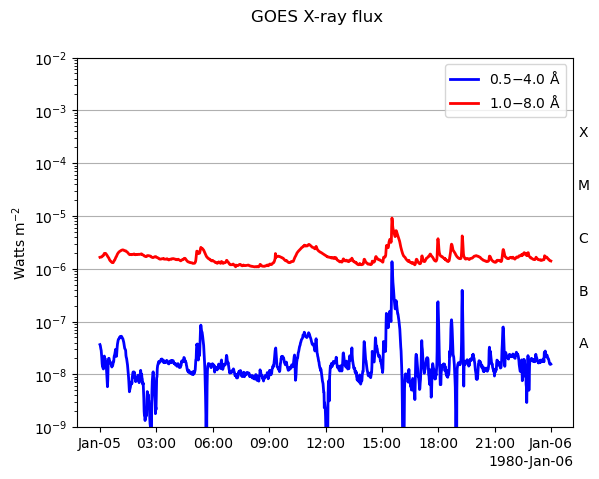

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.27file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1980-01-05 00:00:00
End Date:			1980-01-05 23:59:00
Center Date:			1980-01-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.35E+01<br>emission_measure   1.23E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1980-01-05 00:00:00     2.682203      0.000000e+00
1980-01-05 00:01:00     2.682203      0.000000e+00
1980-01-05 00:02:00     2.682203      0.000000e+00
1980-01-05 00:03:00     2.682203      0.000000e+00
1980-01-05 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1980-01-05 23:55:00     2.682203     -2.177679e+48
1980-01-05 23:56:00     2.682203     -2.755114e+48
1980-01-05 23:57:00     2.682203     -2.796544e+48
1980-01-05 23:58:00     2.682203     -2.066337e+48
1980-01-05

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.13file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1980-01-05 00:00:00
End Date:			1980-01-05 23:59:00
Center Date:			1980-01-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.34E+01<br>emission_measure   3.82E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1980-01-05 00:00:00     2.548023      0.000000e+00
1980-01-05 00:01:00     2.548023      0.000000e+00
1980-01-05 00:02:00     2.548023      0.000000e+00
1980-01-05 00:03:00     2.548023      0.000000e+00
1980-01-05 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1980-01-05 23:55:00     2.548023     -6.773700e+48
1980-01-05 23:56:00     2.548023     -8.569818e+48
1980-01-05 23:57:00     2.548023     -8.698687e+48
1980-01-05 23:58:00     2.548023     -6.427368e+48
1980-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1980-06-21 00:00:00 en un TimeSeries:


2025-09-04 13:58:15 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:58:15 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1980-06-21 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1980-06-21 00:00:00
End Date:			1980-06-21 23:59:00
Center Date:			1980-06-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   7.24E-05<br>xrsb   2.62E-04
Units:			dimensionless
                             xrsa      xrsb
1980-06-21 00:00:00  3.923158e-08  0.000002
1980-06-21 00:01:00  4.576000e-08  0.000002
1980-06-21 00:02:00  5.208947e-08  0.000003
1980-06-21 00:03:00  5.886000e-08  0.000003
1980-06-21 00:04:00  6.456500e-08  0.000003
...                           ...       ...
1980-06-21 23:55:00  2.054210e-08  0.000002
1980-06-21 23:56:00  1.908000e-08  0.000002
1980-06-21 23:57:00  1.8

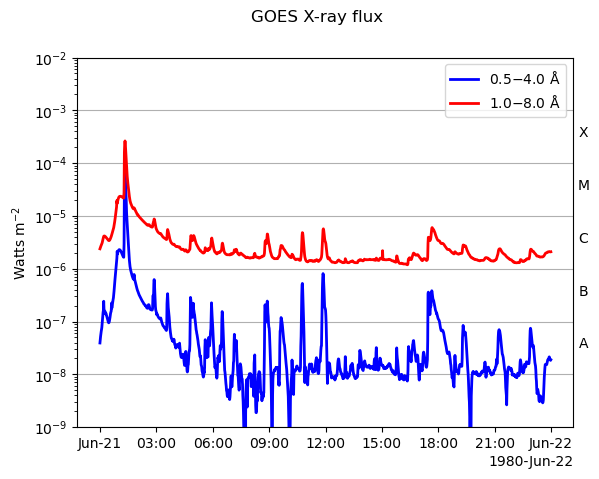

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1980-06-21 00:00:00
End Date:			1980-06-21 23:59:00
Center Date:			1980-06-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        3.24E+01<br>emission_measure   4.85E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1980-06-21 00:00:00     2.682203      0.000000e+00
1980-06-21 00:01:00     2.682203      0.000000e+00
1980-06-21 00:02:00     2.682203      0.000000e+00
1980-06-21 00:03:00     2.682203      0.000000e+00
1980-06-21 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1980-06-21 23:55:00     2.682203      3.308637e+47
1980-06-21 23:56:00     2.682203      2.049915e+47
1980-06-21 23:57:00     2.682203     -1.639932e+47
1980-06-21 23:58:00     2.682203     -4.315603e+47
1980-06-21

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1980-06-21 00:00:00
End Date:			1980-06-21 23:59:00
Center Date:			1980-06-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.30E+01<br>emission_measure   1.50E+52
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1980-06-21 00:00:00     2.548023      0.000000e+00
1980-06-21 00:01:00     2.548023      0.000000e+00
1980-06-21 00:02:00     2.548023      0.000000e+00
1980-06-21 00:03:00     2.548023      0.000000e+00
1980-06-21 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1980-06-21 23:55:00     2.548023      1.029156e+48
1980-06-21 23:56:00     2.548023      6.376287e+47
1980-06-21 23:57:00     2.548023     -5.101029e+47
1980-06-21 23:58:00     2.548023     -1.342374e+48
1980-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.36file/s]


Cargando datos de 1980-12-06 00:00:00 en un TimeSeries:


2025-09-04 13:58:26 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:58:26 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1980-12-06 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1980-12-06 00:00:00
End Date:			1980-12-06 23:59:00
Center Date:			1980-12-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   2.03E-06<br>xrsb   1.28E-05
Units:			dimensionless
                             xrsa      xrsb
1980-12-06 00:00:00  1.353700e-08  0.000001
1980-12-06 00:01:00  1.402100e-08  0.000001
1980-12-06 00:02:00  1.456526e-08  0.000001
1980-12-06 00:03:00  1.333600e-08  0.000001
1980-12-06 00:04:00  1.414316e-08  0.000001
...                           ...       ...
1980-12-06 23:55:00  1.659737e-08  0.000001
1980-12-06 23:56:00  1.474400e-08  0.000001
1980-12-06 23:57:00  1.3

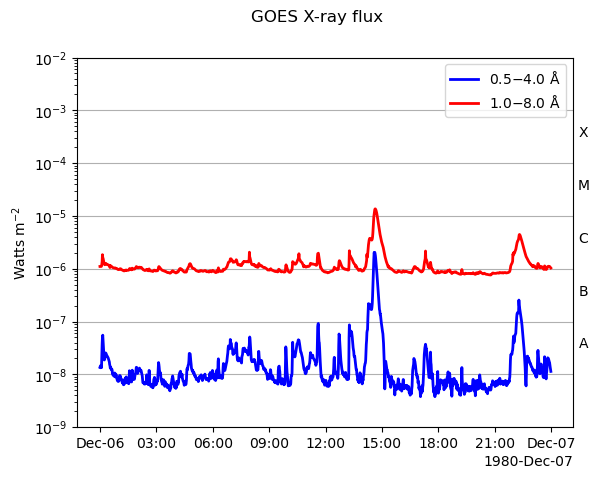

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1980-12-06 00:00:00
End Date:			1980-12-06 23:59:00
Center Date:			1980-12-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.57E+01<br>emission_measure   1.80E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1980-12-06 00:00:00     2.682203      0.000000e+00
1980-12-06 00:01:00     2.682203      0.000000e+00
1980-12-06 00:02:00     2.682203      0.000000e+00
1980-12-06 00:03:00     2.682203      0.000000e+00
1980-12-06 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1980-12-06 23:55:00     2.682203     -6.617399e+46
1980-12-06 23:56:00     2.682203     -7.830755e+47
1980-12-06 23:57:00     2.682203     -1.287503e+48
1980-12-06 23:58:00     2.682203     -1.389859e+48
1980-12-06

Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = 

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1980-12-06 00:00:00
End Date:			1980-12-06 23:59:00
Center Date:			1980-12-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.63E+01<br>emission_measure   5.58E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1980-12-06 00:00:00     2.548023      0.000000e+00
1980-12-06 00:01:00     2.548023      0.000000e+00
1980-12-06 00:02:00     2.548023      0.000000e+00
1980-12-06 00:03:00     2.548023      0.000000e+00
1980-12-06 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1980-12-06 23:55:00     2.548023     -2.058351e+47
1980-12-06 23:56:00     2.548023     -2.435767e+48
1980-12-06 23:57:00     2.548023     -4.004795e+48
1980-12-06 23:58:00     2.548023     -4.323174e+48
1980-

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.04s/file]


Cargando datos de 1981-05-23 00:00:00 en un TimeSeries:


2025-09-04 13:58:37 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:58:37 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1981-05-23 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1981-05-23 00:00:00
End Date:			1981-05-23 23:59:00
Center Date:			1981-05-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   6.71E-07<br>xrsb   5.64E-06
Units:			dimensionless
                             xrsa          xrsb
1981-05-23 00:00:00  7.159000e-09  7.696210e-07
1981-05-23 00:01:00  6.781450e-09  7.669150e-07
1981-05-23 00:02:00  9.656651e-09  7.676500e-07
1981-05-23 00:03:00  5.783326e-09  7.692421e-07
1981-05-23 00:04:00  9.636600e-09  7.599550e-07
...                           ...           ...
1981-05-23 23:55:00  1.412211e-08  1.221158e-06
1981-05-23 23:56:00  1.377850e-08  1

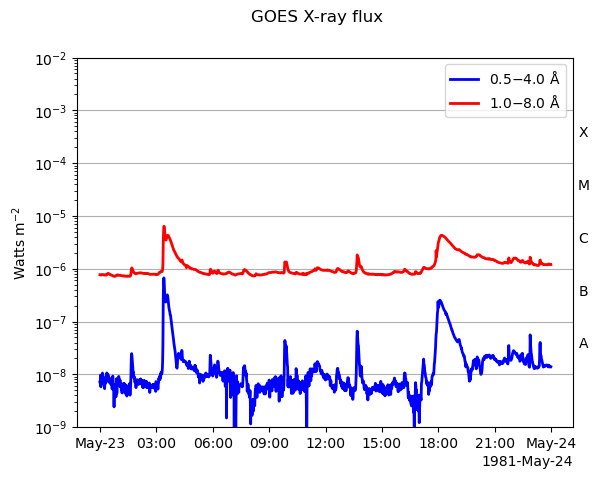

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1981-05-23 00:00:00
End Date:			1981-05-23 23:59:00
Center Date:			1981-05-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.46E+01<br>emission_measure   3.14E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1981-05-23 00:00:00     2.682203      0.000000e+00
1981-05-23 00:01:00     2.682203      0.000000e+00
1981-05-23 00:02:00     2.682203      0.000000e+00
1981-05-23 00:03:00     2.682203      0.000000e+00
1981-05-23 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1981-05-23 23:55:00     2.682203      3.725829e+47
1981-05-23 23:56:00     2.682203     -6.573492e+47
1981-05-23 23:57:00     2.682203     -9.607348e+47
1981-05-23 23:58:00     2.682203     -8.516204e+47
1981-05-23

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1981-05-23 00:00:00
End Date:			1981-05-23 23:59:00
Center Date:			1981-05-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.45E+01<br>emission_measure   7.90E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1981-05-23 00:00:00     2.548023      0.000000e+00
1981-05-23 00:01:00     2.548023      0.000000e+00
1981-05-23 00:02:00     2.548023      0.000000e+00
1981-05-23 00:03:00     2.548023      0.000000e+00
1981-05-23 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1981-05-23 23:55:00     2.548023      1.158924e+48
1981-05-23 23:56:00     2.548023     -2.044693e+48
1981-05-23 23:57:00     2.548023     -2.988378e+48
1981-05-23 23:58:00     2.548023     -2.648976e+48
1981-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.36file/s]


Cargando datos de 1982-04-24 00:00:00 en un TimeSeries:


2025-09-04 13:58:53 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:58:53 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1982-04-24 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1982-04-24 00:00:00
End Date:			1982-04-24 23:59:00
Center Date:			1982-04-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   4.75E-05<br>xrsb   4.73E-04
Units:			dimensionless
                             xrsa          xrsb
1982-04-24 00:00:00  5.302052e-08  1.520421e-06
1982-04-24 00:01:00  5.487200e-08  1.778120e-06
1982-04-24 00:02:00  5.499400e-08  1.525800e-06
1982-04-24 00:03:00  5.115736e-08  1.535842e-06
1982-04-24 00:04:00  4.908100e-08  1.545600e-06
...                           ...           ...
1982-04-24 23:55:00  4.670200e-09  6.787100e-07
1982-04-24 23:56:00  5.381315e-09  6

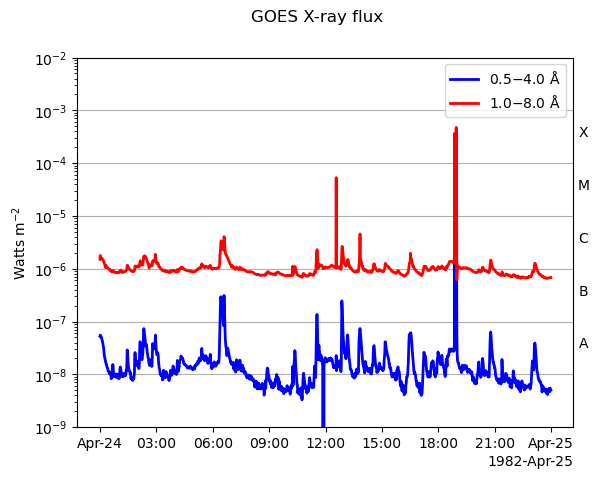

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1982-04-24 00:00:00
End Date:			1982-04-24 23:59:00
Center Date:			1982-04-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.19E+01<br>emission_measure   1.07E+53
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1982-04-24 00:00:00     2.682203      0.000000e+00
1982-04-24 00:01:00     2.682203      0.000000e+00
1982-04-24 00:02:00     2.682203      0.000000e+00
1982-04-24 00:03:00     2.682203      0.000000e+00
1982-04-24 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1982-04-24 23:55:00     2.682203      4.315805e+47
1982-04-24 23:56:00     2.682203      4.322843e+47
1982-04-24 23:57:00     2.682203      5.611366e+47
1982-04-24 23:58:00     2.682203      3.220917e+47
1982-04-24

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1982-04-24 00:00:00
End Date:			1982-04-24 23:59:00
Center Date:			1982-04-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.97E+01<br>emission_measure   2.72E+53
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1982-04-24 00:00:00     2.548023      0.000000e+00
1982-04-24 00:01:00     2.548023      0.000000e+00
1982-04-24 00:02:00     2.548023      0.000000e+00
1982-04-24 00:03:00     2.548023      0.000000e+00
1982-04-24 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1982-04-24 23:55:00     2.548023      1.342437e+48
1982-04-24 23:56:00     2.548023      1.344626e+48
1982-04-24 23:57:00     2.548023      1.745423e+48
1982-04-24 23:58:00     2.548023      1.001871e+48
1982-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1982-10-09 00:00:00 en un TimeSeries:


2025-09-04 13:59:05 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:59:05 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1982-10-09 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1982-10-09 00:00:00
End Date:			1982-10-09 23:59:00
Center Date:			1982-10-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   4.88E-05<br>xrsb   1.35E-03
Units:			dimensionless
                             xrsa          xrsb
1982-10-09 00:00:00  4.936947e-09  5.311948e-07
1982-10-09 00:01:00  5.072300e-09  5.246400e-07
1982-10-09 00:02:00  4.469200e-09  5.249950e-07
1982-10-09 00:03:00  4.809895e-09  5.171053e-07
1982-10-09 00:04:00  5.333700e-09  5.215250e-07
...                           ...           ...
1982-10-09 23:55:00  5.613895e-09  5.705947e-07
1982-10-09 23:56:00  6.178200e-09  5

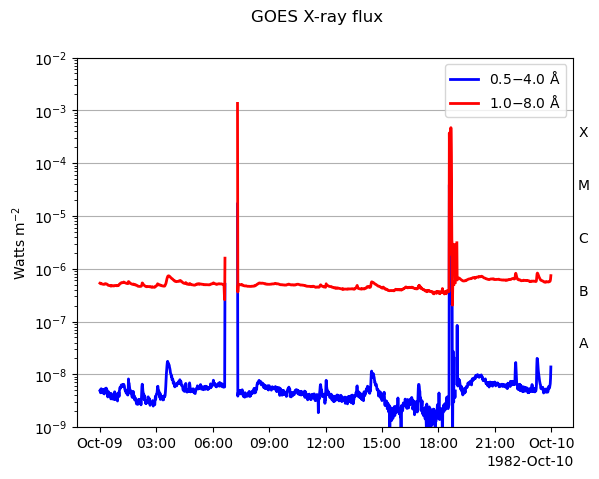

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1982-10-09 00:00:00
End Date:			1982-10-09 23:59:00
Center Date:			1982-10-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.25E+01<br>emission_measure   3.77E+52
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1982-10-09 00:00:00     2.682203      0.000000e+00
1982-10-09 00:01:00     2.682203      0.000000e+00
1982-10-09 00:02:00     2.682203      0.000000e+00
1982-10-09 00:03:00     2.682203      0.000000e+00
1982-10-09 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1982-10-09 23:55:00     2.682203      2.843872e+47
1982-10-09 23:56:00     2.682203      4.398088e+47
1982-10-09 23:57:00     2.682203      7.970150e+47
1982-10-09 23:58:00     7.363728      5.551544e+46
1982-10-09

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1982-10-09 00:00:00
End Date:			1982-10-09 23:59:00
Center Date:			1982-10-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.58E+01<br>emission_measure   1.17E+53
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1982-10-09 00:00:00     2.548023      0.000000e+00
1982-10-09 00:01:00     2.548023      0.000000e+00
1982-10-09 00:02:00     2.548023      0.000000e+00
1982-10-09 00:03:00     2.548023      0.000000e+00
1982-10-09 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1982-10-09 23:55:00     2.548023      8.845902e+47
1982-10-09 23:56:00     2.548023      1.368031e+48
1982-10-09 23:57:00     2.548023      2.479126e+48
1982-10-09 23:58:00     6.407652      1.916382e+47
1982-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1983-03-26 00:00:00 en un TimeSeries:


2025-09-04 13:59:15 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:59:15 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1983-03-26 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-2
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1983-03-26 00:00:00
End Date:			1983-03-26 23:59:00
Center Date:			1983-03-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.45E-05<br>xrsb   3.17E-04
Units:			dimensionless
                             xrsa          xrsb
1983-03-26 00:00:00  4.153895e-09  4.437421e-07
1983-03-26 00:01:00  4.288300e-09  4.422850e-07
1983-03-26 00:02:00  4.280895e-09  4.454737e-07
1983-03-26 00:03:00  3.966650e-09  4.378850e-07
1983-03-26 00:04:00  3.986800e-09  4.369700e-07
...                           ...           ...
1983-03-26 23:55:00  8.598210e-09  5.545526e-07
1983-03-26 23:56:00  8.651000e-09  5

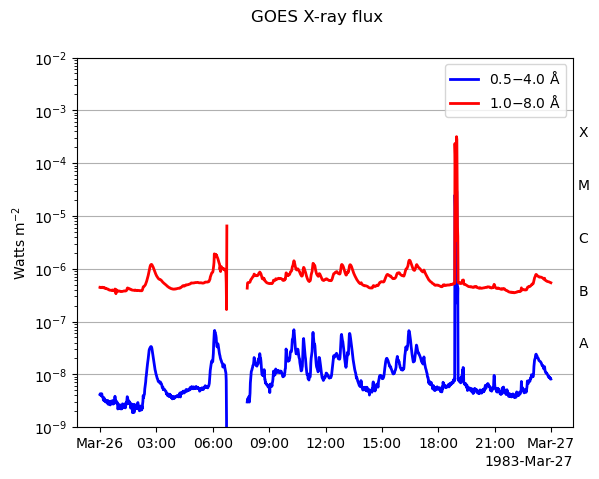

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1983-03-26 00:00:00
End Date:			1983-03-26 23:59:00
Center Date:			1983-03-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.24E+01<br>emission_measure   8.80E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1983-03-26 00:00:00     2.682203      0.000000e+00
1983-03-26 00:01:00     2.682203      0.000000e+00
1983-03-26 00:02:00     2.682203      0.000000e+00
1983-03-26 00:03:00     2.682203      0.000000e+00
1983-03-26 00:04:00     2.682203      0.000000e+00
...                          ...               ...
1983-03-26 23:55:00     2.682203     -4.176115e+47
1983-03-26 23:56:00     2.682203     -4.119002e+47
1983-03-26 23:57:00     2.682203     -3.870057e+47
1983-03-26 23:58:00     2.682203     -4.994076e+47
1983-03-26

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.01file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1983-03-26 00:00:00
End Date:			1983-03-26 23:59:00
Center Date:			1983-03-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.18E+01<br>emission_measure   2.74E+52
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1983-03-26 00:00:00     2.548023      0.000000e+00
1983-03-26 00:01:00     2.548023      0.000000e+00
1983-03-26 00:02:00     2.548023      0.000000e+00
1983-03-26 00:03:00     2.548023      0.000000e+00
1983-03-26 00:04:00     2.548023      0.000000e+00
...                          ...               ...
1983-03-26 23:55:00     2.548023     -1.298986e+48
1983-03-26 23:56:00     2.548023     -1.281221e+48
1983-03-26 23:57:00     2.548023     -1.203786e+48
1983-03-26 23:58:00     2.548023     -1.553414e+48
1983-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.35file/s]


Cargando datos de 1983-09-10 00:00:00 en un TimeSeries:


2025-09-04 13:59:26 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:59:26 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1983-09-10 00:00:00 tengan resolución de un min
Resolution detected: 25.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-5
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1983-09-10 00:00:00
End Date:			1983-09-10 23:59:00
Center Date:			1983-09-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   2.92E-05<br>xrsb   3.52E-04
Units:			dimensionless
                             xrsa          xrsb
1983-09-10 00:00:00  1.046923e-09  2.346615e-07
1983-09-10 00:01:00  1.000000e-09  2.340600e-07
1983-09-10 00:02:00  1.000000e-09  2.351158e-07
1983-09-10 00:03:00  1.023100e-09  2.332100e-07
1983-09-10 00:04:00  1.032105e-09  2.331474e-07
...                           ...           ...
1983-09-10 23:55:00  1.046350e-09  2.183100e-07
1983-09-10 23:56:00  1.000000e-09  

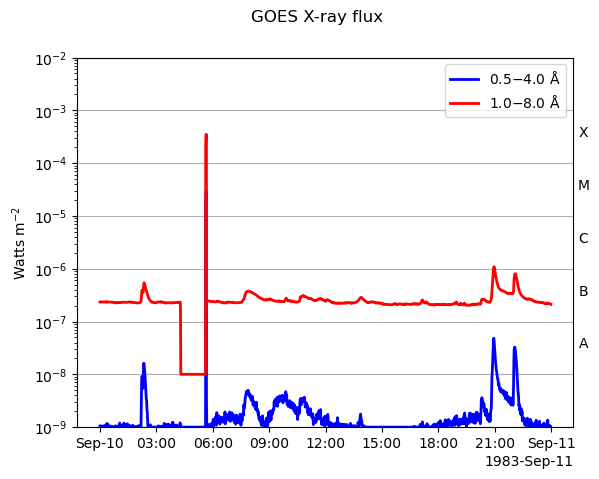

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1983-09-10 00:00:00
End Date:			1983-09-10 23:59:00
Center Date:			1983-09-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        9.01E+00<br>emission_measure   9.73E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1983-09-10 00:00:00     2.788377      0.000000e+00
1983-09-10 00:01:00     2.788377      0.000000e+00
1983-09-10 00:02:00     2.788377      0.000000e+00
1983-09-10 00:03:00     2.788377      0.000000e+00
1983-09-10 00:04:00     2.788377      0.000000e+00
...                          ...               ...
1983-09-10 23:55:00     2.788377     -8.326043e+46
1983-09-10 23:56:00     2.788377      3.742584e+46
1983-09-10 23:57:00     2.788377     -7.864907e+46
1983-09-10 23:58:00     2.788377     -1.033292e+47
1983-09-10

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1983-09-10 00:00:00
End Date:			1983-09-10 23:59:00
Center Date:			1983-09-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.89E+00<br>emission_measure   3.10E+52
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1983-09-10 00:00:00     2.633057      0.000000e+00
1983-09-10 00:01:00     2.633057      0.000000e+00
1983-09-10 00:02:00     2.633057      0.000000e+00
1983-09-10 00:03:00     2.633057      0.000000e+00
1983-09-10 00:04:00     2.633057      0.000000e+00
...                          ...               ...
1983-09-10 23:55:00     2.633057     -2.660347e+47
1983-09-10 23:56:00     2.633057      1.195835e+47
1983-09-10 23:57:00     2.633057     -2.513005e+47
1983-09-10 23:58:00     2.633057     -3.301587e+47
1983-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1984-02-25 00:00:00 en un TimeSeries:


2025-09-04 13:59:37 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:59:37 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1984-02-25 00:00:00 tengan resolución de un min
Resolution detected: 4.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-5
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1984-02-25 00:00:00
End Date:			1984-02-25 23:59:00
Center Date:			1984-02-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.55E-06<br>xrsb   2.46E-05
Units:			dimensionless
                             xrsa          xrsb
1984-02-25 00:00:00  1.416000e-07  2.880263e-06
1984-02-25 00:01:00  1.361550e-07  2.853000e-06
1984-02-25 00:02:00  1.292158e-07  2.809053e-06
1984-02-25 00:03:00  1.235900e-07  2.754800e-06
1984-02-25 00:04:00  1.170500e-07  2.690800e-06
...                           ...           ...
1984-02-25 23:55:00  9.659053e-09  9.874896e-07
1984-02-25 23:56:00  1.003275e-08  9

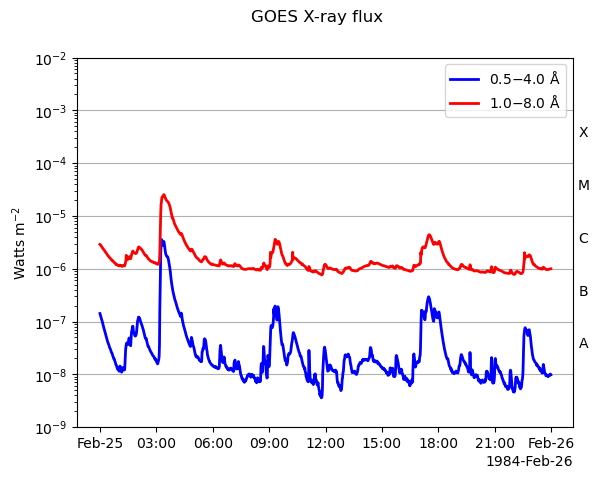

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1984-02-25 00:00:00
End Date:			1984-02-25 23:59:00
Center Date:			1984-02-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.43E+01<br>emission_measure   2.80E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1984-02-25 00:00:00     2.788377      0.000000e+00
1984-02-25 00:01:00     2.788377      0.000000e+00
1984-02-25 00:02:00     2.788377      0.000000e+00
1984-02-25 00:03:00     2.788377      0.000000e+00
1984-02-25 00:04:00     2.788377      0.000000e+00
...                          ...               ...
1984-02-25 23:55:00     2.788377      7.186773e+47
1984-02-25 23:56:00     2.788377      8.094076e+47
1984-02-25 23:57:00     2.788377      6.907154e+47
1984-02-25 23:58:00     2.788377      5.289813e+47
1984-02-25

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.16file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1984-02-25 00:00:00
End Date:			1984-02-25 23:59:00
Center Date:			1984-02-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.03E+02<br>emission_measure   8.93E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1984-02-25 00:00:00     2.633057      0.000000e+00
1984-02-25 00:01:00     2.633057      0.000000e+00
1984-02-25 00:02:00     2.633057      0.000000e+00
1984-02-25 00:03:00     2.633057      0.000000e+00
1984-02-25 00:04:00     2.633057      0.000000e+00
...                          ...               ...
1984-02-25 23:55:00     2.633057      2.296326e+48
1984-02-25 23:56:00     2.633057      2.586229e+48
1984-02-25 23:57:00     2.633057      2.206982e+48
1984-02-25 23:58:00     2.633057      1.690207e+48
1984-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.36file/s]


Cargando datos de 1984-08-11 00:00:00 en un TimeSeries:


2025-09-04 13:59:48 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:59:48 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1984-08-11 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1984-08-11 00:00:00
End Date:			1984-08-11 23:59:00
Center Date:			1984-08-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   5.10E-09<br>xrsb   1.24E-07
Units:			dimensionless
                             xrsa          xrsb
1984-08-11 00:00:00  1.000000e-09  1.335750e-07
1984-08-11 00:01:00  1.000000e-09  1.355900e-07
1984-08-11 00:02:00  1.445316e-09  1.332895e-07
1984-08-11 00:03:00  1.048700e-09  1.335750e-07
1984-08-11 00:04:00  1.030900e-09  1.328000e-07
...                           ...           ...
1984-08-11 23:55:00  1.000000e-09  1.068579e-07
1984-08-11 23:56:00  1.000000e-09  1

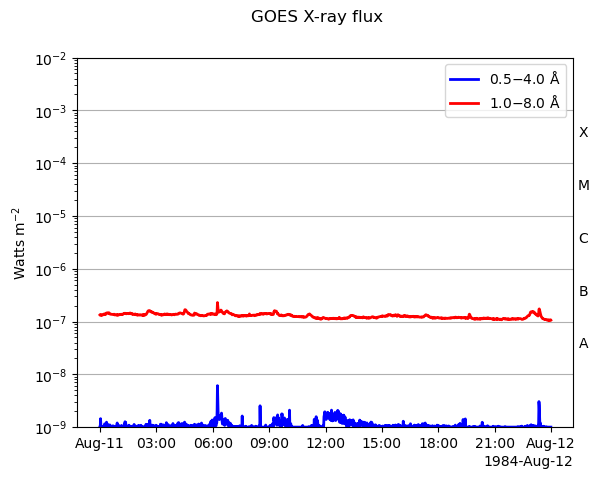

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.14file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1984-08-11 00:00:00
End Date:			1984-08-11 23:59:00
Center Date:			1984-08-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.74E+00<br>emission_measure   2.14E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1984-08-11 00:00:00     2.978802      0.000000e+00
1984-08-11 00:01:00     2.978802      0.000000e+00
1984-08-11 00:02:00     2.978802      0.000000e+00
1984-08-11 00:03:00     2.978802      0.000000e+00
1984-08-11 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1984-08-11 23:55:00     2.978802      1.156087e+46
1984-08-11 23:56:00     2.978802     -2.189521e+46
1984-08-11 23:57:00     2.978802      6.584764e+45
1984-08-11 23:58:00     2.978802      3.077373e+45
1984-08-11

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1984-08-11 00:00:00
End Date:			1984-08-11 23:59:00
Center Date:			1984-08-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.88E+00<br>emission_measure   7.37E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1984-08-11 00:00:00     2.763595      0.000000e+00
1984-08-11 00:01:00     2.763595      0.000000e+00
1984-08-11 00:02:00     2.763595      0.000000e+00
1984-08-11 00:03:00     2.763595      0.000000e+00
1984-08-11 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1984-08-11 23:55:00     2.763595      3.987473e+46
1984-08-11 23:56:00     2.763595     -7.551902e+46
1984-08-11 23:57:00     2.763595      2.271159e+46
1984-08-11 23:58:00     2.763595      1.061421e+46
1984-

/tmp/ipykernel_713106/4282585637.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_anticipation_time = pd.concat([all_anticipation_time, results["anticipation_time"]])


Data found according to the date(1985-01-26 00:00:00): Results from 1 Provider:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument  Physobs   Source Provider
----------------------- ----------------------- ---------- ---------- ------ --------
1985-01-26 00:00:00.000 1985-01-26 23:59:59.999       GOES irradiance   GOES     SDAC




Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]
2025-09-04 13:59:58 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 13:59:58 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Cargando datos de 1985-01-26 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 1985-01-26 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1985-01-26 00:00:00
End Date:			1985-01-26 23:59:00
Center Date:			1985-01-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   9.85E-09<br>xrsb   2.21E-07
Units:			dimensionless
                             xrsa          xrsb
1985-01-26 00:00:00  2.597500e-09  2.016000e-07
1985-01-26 00:01:00  2.407778e-09  1.916667e-07
1985-01-26 00:02:00  1.920555e-09  1.686667e-07
1985-01-26 00:03:00  1.268500e-09  1.530500e-07
1985-01-26 00:04:00  1.245263e-09  1.407368e-07
...                           ...           ...
1985-01-26 23:55:00  1.04950

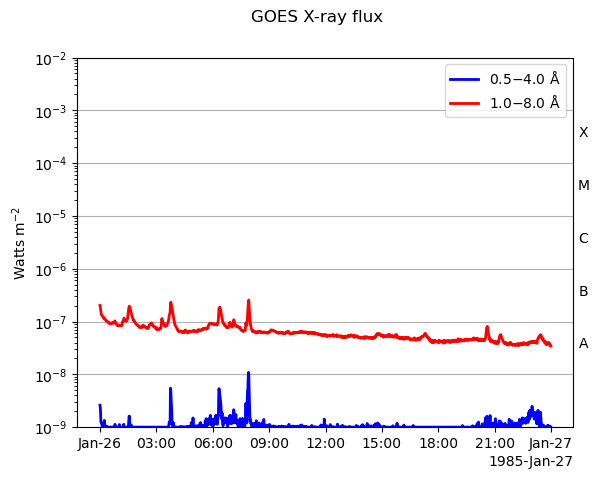

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1985-01-26 00:00:00
End Date:			1985-01-26 23:59:00
Center Date:			1985-01-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.37E+00<br>emission_measure   4.79E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1985-01-26 00:00:00     2.978802      0.000000e+00
1985-01-26 00:01:00     2.978802      0.000000e+00
1985-01-26 00:02:00     2.978802      0.000000e+00
1985-01-26 00:03:00     2.978802      0.000000e+00
1985-01-26 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1985-01-26 23:55:00     2.978802     -2.033128e+46
1985-01-26 23:56:00     2.978802     -6.558962e+46
1985-01-26 23:57:00     2.978802     -1.126041e+47
1985-01-26 23:58:00     2.978802     -1.126040e+47
1985-01-26

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1985-01-26 00:00:00
End Date:			1985-01-26 23:59:00
Center Date:			1985-01-26 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.44E+00<br>emission_measure   1.63E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1985-01-26 00:00:00     2.763595      0.000000e+00
1985-01-26 00:01:00     2.763595      0.000000e+00
1985-01-26 00:02:00     2.763595      0.000000e+00
1985-01-26 00:03:00     2.763595      0.000000e+00
1985-01-26 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1985-01-26 23:55:00     2.763595     -7.012487e+46
1985-01-26 23:56:00     2.763595     -2.262259e+47
1985-01-26 23:57:00     2.763595     -3.883841e+47
1985-01-26 23:58:00     2.763595     -3.883839e+47
1985-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.34file/s]


Cargando datos de 1985-07-13 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 1985-07-13 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min


2025-09-04 14:00:08 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:00:08 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1985-07-13 02:12:00
End Date:			1985-07-13 23:59:00
Center Date:			1985-07-13 13:05:30
Resolution:			59.954 s
Samples per Channel:		1308
Data Range(s):		xrsa   2.19E-07<br>xrsb   2.07E-06
Units:			dimensionless
                             xrsa          xrsb
1985-07-13 02:12:00  5.307693e-09  2.396154e-07
1985-07-13 02:13:00  5.006842e-09  2.398421e-07
1985-07-13 02:14:00  4.265000e-09  2.395000e-07
1985-07-13 02:15:00  5.096842e-09  2.417368e-07
1985-07-13 02:16:00  5.627000e-09  2.432000e-07
...                           ...           ...
1985-07-13 23:55:00  1.139474e-09  2.113158e-07
1985-07-13 23:56:00  2.215000e-09  2.184000e-07
1985-07-13 23:57:00  3.328421e-09  2.326842e-07
1985-07-13 23:58:00  4.668824e-09  2.495883e-07
1985-07-13 23:59:00  5

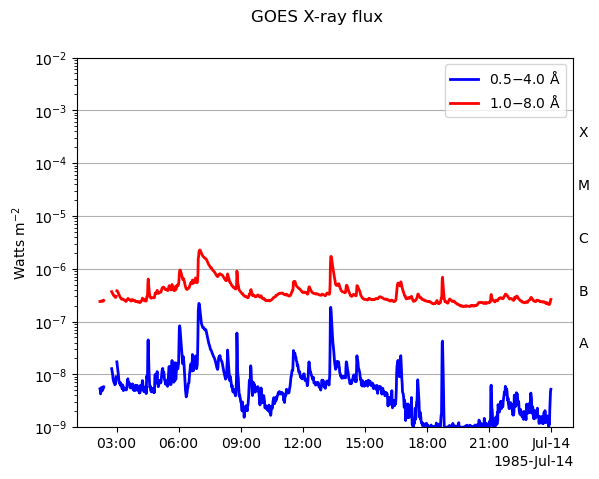

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1985-07-13 02:12:00
End Date:			1985-07-13 23:59:00
Center Date:			1985-07-13 13:05:30
Resolution:			59.954 s
Samples per Channel:		1308
Data Range(s):		temperature        1.26E+01<br>emission_measure   2.75E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1985-07-13 02:12:00     2.978802      0.000000e+00
1985-07-13 02:13:00     2.978802      0.000000e+00
1985-07-13 02:14:00     2.978802      0.000000e+00
1985-07-13 02:15:00     2.978802      0.000000e+00
1985-07-13 02:16:00     2.978802      0.000000e+00
...                          ...               ...
1985-07-13 23:55:00     2.978802     -2.357871e+47
1985-07-13 23:56:00     2.978802     -2.724268e+46
1985-07-13 23:57:00     2.978802      4.287574e+47
1985-07-13 23:58:00    11.090889      2.301728e+46
1985-07-13

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1985-07-13 02:12:00
End Date:			1985-07-13 23:59:00
Center Date:			1985-07-13 13:05:30
Resolution:			59.954 s
Samples per Channel:		1308
Data Range(s):		temperature        1.25E+01<br>emission_measure   9.48E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1985-07-13 02:12:00     2.763595      0.000000e+00
1985-07-13 02:13:00     2.763595      0.000000e+00
1985-07-13 02:14:00     2.763595      0.000000e+00
1985-07-13 02:15:00     2.763595      0.000000e+00
1985-07-13 02:16:00     2.763595      0.000000e+00
...                          ...               ...
1985-07-13 23:55:00     2.763595     -8.132562e+47
1985-07-13 23:56:00     2.763595     -9.396307e+46
1985-07-13 23:57:00     2.763595      1.478832e+48
1985-07-13 23:58:00     9.969934      6.232552e+46
1985-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1985-12-28 00:00:00 en un TimeSeries:


2025-09-04 14:00:19 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:00:19 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1985-12-28 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1985-12-28 00:00:00
End Date:			1985-12-28 23:59:00
Center Date:			1985-12-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   2.56E-09<br>xrsb   2.00E-09
Units:			dimensionless
                             xrsa          xrsb
1985-12-28 00:00:00  1.000000e-09  1.000000e-08
1985-12-28 00:01:00  1.000000e-09  1.000000e-08
1985-12-28 00:02:00  1.000000e-09  1.000000e-08
1985-12-28 00:03:00  1.000000e-09  1.000000e-08
1985-12-28 00:04:00  1.000000e-09  1.000000e-08
...                           ...           ...
1985-12-28 23:55:00  1.700500e-09  1.000000e-08
1985-12-28 23:56:00  1.515789e-09  1

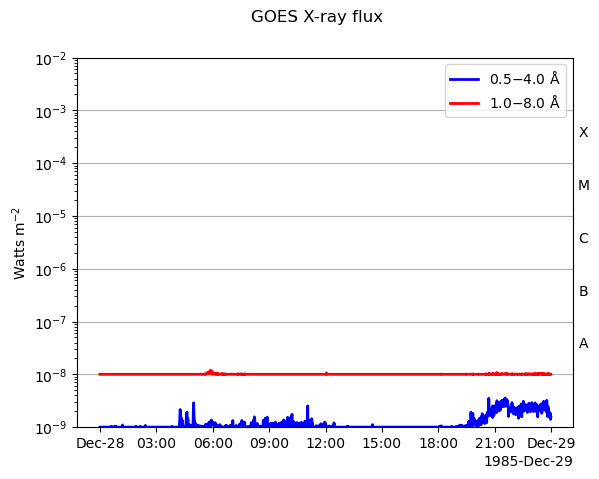

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1985-12-28 00:00:00
End Date:			1985-12-28 23:59:00
Center Date:			1985-12-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   4.41E+46
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1985-12-28 00:00:00     2.978802      0.000000e+00
1985-12-28 00:01:00     2.978802      0.000000e+00
1985-12-28 00:02:00     2.978802      0.000000e+00
1985-12-28 00:03:00     2.978802      0.000000e+00
1985-12-28 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1985-12-28 23:55:00     2.978802     -1.816194e+45
1985-12-28 23:56:00     2.978802     -5.735357e+45
1985-12-28 23:57:00     2.978802      1.816194e+45
1985-12-28 23:58:00     2.978802     -3.632389e+45
1985-12-28

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.19file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1985-12-28 00:00:00
End Date:			1985-12-28 23:59:00
Center Date:			1985-12-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.52E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1985-12-28 00:00:00     2.763595      0.000000e+00
1985-12-28 00:01:00     2.763595      0.000000e+00
1985-12-28 00:02:00     2.763595      0.000000e+00
1985-12-28 00:03:00     2.763595      0.000000e+00
1985-12-28 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1985-12-28 23:55:00     2.763595     -6.264258e+45
1985-12-28 23:56:00     2.763595     -1.978189e+46
1985-12-28 23:57:00     2.763595      6.264258e+45
1985-12-28 23:58:00     2.763595     -1.252852e+46
1985-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.33file/s]


Cargando datos de 1986-06-14 00:00:00 en un TimeSeries:


2025-09-04 14:00:29 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:00:29 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1986-06-14 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1986-06-14 00:00:00
End Date:			1986-06-14 23:59:00
Center Date:			1986-06-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   2.15E-09<br>xrsb   3.70E-07
Units:			dimensionless
                             xrsa          xrsb
1986-06-14 00:00:00  1.028500e-09  2.032000e-08
1986-06-14 00:01:00  1.018235e-09  2.155294e-08
1986-06-14 00:02:00  1.027368e-09  2.183158e-08
1986-06-14 00:03:00  1.000000e-09  2.101500e-08
1986-06-14 00:04:00  1.000000e-09  2.305790e-08
...                           ...           ...
1986-06-14 23:55:00  1.000000e-09  1.009000e-08
1986-06-14 23:56:00  1.000000e-09  1

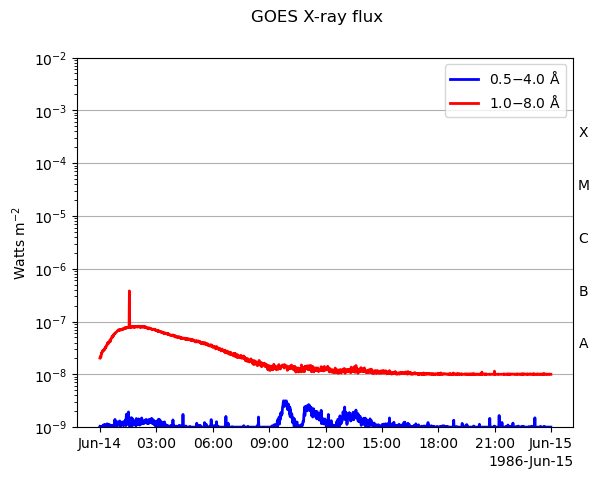

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1986-06-14 00:00:00
End Date:			1986-06-14 23:59:00
Center Date:			1986-06-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.22E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1986-06-14 00:00:00     2.978802               0.0
1986-06-14 00:01:00     2.978802               0.0
1986-06-14 00:02:00     2.978802               0.0
1986-06-14 00:03:00     2.978802               0.0
1986-06-14 00:04:00     2.978802               0.0
...                          ...               ...
1986-06-14 23:55:00     2.978802               0.0
1986-06-14 23:56:00     2.978802               0.0
1986-06-14 23:57:00     2.978802               0.0
1986-06-14 23:58:00     2.978802               0.0
1986-06-14

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1986-06-14 00:00:00
End Date:			1986-06-14 23:59:00
Center Date:			1986-06-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   4.20E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1986-06-14 00:00:00     2.763595               0.0
1986-06-14 00:01:00     2.763595               0.0
1986-06-14 00:02:00     2.763595               0.0
1986-06-14 00:03:00     2.763595               0.0
1986-06-14 00:04:00     2.763595               0.0
...                          ...               ...
1986-06-14 23:55:00     2.763595               0.0
1986-06-14 23:56:00     2.763595               0.0
1986-06-14 23:57:00     2.763595               0.0
1986-06-14 23:58:00     2.763595               0.0
1986-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1986-11-29 00:00:00 en un TimeSeries:


2025-09-04 14:00:38 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:00:38 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1986-11-29 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1986-11-29 00:00:00
End Date:			1986-11-29 23:59:00
Center Date:			1986-11-29 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   2.16E-09<br>xrsb   1.05E-08
Units:			dimensionless
                             xrsa          xrsb
1986-11-29 00:00:00  1.000000e-09  1.324500e-08
1986-11-29 00:01:00  1.000000e-09  1.239474e-08
1986-11-29 00:02:00  1.000000e-09  1.495882e-08
1986-11-29 00:03:00  1.000000e-09  1.402632e-08
1986-11-29 00:04:00  1.000000e-09  1.249500e-08
...                           ...           ...
1986-11-29 23:55:00  1.042000e-09  1.040500e-08
1986-11-29 23:56:00  1.000000e-09  1

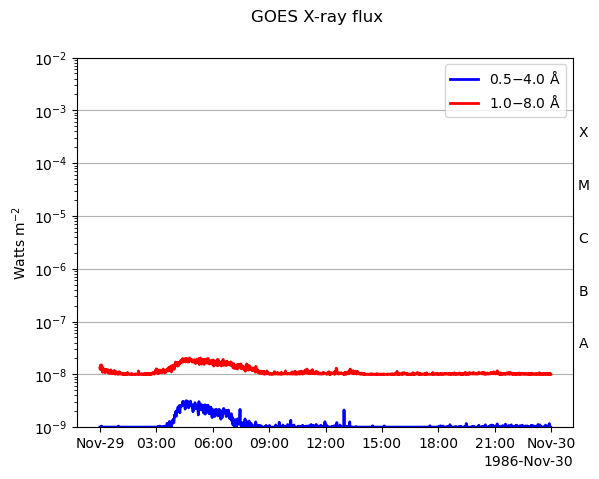

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1986-11-29 00:00:00
End Date:			1986-11-29 23:59:00
Center Date:			1986-11-29 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.77E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1986-11-29 00:00:00     2.978802      0.000000e+00
1986-11-29 00:01:00     2.978802      0.000000e+00
1986-11-29 00:02:00     2.978802      0.000000e+00
1986-11-29 00:03:00     2.978802      0.000000e+00
1986-11-29 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1986-11-29 23:55:00     2.978802      8.172884e+45
1986-11-29 23:56:00     2.978802     -5.341760e+45
1986-11-29 23:57:00     2.978802      0.000000e+00
1986-11-29 23:58:00     2.978802      1.911798e+45
1986-11-29

Files Downloaded: 100%|██████████| 1/1 [00:02<00:00,  2.05s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1986-11-29 00:00:00
End Date:			1986-11-29 23:59:00
Center Date:			1986-11-29 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   6.09E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1986-11-29 00:00:00     2.763595      0.000000e+00
1986-11-29 00:01:00     2.763595      0.000000e+00
1986-11-29 00:02:00     2.763595      0.000000e+00
1986-11-29 00:03:00     2.763595      0.000000e+00
1986-11-29 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1986-11-29 23:55:00     2.763595      2.818919e+46
1986-11-29 23:56:00     2.763595     -1.842433e+46
1986-11-29 23:57:00     2.763595      0.000000e+00
1986-11-29 23:58:00     2.763595      6.594005e+45
1986-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.36file/s]
2025-09-04 14:00:49 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:00:49 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Cargando datos de 1987-05-16 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 1987-05-16 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1987-05-16 00:00:00
End Date:			1987-05-16 23:59:00
Center Date:			1987-05-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.04E-07<br>xrsb   2.68E-06
Units:			dimensionless
                             xrsa          xrsb
1987-05-16 00:00:00  1.535789e-09  3.160000e-07
1987-05-16 00:01:00  1.952000e-09  3.166000e-07
1987-05-16 00:02:00  1.729412e-09  3.172353e-07
1987-05-16 00:03:00  1.814210e-09  3.144210e-07
1987-05-16 00:04:00  2.112000e-09  3.161500e-07
...                           ...           ...
1987-05-16 23:55:00  1.21842

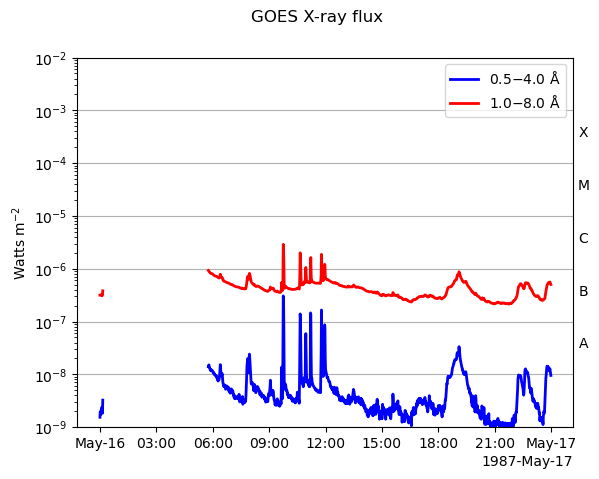

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1987-05-16 00:00:00
End Date:			1987-05-16 23:59:00
Center Date:			1987-05-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.15E+01<br>emission_measure   5.09E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1987-05-16 00:00:00     2.978802      0.000000e+00
1987-05-16 00:01:00     2.978802      0.000000e+00
1987-05-16 00:02:00     2.978802      0.000000e+00
1987-05-16 00:03:00     2.978802      0.000000e+00
1987-05-16 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1987-05-16 23:55:00     2.978802      4.641394e+47
1987-05-16 23:56:00     2.978802      4.124432e+47
1987-05-16 23:57:00     2.978802     -1.243716e+47
1987-05-16 23:58:00     2.978802     -4.272155e+47
1987-05-16

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1987-05-16 00:00:00
End Date:			1987-05-16 23:59:00
Center Date:			1987-05-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.12E+01<br>emission_measure   1.76E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1987-05-16 00:00:00     2.763595      0.000000e+00
1987-05-16 00:01:00     2.763595      0.000000e+00
1987-05-16 00:02:00     2.763595      0.000000e+00
1987-05-16 00:03:00     2.763595      0.000000e+00
1987-05-16 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1987-05-16 23:55:00     2.763595      1.600869e+48
1987-05-16 23:56:00     2.763595      1.422563e+48
1987-05-16 23:57:00     2.763595     -4.289718e+47
1987-05-16 23:58:00     2.763595     -1.473514e+48
1987-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1987-10-31 00:00:00 en un TimeSeries:


2025-09-04 14:01:00 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:01:00 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1987-10-31 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1987-10-31 00:00:00
End Date:			1987-10-31 23:59:00
Center Date:			1987-10-31 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   5.84E-08<br>xrsb   1.92E-06
Units:			dimensionless
                             xrsa          xrsb
1987-10-31 00:00:00  5.560000e-08  1.974500e-06
1987-10-31 00:01:00  5.388125e-08  1.971875e-06
1987-10-31 00:02:00  5.506500e-08  1.970000e-06
1987-10-31 00:03:00  5.293684e-08  1.963684e-06
1987-10-31 00:04:00  5.320000e-08  1.962500e-06
...                           ...           ...
1987-10-31 23:55:00  1.165294e-09  2.373529e-07
1987-10-31 23:56:00  1.074210e-09  2

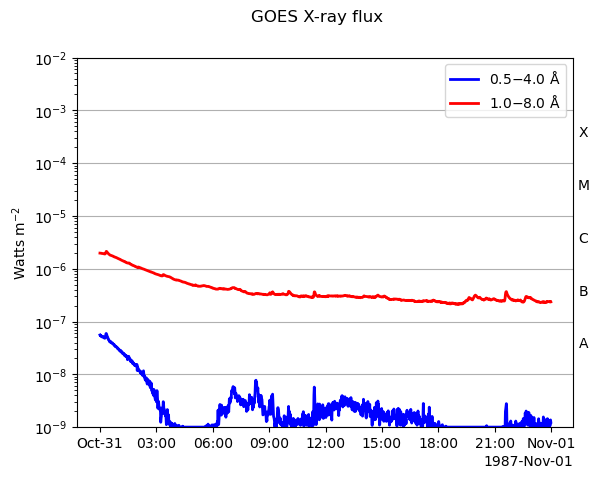

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1987-10-31 00:00:00
End Date:			1987-10-31 23:59:00
Center Date:			1987-10-31 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.78E+00<br>emission_measure   4.27E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1987-10-31 00:00:00     2.978802      0.000000e+00
1987-10-31 00:01:00     2.978802      0.000000e+00
1987-10-31 00:02:00     2.978802      0.000000e+00
1987-10-31 00:03:00     2.978802      0.000000e+00
1987-10-31 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1987-10-31 23:55:00     2.978802     -2.314755e+46
1987-10-31 23:56:00     2.978802      1.593088e+46
1987-10-31 23:57:00     2.978802     -4.540466e+46
1987-10-31 23:58:00     2.978802     -8.284417e+46
1987-10-31

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1987-10-31 00:00:00
End Date:			1987-10-31 23:59:00
Center Date:			1987-10-31 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.86E+00<br>emission_measure   1.47E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1987-10-31 00:00:00     2.763595      0.000000e+00
1987-10-31 00:01:00     2.763595      0.000000e+00
1987-10-31 00:02:00     2.763595      0.000000e+00
1987-10-31 00:03:00     2.763595      0.000000e+00
1987-10-31 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1987-10-31 23:55:00     2.763595     -7.983849e+46
1987-10-31 23:56:00     2.763595      5.494738e+46
1987-10-31 23:57:00     2.763595     -1.566058e+47
1987-10-31 23:58:00     2.763595     -2.857388e+47
1987-

/tmp/ipykernel_713106/4282585637.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_anticipation_time = pd.concat([all_anticipation_time, results["anticipation_time"]])


Data found according to the date(1988-04-16 00:00:00): Results from 1 Provider:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument  Physobs   Source Provider
----------------------- ----------------------- ---------- ---------- ------ --------
1988-04-16 00:00:00.000 1988-04-16 23:59:59.999       GOES irradiance   GOES     SDAC




Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1988-04-16 00:00:00 en un TimeSeries:


2025-09-04 14:01:10 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:01:10 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1988-04-16 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1988-04-16 00:00:00
End Date:			1988-04-16 23:59:00
Center Date:			1988-04-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.49E-06<br>xrsb   1.28E-05
Units:			dimensionless
                             xrsa      xrsb
1988-04-16 00:00:00  1.190000e-08  0.000001
1988-04-16 00:01:00  1.121700e-08  0.000001
1988-04-16 00:02:00  1.177895e-08  0.000001
1988-04-16 00:03:00  1.142700e-08  0.000001
1988-04-16 00:04:00  1.175000e-08  0.000001
...                           ...       ...
1988-04-16 23:55:00  2.455500e-08  0.000001
1988-04-16 23:56:00  3.471500e-08  0.000001
1988-04-16 23:57:00  4.1

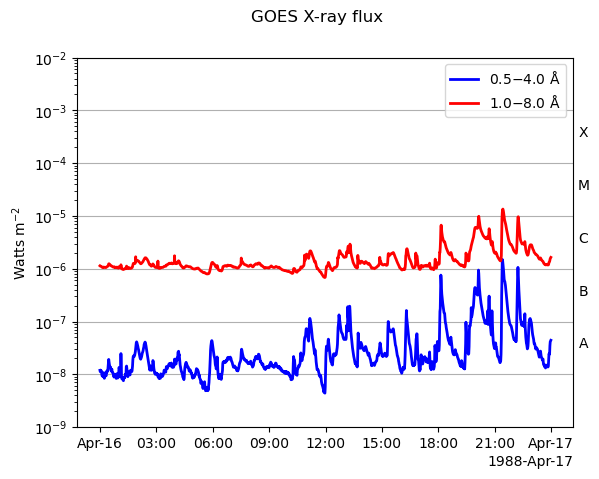

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1988-04-16 00:00:00
End Date:			1988-04-16 23:59:00
Center Date:			1988-04-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.94E+03<br>emission_measure   1.47E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1988-04-16 00:00:00     2.978802      0.000000e+00
1988-04-16 00:01:00     2.978802      0.000000e+00
1988-04-16 00:02:00     2.978802      0.000000e+00
1988-04-16 00:03:00     2.978802      0.000000e+00
1988-04-16 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1988-04-16 23:55:00     8.853467      1.503035e+47
1988-04-16 23:56:00     9.891017      1.907498e+47
1988-04-16 23:57:00     9.702300      2.303149e+47
1988-04-16 23:58:00     9.652703      1.897489e+47
1988-04-16

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1988-04-16 00:00:00
End Date:			1988-04-16 23:59:00
Center Date:			1988-04-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.19E+03<br>emission_measure   5.07E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1988-04-16 00:00:00     2.763595      0.000000e+00
1988-04-16 00:01:00     2.763595      0.000000e+00
1988-04-16 00:02:00     2.763595      0.000000e+00
1988-04-16 00:03:00     2.763595      0.000000e+00
1988-04-16 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1988-04-16 23:55:00     7.769508      4.701917e+47
1988-04-16 23:56:00     8.755223      5.585956e+47
1988-04-16 23:57:00     8.572689      6.825338e+47
1988-04-16 23:58:00     8.525005      5.640769e+47
1988-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.39file/s]


Cargando datos de 1988-10-01 00:00:00 en un TimeSeries:


2025-09-04 14:01:21 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:01:21 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1988-10-01 00:00:00 tengan resolución de un min
Resolution detected: 4.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1988-10-01 00:00:00
End Date:			1988-10-01 23:59:00
Center Date:			1988-10-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.32E-05<br>xrsb   1.39E-04
Units:			dimensionless
                             xrsa      xrsb
1988-10-01 00:00:00  1.175000e-08  0.000001
1988-10-01 00:01:00  1.186316e-08  0.000001
1988-10-01 00:02:00  1.100000e-08  0.000001
1988-10-01 00:03:00  1.025500e-08  0.000001
1988-10-01 00:04:00  1.063526e-08  0.000001
...                           ...       ...
1988-10-01 23:55:00  2.727647e-08  0.000002
1988-10-01 23:56:00  2.579474e-08  0.000002
1988-10-01 23:57:00  2.4

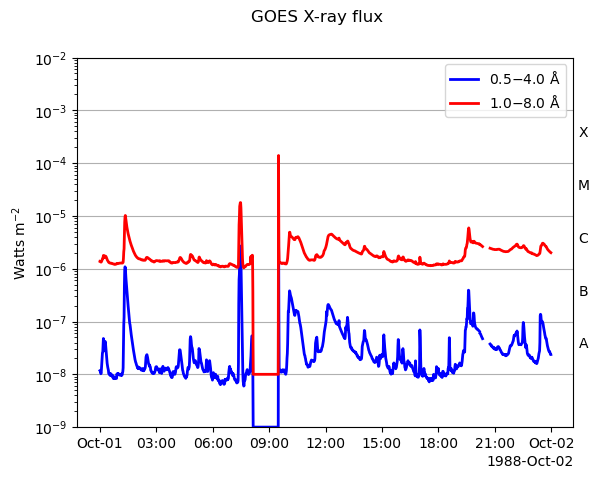

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.01s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1988-10-01 00:00:00
End Date:			1988-10-01 23:59:00
Center Date:			1988-10-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.89E+02<br>emission_measure   2.86E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1988-10-01 00:00:00     2.978802      0.000000e+00
1988-10-01 00:01:00     2.978802      0.000000e+00
1988-10-01 00:02:00     2.978802      0.000000e+00
1988-10-01 00:03:00     2.978802      0.000000e+00
1988-10-01 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1988-10-01 23:55:00     2.978802     -2.962895e+48
1988-10-01 23:56:00     2.978802     -2.942023e+48
1988-10-01 23:57:00     2.978802     -2.774739e+48
1988-10-01 23:58:00     2.978802     -3.004159e+48
1988-10-01

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1988-10-01 00:00:00
End Date:			1988-10-01 23:59:00
Center Date:			1988-10-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.33E+02<br>emission_measure   9.82E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1988-10-01 00:00:00     2.763595      0.000000e+00
1988-10-01 00:01:00     2.763595      0.000000e+00
1988-10-01 00:02:00     2.763595      0.000000e+00
1988-10-01 00:03:00     2.763595      0.000000e+00
1988-10-01 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1988-10-01 23:55:00     2.763595     -1.021936e+49
1988-10-01 23:56:00     2.763595     -1.014737e+49
1988-10-01 23:57:00     2.763595     -9.570387e+48
1988-10-01 23:58:00     2.763595     -1.036168e+49
1988-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1989-03-18 00:00:00 en un TimeSeries:


2025-09-04 14:01:31 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:01:31 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1989-03-18 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1989-03-18 00:00:00
End Date:			1989-03-18 23:59:00
Center Date:			1989-03-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   4.42E-05<br>xrsb   4.87E-04
Units:			dimensionless
                             xrsa      xrsb
1989-03-18 00:00:00  1.677000e-07  0.000006
1989-03-18 00:01:00  1.646000e-07  0.000006
1989-03-18 00:02:00  1.600000e-07  0.000006
1989-03-18 00:03:00  1.559500e-07  0.000006
1989-03-18 00:04:00  1.566250e-07  0.000006
...                           ...       ...
1989-03-18 23:55:00  1.356500e-07  0.000006
1989-03-18 23:56:00  1.361500e-07  0.000006
1989-03-18 23:57:00  1.3

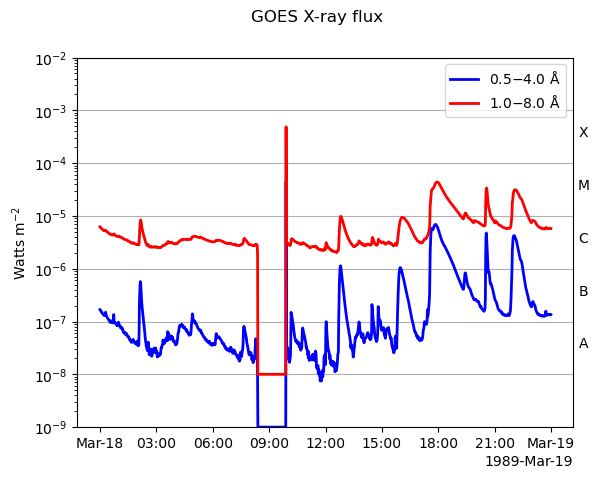

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:02<00:00,  2.32s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1989-03-18 00:00:00
End Date:			1989-03-18 23:59:00
Center Date:			1989-03-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.48E+01<br>emission_measure   1.01E+52
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1989-03-18 00:00:00     2.978802      0.000000e+00
1989-03-18 00:01:00     2.978802      0.000000e+00
1989-03-18 00:02:00     2.978802      0.000000e+00
1989-03-18 00:03:00     2.978802      0.000000e+00
1989-03-18 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1989-03-18 23:55:00     5.765149      1.373676e+47
1989-03-18 23:56:00     8.032143      3.971736e+46
1989-03-18 23:57:00     2.978802      2.137454e+47
1989-03-18 23:58:00     2.978802      5.436779e+47
1989-03-18

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1989-03-18 00:00:00
End Date:			1989-03-18 23:59:00
Center Date:			1989-03-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.94E+01<br>emission_measure   3.45E+52
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1989-03-18 00:00:00     2.763595      0.000000e+00
1989-03-18 00:01:00     2.763595      0.000000e+00
1989-03-18 00:02:00     2.763595      0.000000e+00
1989-03-18 00:03:00     2.763595      0.000000e+00
1989-03-18 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1989-03-18 23:55:00     4.996346      5.256172e+47
1989-03-18 23:56:00     7.012227      1.311361e+47
1989-03-18 23:57:00     2.763595      7.372318e+47
1989-03-18 23:58:00     2.763595      1.875206e+48
1989-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.32file/s]


Cargando datos de 1989-09-02 00:00:00 en un TimeSeries:


2025-09-04 14:01:43 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:01:43 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1989-09-02 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1989-09-02 00:00:00
End Date:			1989-09-02 23:59:00
Center Date:			1989-09-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.01E-05<br>xrsb   1.06E-04
Units:			dimensionless
                             xrsa      xrsb
1989-09-02 00:00:00  7.881176e-06  0.000052
1989-09-02 00:01:00  6.680000e-06  0.000047
1989-09-02 00:02:00  5.697500e-06  0.000042
1989-09-02 00:03:00  4.912500e-06  0.000038
1989-09-02 00:04:00  4.323158e-06  0.000035
...                           ...       ...
1989-09-02 23:55:00  1.666842e-07  0.000006
1989-09-02 23:56:00  1.670000e-07  0.000006
1989-09-02 23:57:00  1.6

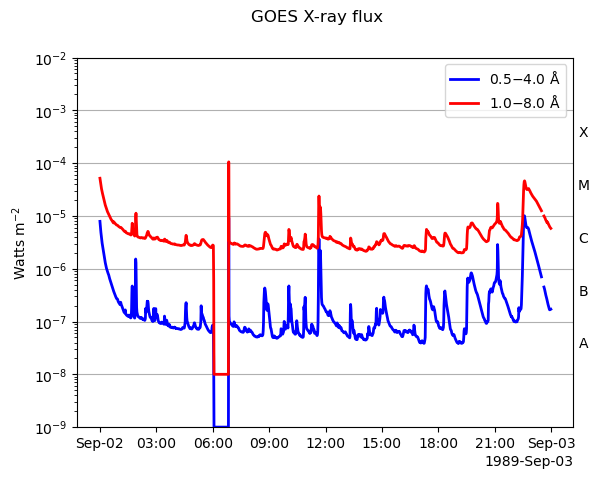

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1989-09-02 00:00:00
End Date:			1989-09-02 23:59:00
Center Date:			1989-09-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.08E+02<br>emission_measure   2.13E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1989-09-02 00:00:00     2.978802      0.000000e+00
1989-09-02 00:01:00     2.978802      0.000000e+00
1989-09-02 00:02:00     2.978802      0.000000e+00
1989-09-02 00:03:00     2.978802      0.000000e+00
1989-09-02 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1989-09-02 23:55:00     2.978802     -1.929839e+49
1989-09-02 23:56:00     2.978802     -1.857444e+49
1989-09-02 23:57:00     2.978802     -1.639619e+49
1989-09-02 23:58:00     2.978802     -1.520930e+49
1989-09-02

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.40s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1989-09-02 00:00:00
End Date:			1989-09-02 23:59:00
Center Date:			1989-09-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.47E+02<br>emission_measure   7.30E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1989-09-02 00:00:00     2.763595      0.000000e+00
1989-09-02 00:01:00     2.763595      0.000000e+00
1989-09-02 00:02:00     2.763595      0.000000e+00
1989-09-02 00:03:00     2.763595      0.000000e+00
1989-09-02 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1989-09-02 23:55:00     2.763595     -6.656229e+49
1989-09-02 23:56:00     2.763595     -6.406532e+49
1989-09-02 23:57:00     2.763595     -5.655228e+49
1989-09-02 23:58:00     2.763595     -5.245857e+49
1989-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1990-02-17 00:00:00 en un TimeSeries:


2025-09-04 14:01:56 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:01:56 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1990-02-17 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1990-02-17 00:00:00
End Date:			1990-02-17 23:59:00
Center Date:			1990-02-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.08E-06<br>xrsb   5.28E-06
Units:			dimensionless
                             xrsa          xrsb
1990-02-17 00:00:00  2.097000e-09  4.638500e-07
1990-02-17 00:01:00  2.146250e-09  4.638125e-07
1990-02-17 00:02:00  2.151500e-09  4.646000e-07
1990-02-17 00:03:00  1.951000e-09  4.624500e-07
1990-02-17 00:04:00  2.247368e-09  4.617369e-07
...                           ...           ...
1990-02-17 23:55:00  4.842353e-08  1.638824e-06
1990-02-17 23:56:00  5.256316e-08  1

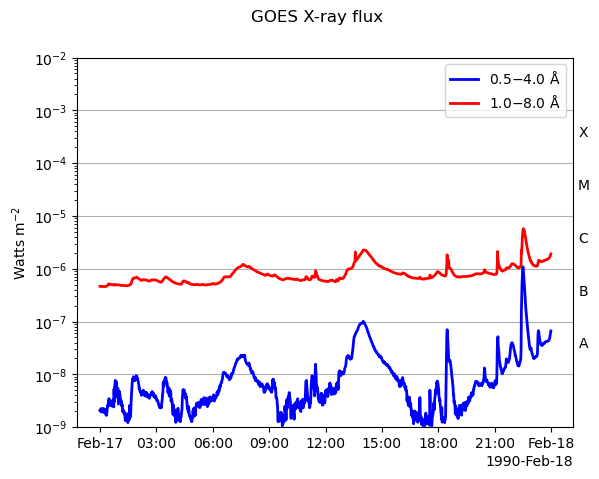

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1990-02-17 00:00:00
End Date:			1990-02-17 23:59:00
Center Date:			1990-02-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.62E+01<br>emission_measure   7.06E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1990-02-17 00:00:00     2.978802      0.000000e+00
1990-02-17 00:01:00     2.978802      0.000000e+00
1990-02-17 00:02:00     2.978802      0.000000e+00
1990-02-17 00:03:00     2.978802      0.000000e+00
1990-02-17 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1990-02-17 23:55:00     8.395155      9.210417e+46
1990-02-17 23:56:00     9.353106      1.083168e+47
1990-02-17 23:57:00     9.594432      1.244947e+47
1990-02-17 23:58:00     9.514067      1.838928e+47
1990-02-17

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1990-02-17 00:00:00
End Date:			1990-02-17 23:59:00
Center Date:			1990-02-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.72E+01<br>emission_measure   2.43E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1990-02-17 00:00:00     2.763595      0.000000e+00
1990-02-17 00:01:00     2.763595      0.000000e+00
1990-02-17 00:02:00     2.763595      0.000000e+00
1990-02-17 00:03:00     2.763595      0.000000e+00
1990-02-17 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1990-02-17 23:55:00     7.345300      2.968261e+47
1990-02-17 23:56:00     8.239129      3.281633e+47
1990-02-17 23:57:00     8.469117      3.714548e+47
1990-02-17 23:58:00     8.392267      5.514756e+47
1990-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1990-08-04 00:00:00 en un TimeSeries:


2025-09-04 14:02:07 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:02:07 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1990-08-04 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1990-08-04 00:00:00
End Date:			1990-08-04 23:59:00
Center Date:			1990-08-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   7.72E-07<br>xrsb   4.30E-06
Units:			dimensionless
                             xrsa          xrsb
1990-08-04 00:00:00  9.730526e-09  8.938948e-07
1990-08-04 00:01:00  1.410000e-08  9.592500e-07
1990-08-04 00:02:00  2.493125e-08  1.090625e-06
1990-08-04 00:03:00  2.459000e-08  1.128000e-06
1990-08-04 00:04:00  2.039000e-08  1.121500e-06
...                           ...           ...
1990-08-04 23:55:00  4.084500e-09  6.292000e-07
1990-08-04 23:56:00  3.921765e-09  6

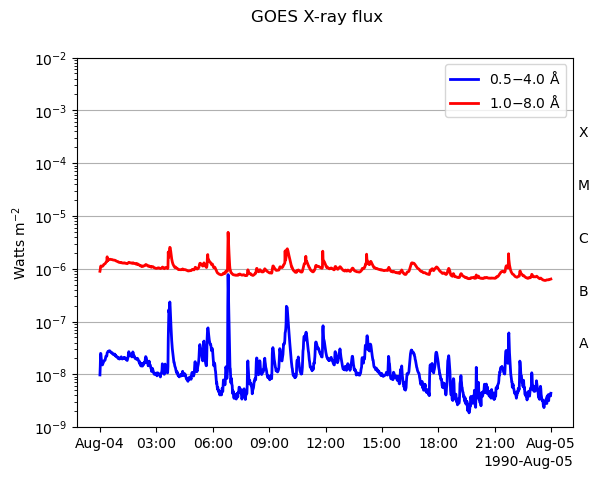

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1990-08-04 00:00:00
End Date:			1990-08-04 23:59:00
Center Date:			1990-08-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.76E+05<br>emission_measure   8.39E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1990-08-04 00:00:00     2.978802      0.000000e+00
1990-08-04 00:01:00     2.978802      0.000000e+00
1990-08-04 00:02:00     2.978802      0.000000e+00
1990-08-04 00:03:00     2.978802      0.000000e+00
1990-08-04 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1990-08-04 23:55:00     2.978802      2.366976e+47
1990-08-04 23:56:00     2.978802      1.931929e+47
1990-08-04 23:57:00     2.978802      2.400357e+47
1990-08-04 23:58:00     2.978802      2.976543e+47
1990-08-04

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1990-08-04 00:00:00
End Date:			1990-08-04 23:59:00
Center Date:			1990-08-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.59E+04<br>emission_measure   2.89E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1990-08-04 00:00:00     2.763595      0.000000e+00
1990-08-04 00:01:00     2.763595      0.000000e+00
1990-08-04 00:02:00     2.763595      0.000000e+00
1990-08-04 00:03:00     2.763595      0.000000e+00
1990-08-04 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1990-08-04 23:55:00     2.763595      8.163967e+47
1990-08-04 23:56:00     2.763595      6.663438e+47
1990-08-04 23:57:00     2.763595      8.279100e+47
1990-08-04 23:58:00     2.763595      1.026643e+48
1990-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1991-01-19 00:00:00 en un TimeSeries:


2025-09-04 14:02:17 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:02:17 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1991-01-19 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1991-01-19 00:00:00
End Date:			1991-01-19 23:59:00
Center Date:			1991-01-19 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   5.78E-07<br>xrsb   4.55E-06
Units:			dimensionless
                             xrsa      xrsb
1991-01-19 00:00:00  1.458947e-08  0.000001
1991-01-19 00:01:00  1.478500e-08  0.000001
1991-01-19 00:02:00  1.470000e-08  0.000001
1991-01-19 00:03:00  1.432500e-08  0.000001
1991-01-19 00:04:00  1.403500e-08  0.000001
...                           ...       ...
1991-01-19 23:55:00  4.516000e-07  0.000005
1991-01-19 23:56:00  4.344737e-07  0.000005
1991-01-19 23:57:00  4.1

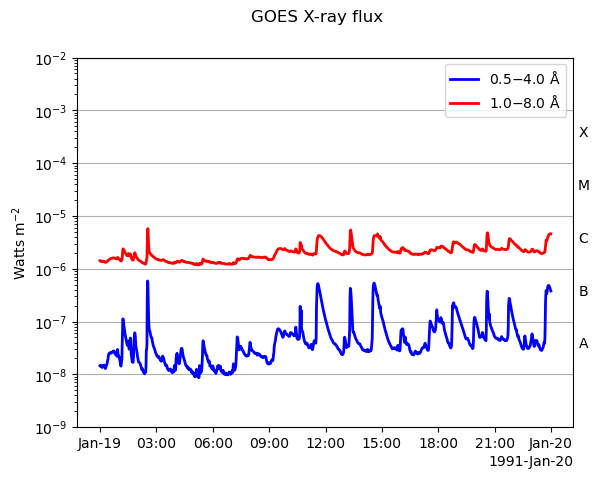

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1991-01-19 00:00:00
End Date:			1991-01-19 23:59:00
Center Date:			1991-01-19 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.75E+01<br>emission_measure   9.31E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1991-01-19 00:00:00     2.978802      0.000000e+00
1991-01-19 00:01:00     2.978802      0.000000e+00
1991-01-19 00:02:00     2.978802      0.000000e+00
1991-01-19 00:03:00     2.978802      0.000000e+00
1991-01-19 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1991-01-19 23:55:00     2.978802      9.458463e+48
1991-01-19 23:56:00     2.978802      7.190432e+48
1991-01-19 23:57:00     2.978802      5.198697e+48
1991-01-19 23:58:00     2.978802      3.067355e+48
1991-01-19

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1991-01-19 00:00:00
End Date:			1991-01-19 23:59:00
Center Date:			1991-01-19 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.90E+01<br>emission_measure   3.21E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1991-01-19 00:00:00     2.763595      0.000000e+00
1991-01-19 00:01:00     2.763595      0.000000e+00
1991-01-19 00:02:00     2.763595      0.000000e+00
1991-01-19 00:03:00     2.763595      0.000000e+00
1991-01-19 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1991-01-19 23:55:00     2.763595      3.262330e+49
1991-01-19 23:56:00     2.763595      2.480061e+49
1991-01-19 23:57:00     2.763595      1.793089e+49
1991-01-19 23:58:00     2.763595      1.057965e+49
1991-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.33file/s]


Cargando datos de 1991-07-06 00:00:00 en un TimeSeries:


2025-09-04 14:02:28 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:02:28 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1991-07-06 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1991-07-06 00:00:00
End Date:			1991-07-06 23:59:00
Center Date:			1991-07-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.79E-06<br>xrsb   2.94E-05
Units:			dimensionless
                             xrsa      xrsb
1991-07-06 00:00:00  1.703000e-07  0.000006
1991-07-06 00:01:00  1.621053e-07  0.000006
1991-07-06 00:02:00  1.541500e-07  0.000006
1991-07-06 00:03:00  1.478235e-07  0.000005
1991-07-06 00:04:00  1.423158e-07  0.000005
...                           ...       ...
1991-07-06 23:55:00  1.211000e-08  0.000001
1991-07-06 23:56:00  1.142632e-08  0.000001
1991-07-06 23:57:00  1.0

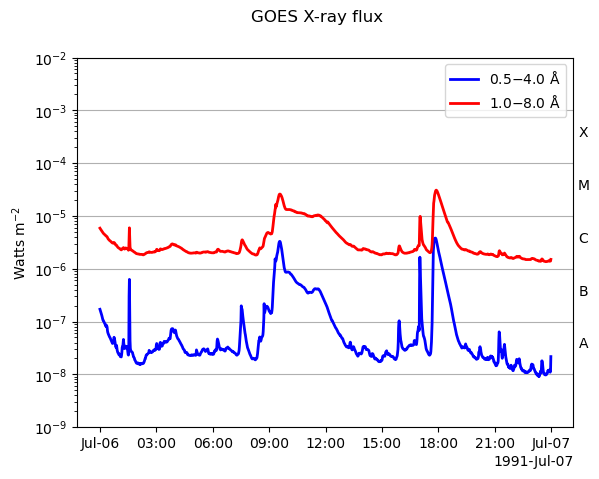

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1991-07-06 00:00:00
End Date:			1991-07-06 23:59:00
Center Date:			1991-07-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.91E+01<br>emission_measure   2.38E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1991-07-06 00:00:00     2.978802      0.000000e+00
1991-07-06 00:01:00     2.978802      0.000000e+00
1991-07-06 00:02:00     2.978802      0.000000e+00
1991-07-06 00:03:00     2.978802      0.000000e+00
1991-07-06 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1991-07-06 23:55:00     5.675554      6.626251e+46
1991-07-06 23:56:00     2.978802      2.449097e+47
1991-07-06 23:57:00     2.978802     -1.614401e+47
1991-07-06 23:58:00     2.978802      1.274539e+47
1991-07-06

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1991-07-06 00:00:00
End Date:			1991-07-06 23:59:00
Center Date:			1991-07-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.11E+01<br>emission_measure   8.22E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1991-07-06 00:00:00     2.763595      0.000000e+00
1991-07-06 00:01:00     2.763595      0.000000e+00
1991-07-06 00:02:00     2.763595      0.000000e+00
1991-07-06 00:03:00     2.763595      0.000000e+00
1991-07-06 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1991-07-06 23:55:00     4.920062      2.547094e+47
1991-07-06 23:56:00     2.763595      8.447210e+47
1991-07-06 23:57:00     2.763595     -5.568249e+47
1991-07-06 23:58:00     2.763595      4.396028e+47
1991-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1991-12-21 00:00:00 en un TimeSeries:


2025-09-04 14:02:40 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:02:40 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1991-12-21 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1991-12-21 00:00:00
End Date:			1991-12-21 23:59:00
Center Date:			1991-12-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   2.43E-06<br>xrsb   1.49E-05
Units:			dimensionless
                             xrsa      xrsb
1991-12-21 00:00:00  5.862500e-08  0.000002
1991-12-21 00:01:00  5.847368e-08  0.000002
1991-12-21 00:02:00  5.758500e-08  0.000002
1991-12-21 00:03:00  5.765263e-08  0.000002
1991-12-21 00:04:00  5.714706e-08  0.000002
...                           ...       ...
1991-12-21 23:55:00  3.677368e-08  0.000002
1991-12-21 23:56:00  3.711500e-08  0.000002
1991-12-21 23:57:00  3.5

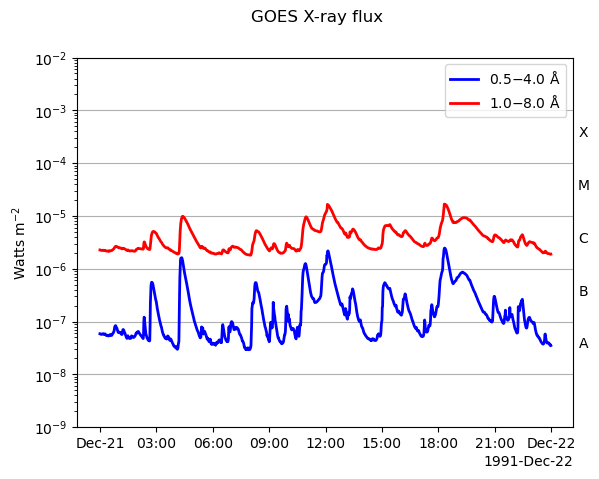

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.47s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1991-12-21 00:00:00
End Date:			1991-12-21 23:59:00
Center Date:			1991-12-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.96E+02<br>emission_measure   1.01E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1991-12-21 00:00:00     2.978802      0.000000e+00
1991-12-21 00:01:00     2.978802      0.000000e+00
1991-12-21 00:02:00     2.978802      0.000000e+00
1991-12-21 00:03:00     2.978802      0.000000e+00
1991-12-21 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1991-12-21 23:55:00     2.978802     -7.116128e+47
1991-12-21 23:56:00     2.978802     -6.154884e+47
1991-12-21 23:57:00     2.978802     -7.647142e+47
1991-12-21 23:58:00     2.978802     -1.139576e+48
1991-12-21

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.01s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1991-12-21 00:00:00
End Date:			1991-12-21 23:59:00
Center Date:			1991-12-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        3.10E+02<br>emission_measure   3.47E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1991-12-21 00:00:00     2.763595      0.000000e+00
1991-12-21 00:01:00     2.763595      0.000000e+00
1991-12-21 00:02:00     2.763595      0.000000e+00
1991-12-21 00:03:00     2.763595      0.000000e+00
1991-12-21 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1991-12-21 23:55:00     2.763595     -2.454432e+48
1991-12-21 23:56:00     2.763595     -2.122889e+48
1991-12-21 23:57:00     2.763595     -2.637585e+48
1991-12-21 23:58:00     2.763595     -3.930526e+48
1991-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1992-06-06 00:00:00 en un TimeSeries:


2025-09-04 14:02:53 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:02:53 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1992-06-06 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1992-06-06 00:00:00
End Date:			1992-06-06 23:59:00
Center Date:			1992-06-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   4.38E-07<br>xrsb   3.94E-06
Units:			dimensionless
                             xrsa          xrsb
1992-06-06 00:00:00  1.838947e-09  2.543158e-07
1992-06-06 00:01:00  1.319000e-09  2.506000e-07
1992-06-06 00:02:00  1.491053e-09  2.539474e-07
1992-06-06 00:03:00  2.852353e-09  2.696471e-07
1992-06-06 00:04:00  3.130000e-09  2.804500e-07
...                           ...           ...
1992-06-06 23:55:00  3.533000e-09  3.256000e-07
1992-06-06 23:56:00  3.030526e-09  3

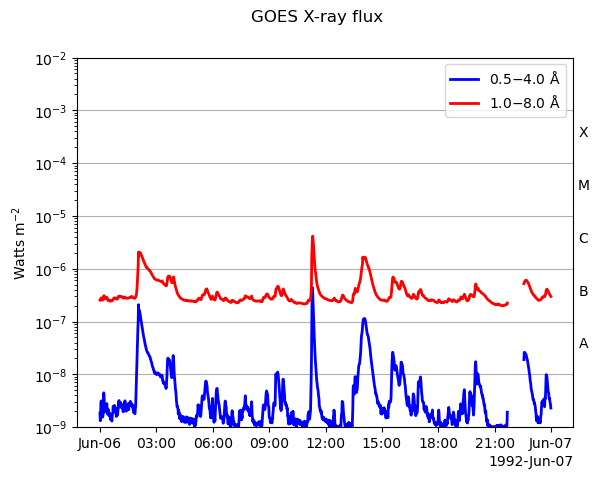

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1992-06-06 00:00:00
End Date:			1992-06-06 23:59:00
Center Date:			1992-06-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.05E+01<br>emission_measure   5.69E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1992-06-06 00:00:00     2.978802      0.000000e+00
1992-06-06 00:01:00     2.978802      0.000000e+00
1992-06-06 00:02:00     2.978802      0.000000e+00
1992-06-06 00:03:00     2.978802      0.000000e+00
1992-06-06 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1992-06-06 23:55:00     2.978802     -1.042293e+48
1992-06-06 23:56:00     2.978802     -1.023866e+48
1992-06-06 23:57:00     2.978802     -9.383674e+47
1992-06-06 23:58:00     2.978802     -8.492787e+47
1992-06-06

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1992-06-06 00:00:00
End Date:			1992-06-06 23:59:00
Center Date:			1992-06-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        9.96E+00<br>emission_measure   1.96E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1992-06-06 00:00:00     2.763595      0.000000e+00
1992-06-06 00:01:00     2.763595      0.000000e+00
1992-06-06 00:02:00     2.763595      0.000000e+00
1992-06-06 00:03:00     2.763595      0.000000e+00
1992-06-06 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1992-06-06 23:55:00     2.763595     -3.594986e+48
1992-06-06 23:56:00     2.763595     -3.531430e+48
1992-06-06 23:57:00     2.763595     -3.236534e+48
1992-06-06 23:58:00     2.763595     -2.929258e+48
1992-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1992-11-21 00:00:00 en un TimeSeries:


2025-09-04 14:03:05 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:03:05 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1992-11-21 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1992-11-21 00:00:00
End Date:			1992-11-21 23:59:00
Center Date:			1992-11-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   6.64E-07<br>xrsb   4.48E-06
Units:			dimensionless
                             xrsa          xrsb
1992-11-21 00:00:00  4.826471e-09  6.342353e-07
1992-11-21 00:01:00  5.240526e-09  6.365789e-07
1992-11-21 00:02:00  5.543500e-09  6.465000e-07
1992-11-21 00:03:00  6.420000e-09  6.602500e-07
1992-11-21 00:04:00  6.592632e-09  6.701579e-07
...                           ...           ...
1992-11-21 23:55:00  6.824211e-09  8.106315e-07
1992-11-21 23:56:00  7.866999e-09  8

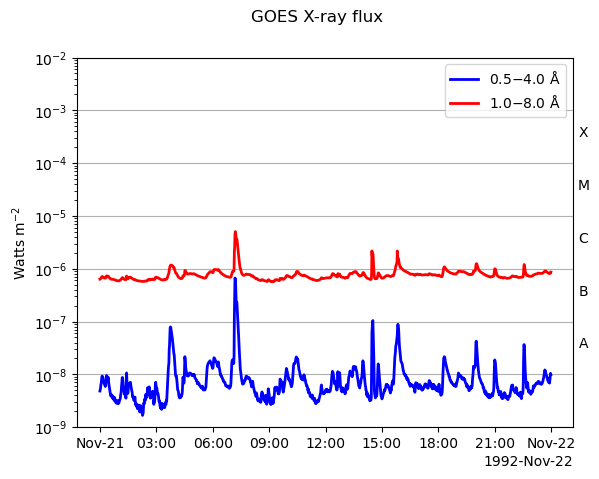

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1992-11-21 00:00:00
End Date:			1992-11-21 23:59:00
Center Date:			1992-11-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.34E+01<br>emission_measure   5.27E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1992-11-21 00:00:00     2.978802      0.000000e+00
1992-11-21 00:01:00     2.978802      0.000000e+00
1992-11-21 00:02:00     2.978802      0.000000e+00
1992-11-21 00:03:00     2.978802      0.000000e+00
1992-11-21 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1992-11-21 23:55:00     2.978802     -4.004135e+47
1992-11-21 23:56:00     2.978802     -2.875656e+47
1992-11-21 23:57:00     2.978802      4.513928e+47
1992-11-21 23:58:00     9.147118      4.282752e+46
1992-11-21

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1992-11-21 00:00:00
End Date:			1992-11-21 23:59:00
Center Date:			1992-11-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.35E+01<br>emission_measure   1.82E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1992-11-21 00:00:00     2.763595      0.000000e+00
1992-11-21 00:01:00     2.763595      0.000000e+00
1992-11-21 00:02:00     2.763595      0.000000e+00
1992-11-21 00:03:00     2.763595      0.000000e+00
1992-11-21 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1992-11-21 23:55:00     2.763595     -1.381071e+48
1992-11-21 23:56:00     2.763595     -9.918461e+47
1992-11-21 23:57:00     2.763595      1.556904e+48
1992-11-21 23:58:00     8.044589      1.314657e+47
1992-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.39file/s]


Cargando datos de 1993-05-08 00:00:00 en un TimeSeries:


2025-09-04 14:03:17 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:03:17 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1993-05-08 00:00:00 tengan resolución de un min
Resolution detected: 3.06 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1993-05-08 00:00:00
End Date:			1993-05-08 23:59:00
Center Date:			1993-05-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.89E-07<br>xrsb   2.77E-06
Units:			dimensionless
                             xrsa          xrsb
1993-05-08 00:00:00  7.842915e-08  3.002302e-06
1993-05-08 00:01:00  7.649508e-08  2.952907e-06
1993-05-08 00:02:00  7.476312e-08  2.904205e-06
1993-05-08 00:03:00  7.321557e-08  2.855764e-06
1993-05-08 00:04:00  7.173883e-08  2.822747e-06
...                           ...           ...
1993-05-08 23:55:00  9.520263e-10  3.539086e-07
1993-05-08 23:56:00  2.271640e-09  3

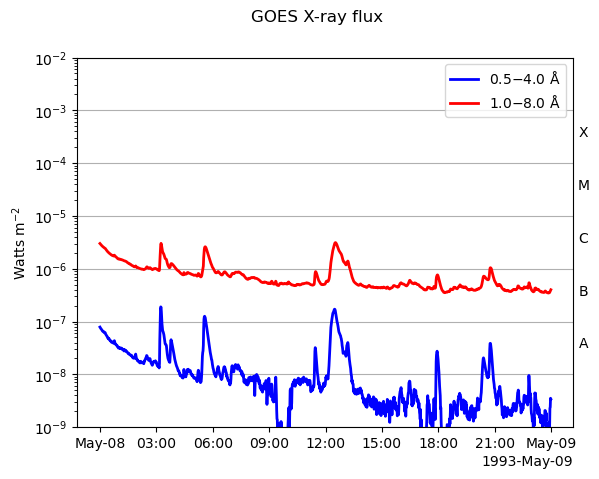

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.18s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1993-05-08 00:00:00
End Date:			1993-05-08 23:59:00
Center Date:			1993-05-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.30E+01<br>emission_measure   3.03E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1993-05-08 00:00:00     2.978802      0.000000e+00
1993-05-08 00:01:00     2.978802      0.000000e+00
1993-05-08 00:02:00     2.978802      0.000000e+00
1993-05-08 00:03:00     2.978802      0.000000e+00
1993-05-08 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1993-05-08 23:55:00     2.978802      1.260607e+47
1993-05-08 23:56:00     2.978802      3.381394e+47
1993-05-08 23:57:00     2.978802      5.503827e+47
1993-05-08 23:58:00     9.477557      2.983101e+46
1993-05-08

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1993-05-08 00:00:00
End Date:			1993-05-08 23:59:00
Center Date:			1993-05-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.30E+01<br>emission_measure   1.04E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1993-05-08 00:00:00     2.763595      0.000000e+00
1993-05-08 00:01:00     2.763595      0.000000e+00
1993-05-08 00:02:00     2.763595      0.000000e+00
1993-05-08 00:03:00     2.763595      0.000000e+00
1993-05-08 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1993-05-08 23:55:00     2.763595      4.347977e+47
1993-05-08 23:56:00     2.763595      1.166281e+48
1993-05-08 23:57:00     2.763595      1.898331e+48
1993-05-08 23:58:00     8.357437      8.966727e+46
1993-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1993-10-23 00:00:00 en un TimeSeries:


2025-09-04 14:03:28 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:03:28 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1993-10-23 00:00:00 tengan resolución de un min
Resolution detected: 3.06 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1993-10-23 00:00:00
End Date:			1993-10-23 23:59:00
Center Date:			1993-10-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.67E-08<br>xrsb   5.90E-07
Units:			dimensionless
                             xrsa          xrsb
1993-10-23 00:00:00  1.262150e-10  1.169537e-07
1993-10-23 00:01:00  3.385842e-10  1.169374e-07
1993-10-23 00:02:00  2.149650e-10  1.180398e-07
1993-10-23 00:03:00  1.406684e-10  1.172640e-07
1993-10-23 00:04:00  2.231550e-10  1.199016e-07
...                           ...           ...
1993-10-23 23:55:00  2.278150e-10  1.434844e-07
1993-10-23 23:56:00  3.275105e-10  1

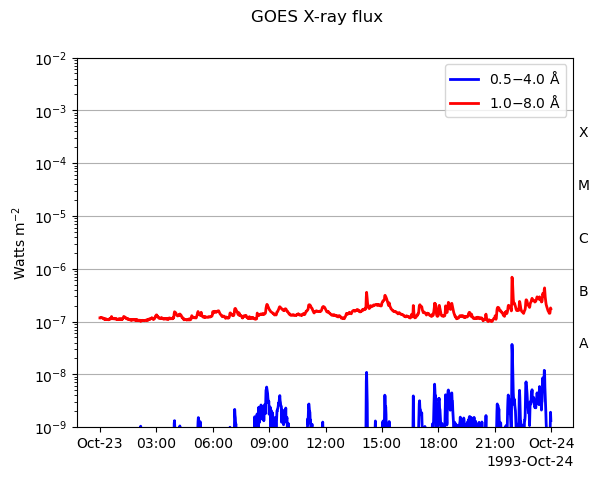

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1993-10-23 00:00:00
End Date:			1993-10-23 23:59:00
Center Date:			1993-10-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.21E+00<br>emission_measure   9.97E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1993-10-23 00:00:00     2.978802      0.000000e+00
1993-10-23 00:01:00     2.978802      0.000000e+00
1993-10-23 00:02:00     2.978802      0.000000e+00
1993-10-23 00:03:00     2.978802      0.000000e+00
1993-10-23 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1993-10-23 23:55:00     2.978802     -3.287464e+47
1993-10-23 23:56:00     2.978802     -2.570646e+47
1993-10-23 23:57:00     2.978802      1.565457e+47
1993-10-23 23:58:00     8.132959      2.961641e+46
1993-10-23

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1993-10-23 00:00:00
End Date:			1993-10-23 23:59:00
Center Date:			1993-10-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.28E+00<br>emission_measure   3.44E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1993-10-23 00:00:00     2.763595      0.000000e+00
1993-10-23 00:01:00     2.763595      0.000000e+00
1993-10-23 00:02:00     2.763595      0.000000e+00
1993-10-23 00:03:00     2.763595      0.000000e+00
1993-10-23 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1993-10-23 23:55:00     2.763595     -1.133883e+48
1993-10-23 23:56:00     2.763595     -8.866447e+47
1993-10-23 23:57:00     2.763595      5.399437e+47
1993-10-23 23:58:00     7.104514      9.712276e+46
1993-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.73file/s]


Cargando datos de 1994-04-09 00:00:00 en un TimeSeries:


2025-09-04 14:03:40 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:03:40 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1994-04-09 00:00:00 tengan resolución de un min
Resolution detected: 3.06 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-6
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1994-04-09 00:00:00
End Date:			1994-04-09 23:59:00
Center Date:			1994-04-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.38E-08<br>xrsb   1.71E-07
Units:			dimensionless
                             xrsa          xrsb
1994-04-09 00:00:00  8.043158e-11  1.633485e-08
1994-04-09 00:01:00  6.295900e-10  1.765771e-08
1994-04-09 00:02:00  1.227200e-10  1.874376e-08
1994-04-09 00:03:00  7.797895e-11  1.339517e-08
1994-04-09 00:04:00  1.507500e-10  1.626136e-08
...                           ...           ...
1994-04-09 23:55:00  8.671894e-10  2.384738e-08
1994-04-09 23:56:00  8.958400e-10  2

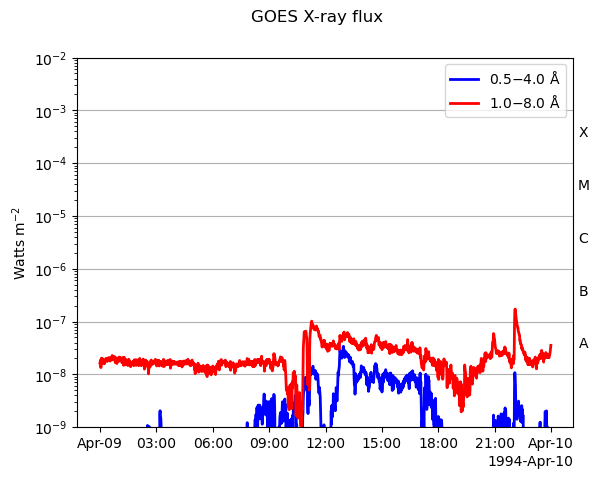

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1994-04-09 00:00:00
End Date:			1994-04-09 23:59:00
Center Date:			1994-04-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.45E+01<br>emission_measure   2.39E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1994-04-09 00:00:00     2.978802      0.000000e+00
1994-04-09 00:01:00     2.978802      0.000000e+00
1994-04-09 00:02:00     2.978802      0.000000e+00
1994-04-09 00:03:00     2.978802      0.000000e+00
1994-04-09 00:04:00     2.978802      0.000000e+00
...                          ...               ...
1994-04-09 23:55:00     2.978802     -3.295680e+45
1994-04-09 23:56:00     2.978802      1.565457e+46
1994-04-09 23:57:00     2.978802      1.064512e+47
1994-04-09 23:58:00     2.978802      2.438819e+47
1994-04-09

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.04file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1994-04-09 00:00:00
End Date:			1994-04-09 23:59:00
Center Date:			1994-04-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.49E+01<br>emission_measure   8.24E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1994-04-09 00:00:00     2.763595      0.000000e+00
1994-04-09 00:01:00     2.763595      0.000000e+00
1994-04-09 00:02:00     2.763595      0.000000e+00
1994-04-09 00:03:00     2.763595      0.000000e+00
1994-04-09 00:04:00     2.763595      0.000000e+00
...                          ...               ...
1994-04-09 23:55:00     2.763595     -1.136717e+46
1994-04-09 23:56:00     2.763595      5.399437e+46
1994-04-09 23:57:00     2.763595      3.671620e+47
1994-04-09 23:58:00     2.763595      8.411760e+47
1994-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.38file/s]


Cargando datos de 1994-09-24 00:00:00 en un TimeSeries:


2025-09-04 14:03:51 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:03:51 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1994-09-24 00:00:00 tengan resolución de un min
Resolution detected: 3.06 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-7
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1994-09-24 00:00:00
End Date:			1994-09-24 23:59:00
Center Date:			1994-09-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.46E-09<br>xrsb   4.77E-08
Units:			dimensionless
                             xrsa          xrsb
1994-09-24 00:00:00  3.307102e-10  9.742410e-09
1994-09-24 00:01:00  3.777052e-10  9.094810e-09
1994-09-24 00:02:00  1.738001e-10  8.685800e-09
1994-09-24 00:03:00  1.775051e-10  9.094810e-09
1994-09-24 00:04:00  2.098580e-10  9.197064e-09
...                           ...           ...
1994-09-24 23:55:00  3.277851e-10  2.204681e-08
1994-09-24 23:56:00  2.495422e-10  2

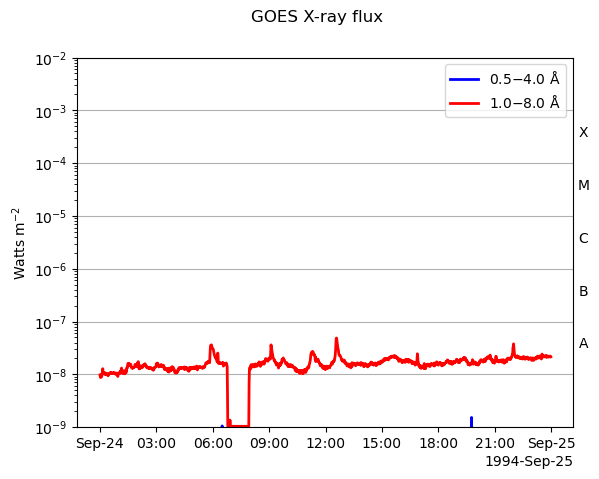

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.30file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1994-09-24 00:00:00
End Date:			1994-09-24 23:59:00
Center Date:			1994-09-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   8.58E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1994-09-24 00:00:00     2.999061      0.000000e+00
1994-09-24 00:01:00     2.999061      0.000000e+00
1994-09-24 00:02:00     2.999061      0.000000e+00
1994-09-24 00:03:00     2.999061      0.000000e+00
1994-09-24 00:04:00     2.999061      0.000000e+00
...                          ...               ...
1994-09-24 23:55:00     2.999061      1.196232e+46
1994-09-24 23:56:00     2.999061      3.147999e+45
1994-09-24 23:57:00     2.999061     -5.981195e+45
1994-09-24 23:58:00     2.999061      1.495292e+46
1994-09-24

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1994-09-24 00:00:00
End Date:			1994-09-24 23:59:00
Center Date:			1994-09-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   3.02E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1994-09-24 00:00:00     2.774622      0.000000e+00
1994-09-24 00:01:00     2.774622      0.000000e+00
1994-09-24 00:02:00     2.774622      0.000000e+00
1994-09-24 00:03:00     2.774622      0.000000e+00
1994-09-24 00:04:00     2.774622      0.000000e+00
...                          ...               ...
1994-09-24 23:55:00     2.774622      4.209806e+46
1994-09-24 23:56:00     2.774622      1.107850e+46
1994-09-24 23:57:00     2.774622     -2.104914e+46
1994-09-24 23:58:00     2.774622      5.262263e+46
1994-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1995-03-11 00:00:00 en un TimeSeries:


2025-09-04 14:04:01 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:04:01 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1995-03-11 00:00:00 tengan resolución de un min
Resolution detected: 3.06 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-7
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1995-03-11 00:00:00
End Date:			1995-03-11 23:59:00
Center Date:			1995-03-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   7.75E-09<br>xrsb   1.17E-07
Units:			dimensionless
                             xrsa          xrsb
1995-03-11 00:00:00  1.640159e-10  1.141764e-07
1995-03-11 00:01:00  2.497201e-10  1.146536e-07
1995-03-11 00:02:00  3.184901e-10  1.130346e-07
1995-03-11 00:03:00  1.542316e-10  1.128131e-07
1995-03-11 00:04:00  1.339550e-10  1.127108e-07
...                           ...           ...
1995-03-11 23:55:00  2.168369e-10  3.339686e-08
1995-03-11 23:56:00  2.653851e-10  3

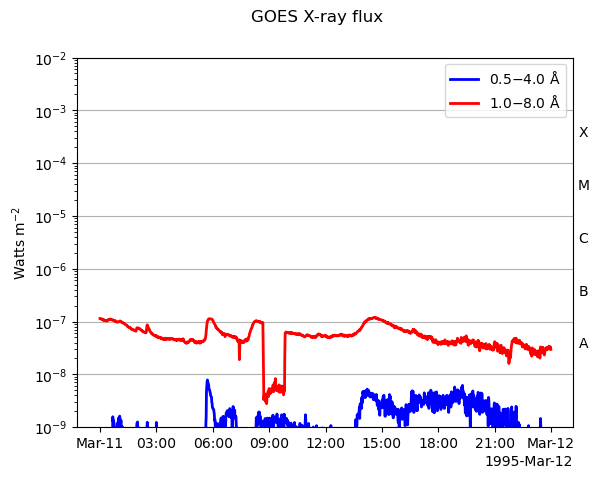

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1995-03-11 00:00:00
End Date:			1995-03-11 23:59:00
Center Date:			1995-03-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.25E+01<br>emission_measure   3.50E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1995-03-11 00:00:00     2.999061      0.000000e+00
1995-03-11 00:01:00     2.999061      0.000000e+00
1995-03-11 00:02:00     2.999061      0.000000e+00
1995-03-11 00:03:00     2.999061      0.000000e+00
1995-03-11 00:04:00     2.999061      0.000000e+00
...                          ...               ...
1995-03-11 23:55:00     2.999061      3.022064e+46
1995-03-11 23:56:00     2.999061      2.093412e+46
1995-03-11 23:57:00     2.999061     -3.148032e+45
1995-03-11 23:58:00     2.999061     -2.691524e+46
1995-03-11

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1995-03-11 00:00:00
End Date:			1995-03-11 23:59:00
Center Date:			1995-03-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.22E+01<br>emission_measure   1.20E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1995-03-11 00:00:00     2.774622      0.000000e+00
1995-03-11 00:01:00     2.774622      0.000000e+00
1995-03-11 00:02:00     2.774622      0.000000e+00
1995-03-11 00:03:00     2.774622      0.000000e+00
1995-03-11 00:04:00     2.774622      0.000000e+00
...                          ...               ...
1995-03-11 23:55:00     2.774622      1.063531e+47
1995-03-11 23:56:00     2.774622      7.367177e+46
1995-03-11 23:57:00     2.774622     -1.107862e+46
1995-03-11 23:58:00     2.774622     -9.472068e+46
1995-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1995-08-26 00:00:00 en un TimeSeries:
 Error al abrir archivo GOES de 1995-08-26 00:00:00: Something went wrong: ERFA function "taiutc" yielded 7097 of "unacceptable date"
 Error al abrir archivo GOES de 1995-08-26 00:00:00: Something went wrong: ERFA function "taiutc" yielded 7097 of "unacceptable date"
No hay datos GOES para 1995-08-26 00:00:00 - 1995-08-26 23:59:00
No hay datos GOES para 1995-08-26 00:00:00 - 1995-08-26 23:59:00. Día saltado.

Día 1995-08-26 00:00:00 - 1995-08-26 23:59:00 saltado (sin datos GOES).
1. Descargar datos GOES
Buscando datos de: 1996-02-10 00:00:00
Data found according to the date(1996-02-10 00:00:00): Results from 1 Provider:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument  Phy

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.37file/s]


Cargando datos de 1996-02-10 00:00:00 en un TimeSeries:


2025-09-04 14:04:18 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:04:18 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1996-02-10 00:00:00 tengan resolución de un min
Resolution detected: 3.06 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-7
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1996-02-10 00:00:00
End Date:			1996-02-10 23:59:00
Center Date:			1996-02-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.16E-09<br>xrsb   3.30E-09
Units:			dimensionless
                             xrsa          xrsb
1996-02-10 00:00:00  4.029252e-10  2.042654e-09
1996-02-10 00:01:00  7.513686e-11  1.338054e-09
1996-02-10 00:02:00  1.745801e-10  1.610802e-09
1996-02-10 00:03:00  6.200000e-11  1.322901e-09
1996-02-10 00:04:00  1.014106e-10  2.569163e-09
...                           ...           ...
1996-02-10 23:55:00  1.081158e-10  1.338054e-09
1996-02-10 23:56:00  1.870601e-10  1

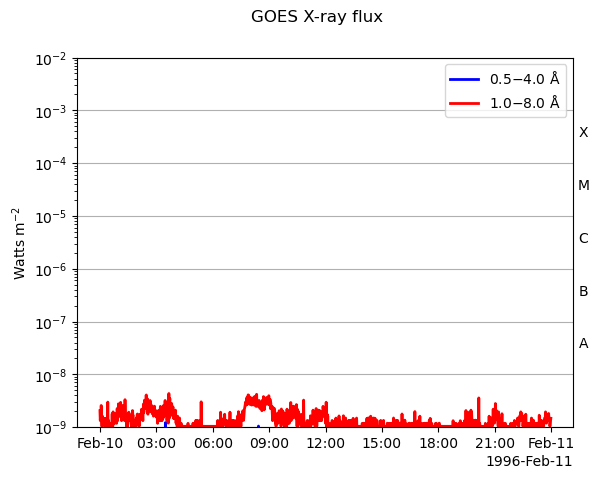

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1996-02-10 00:00:00
End Date:			1996-02-10 23:59:00
Center Date:			1996-02-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   9.37E+46
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1996-02-10 00:00:00     2.999061      0.000000e+00
1996-02-10 00:01:00     2.999061      0.000000e+00
1996-02-10 00:02:00     2.999061      0.000000e+00
1996-02-10 00:03:00     2.999061      0.000000e+00
1996-02-10 00:04:00     2.999061      0.000000e+00
...                          ...               ...
1996-02-10 23:55:00     2.999061     -5.597949e+45
1996-02-10 23:56:00     2.999061     -7.977075e+45
1996-02-10 23:57:00     2.999061     -1.154491e+46
1996-02-10 23:58:00     2.999061     -2.659023e+45
1996-02-10

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1996-02-10 00:00:00
End Date:			1996-02-10 23:59:00
Center Date:			1996-02-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   3.30E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1996-02-10 00:00:00     2.774622      0.000000e+00
1996-02-10 00:01:00     2.774622      0.000000e+00
1996-02-10 00:02:00     2.774622      0.000000e+00
1996-02-10 00:03:00     2.774622      0.000000e+00
1996-02-10 00:04:00     2.774622      0.000000e+00
...                          ...               ...
1996-02-10 23:55:00     2.774622     -1.970042e+46
1996-02-10 23:56:00     2.774622     -2.807309e+46
1996-02-10 23:57:00     2.774622     -4.062907e+46
1996-02-10 23:58:00     2.774622     -9.357688e+45
1996-

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  6.84file/s]


Cargando datos de 1996-07-27 00:00:00 en un TimeSeries:


2025-09-04 14:04:28 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:04:28 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1996-07-27 00:00:00 tengan resolución de un min
Resolution detected: 3.06 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-7
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1996-07-27 00:00:00
End Date:			1996-07-27 23:59:00
Center Date:			1996-07-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.72E-08<br>xrsb   2.70E-07
Units:			dimensionless
                             xrsa          xrsb
1996-07-27 00:00:00  1.145474e-10  5.197275e-08
1996-07-27 00:01:00  1.557301e-10  5.377921e-08
1996-07-27 00:02:00  1.400651e-10  5.167451e-08
1996-07-27 00:03:00  2.299737e-10  5.265443e-08
1996-07-27 00:04:00  1.119201e-10  5.394111e-08
...                           ...           ...
1996-07-27 23:55:00  2.626791e-10  5.810790e-08
1996-07-27 23:56:00  1.870601e-10  5

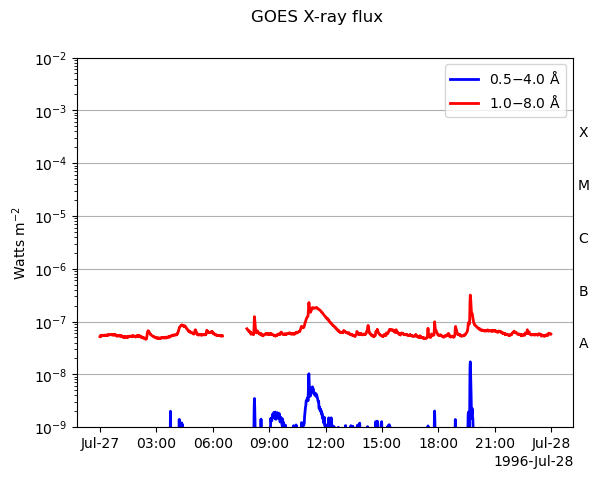

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1996-07-27 00:00:00
End Date:			1996-07-27 23:59:00
Center Date:			1996-07-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.92E+00<br>emission_measure   3.78E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1996-07-27 00:00:00     2.999061      0.000000e+00
1996-07-27 00:01:00     2.999061      0.000000e+00
1996-07-27 00:02:00     2.999061      0.000000e+00
1996-07-27 00:03:00     2.999061      0.000000e+00
1996-07-27 00:04:00     2.999061      0.000000e+00
...                          ...               ...
1996-07-27 23:55:00     2.999061      3.510000e+46
1996-07-27 23:56:00     2.999061     -8.971726e+45
1996-07-27 23:57:00     2.999061     -1.888799e+46
1996-07-27 23:58:00     2.999061     -2.392471e+46
1996-07-27

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1996-07-27 00:00:00
End Date:			1996-07-27 23:59:00
Center Date:			1996-07-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.03E+00<br>emission_measure   1.33E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1996-07-27 00:00:00     2.774622      0.000000e+00
1996-07-27 00:01:00     2.774622      0.000000e+00
1996-07-27 00:02:00     2.774622      0.000000e+00
1996-07-27 00:03:00     2.774622      0.000000e+00
1996-07-27 00:04:00     2.774622      0.000000e+00
...                          ...               ...
1996-07-27 23:55:00     2.774622      1.235246e+47
1996-07-27 23:56:00     2.774622     -3.157348e+46
1996-07-27 23:57:00     2.774622     -6.647102e+46
1996-07-27 23:58:00     2.774622     -8.419634e+46
1996-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.73file/s]


Cargando datos de 1997-01-11 00:00:00 en un TimeSeries:


2025-09-04 14:04:39 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:04:39 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1997-01-11 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1997-01-11 00:00:00
End Date:			1997-01-11 23:59:00
Center Date:			1997-01-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.88E-09<br>xrsb   8.42E-09
Units:			dimensionless
                             xrsa          xrsb
1997-01-11 00:00:00           NaN           NaN
1997-01-11 00:01:00           NaN           NaN
1997-01-11 00:02:00           NaN           NaN
1997-01-11 00:03:00  2.270638e-09  1.349118e-08
1997-01-11 00:04:00  9.619521e-10  8.676151e-09
...                           ...           ...
1997-01-11 23:55:00  9.318118e-10  5.748868e-09
1997-01-11 23:56:00  9.303681e-10  5

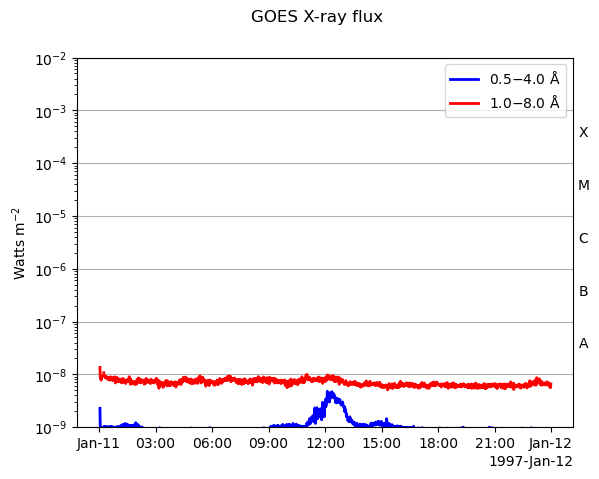

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1997-01-11 00:00:00
End Date:			1997-01-11 23:59:00
Center Date:			1997-01-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.13E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1997-01-11 00:00:00     3.269362      0.000000e+00
1997-01-11 00:01:00     3.269362      0.000000e+00
1997-01-11 00:02:00     3.269362      0.000000e+00
1997-01-11 00:03:00     3.269362      0.000000e+00
1997-01-11 00:04:00     3.269362      0.000000e+00
...                          ...               ...
1997-01-11 23:55:00     3.269362     -1.113807e+46
1997-01-11 23:56:00     3.269362     -1.057756e+46
1997-01-11 23:57:00     3.269362     -9.693133e+45
1997-01-11 23:58:00     3.269362     -1.116507e+46
1997-01-11

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.11s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1997-01-11 00:00:00
End Date:			1997-01-11 23:59:00
Center Date:			1997-01-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   4.07E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1997-01-11 00:00:00     2.993372      0.000000e+00
1997-01-11 00:01:00     2.993372      0.000000e+00
1997-01-11 00:02:00     2.993372      0.000000e+00
1997-01-11 00:03:00     2.993372      0.000000e+00
1997-01-11 00:04:00     2.993372      0.000000e+00
...                          ...               ...
1997-01-11 23:55:00     2.993372     -3.998624e+46
1997-01-11 23:56:00     2.993372     -3.797398e+46
1997-01-11 23:57:00     2.993372     -3.479884e+46
1997-01-11 23:58:00     2.993372     -4.008318e+46
1997-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.74file/s]


Cargando datos de 1997-06-28 00:00:00 en un TimeSeries:


2025-09-04 14:04:50 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:04:50 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1997-06-28 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1997-06-28 00:00:00
End Date:			1997-06-28 23:59:00
Center Date:			1997-06-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   8.44E-09<br>xrsb   2.09E-07
Units:			dimensionless
                             xrsa          xrsb
1997-06-28 00:00:00  9.012592e-10  1.033856e-08
1997-06-28 00:01:00  9.045974e-10  9.309866e-09
1997-06-28 00:02:00  9.035171e-10  9.999856e-09
1997-06-28 00:03:00  9.066253e-10  9.546121e-09
1997-06-28 00:04:00  9.036363e-10  9.707631e-09
...                           ...           ...
1997-06-28 23:55:00  8.958711e-10  5.860325e-09
1997-06-28 23:56:00  8.983959e-10  5

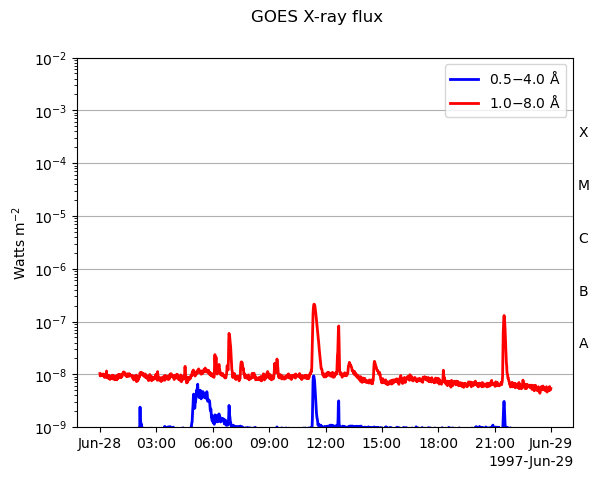

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1997-06-28 00:00:00
End Date:			1997-06-28 23:59:00
Center Date:			1997-06-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.08E+00<br>emission_measure   4.92E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1997-06-28 00:00:00     3.269362      0.000000e+00
1997-06-28 00:01:00     3.269362      0.000000e+00
1997-06-28 00:02:00     3.269362      0.000000e+00
1997-06-28 00:03:00     3.269362      0.000000e+00
1997-06-28 00:04:00     3.269362      0.000000e+00
...                          ...               ...
1997-06-28 23:55:00     3.269362      8.128803e+45
1997-06-28 23:56:00     3.269362      8.880521e+45
1997-06-28 23:57:00     3.269362     -6.105615e+45
1997-06-28 23:58:00     3.269362     -4.532149e+44
1997-06-28

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1997-06-28 00:00:00
End Date:			1997-06-28 23:59:00
Center Date:			1997-06-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.18E+00<br>emission_measure   1.62E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1997-06-28 00:00:00     2.993372      0.000000e+00
1997-06-28 00:01:00     2.993372      0.000000e+00
1997-06-28 00:02:00     2.993372      0.000000e+00
1997-06-28 00:03:00     2.993372      0.000000e+00
1997-06-28 00:04:00     2.993372      0.000000e+00
...                          ...               ...
1997-06-28 23:55:00     2.993372      2.918281e+46
1997-06-28 23:56:00     2.993372      3.188152e+46
1997-06-28 23:57:00     2.993372     -2.191946e+46
1997-06-28 23:58:00     2.993372     -1.627064e+45
1997-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.51file/s]


Cargando datos de 1997-12-13 00:00:00 en un TimeSeries:


2025-09-04 14:05:01 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:05:01 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1997-12-13 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1997-12-13 00:00:00
End Date:			1997-12-13 23:59:00
Center Date:			1997-12-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.22E-08<br>xrsb   2.85E-07
Units:			dimensionless
                             xrsa          xrsb
1997-12-13 00:00:00  1.098205e-09  1.868875e-07
1997-12-13 00:01:00  1.160626e-09  1.837383e-07
1997-12-13 00:02:00  1.082043e-09  1.817869e-07
1997-12-13 00:03:00  1.171849e-09  1.806390e-07
1997-12-13 00:04:00  1.117030e-09  1.790339e-07
...                           ...           ...
1997-12-13 23:55:00  1.028851e-09  1.263235e-07
1997-12-13 23:56:00  9.870870e-10  1

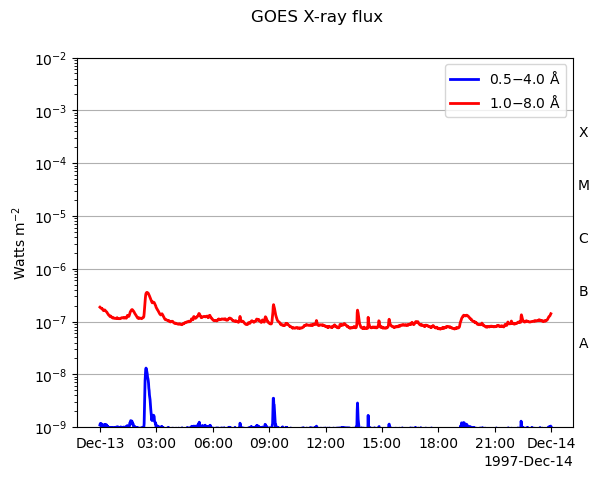

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1997-12-13 00:00:00
End Date:			1997-12-13 23:59:00
Center Date:			1997-12-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.55E+00<br>emission_measure   1.55E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1997-12-13 00:00:00     3.269362      0.000000e+00
1997-12-13 00:01:00     3.269362      0.000000e+00
1997-12-13 00:02:00     3.269362      0.000000e+00
1997-12-13 00:03:00     3.269362      0.000000e+00
1997-12-13 00:04:00     3.269362      0.000000e+00
...                          ...               ...
1997-12-13 23:55:00     3.269362      1.540778e+47
1997-12-13 23:56:00     3.269362      1.509264e+47
1997-12-13 23:57:00     3.269362      1.628024e+47
1997-12-13 23:58:00     3.269362      1.653715e+47
1997-12-13

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1997-12-13 00:00:00
End Date:			1997-12-13 23:59:00
Center Date:			1997-12-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.67E+00<br>emission_measure   5.52E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1997-12-13 00:00:00     2.993372      0.000000e+00
1997-12-13 00:01:00     2.993372      0.000000e+00
1997-12-13 00:02:00     2.993372      0.000000e+00
1997-12-13 00:03:00     2.993372      0.000000e+00
1997-12-13 00:04:00     2.993372      0.000000e+00
...                          ...               ...
1997-12-13 23:55:00     2.993372      5.531470e+47
1997-12-13 23:56:00     2.993372      5.418335e+47
1997-12-13 23:57:00     2.993372      5.844687e+47
1997-12-13 23:58:00     2.993372      5.936919e+47
1997-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.75file/s]


Cargando datos de 1998-05-30 00:00:00 en un TimeSeries:


2025-09-04 14:05:11 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:05:11 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1998-05-30 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1998-05-30 00:00:00
End Date:			1998-05-30 23:59:00
Center Date:			1998-05-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   7.83E-08<br>xrsb   7.44E-07
Units:			dimensionless
                             xrsa          xrsb
1998-05-30 00:00:00  2.376276e-08  9.587075e-07
1998-05-30 00:01:00  2.328432e-08  9.449238e-07
1998-05-30 00:02:00  2.519652e-08  9.547352e-07
1998-05-30 00:03:00  2.801919e-08  9.797297e-07
1998-05-30 00:04:00  2.750246e-08  9.803175e-07
...                           ...           ...
1998-05-30 23:55:00  9.634804e-10  2.511831e-07
1998-05-30 23:56:00  9.685082e-10  2

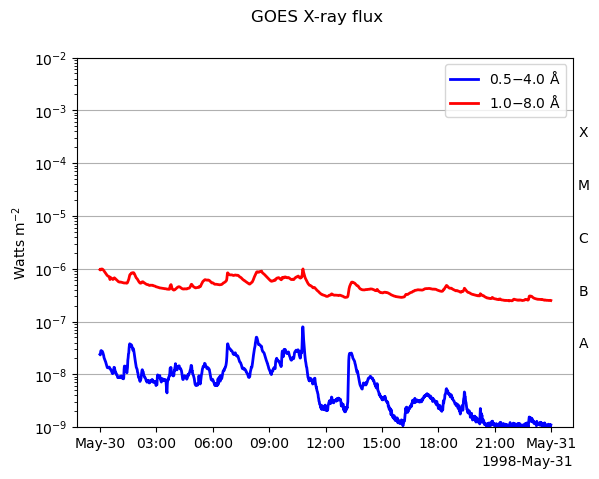

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1998-05-30 00:00:00
End Date:			1998-05-30 23:59:00
Center Date:			1998-05-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.87E+01<br>emission_measure   5.34E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1998-05-30 00:00:00     3.269362      0.000000e+00
1998-05-30 00:01:00     3.269362      0.000000e+00
1998-05-30 00:02:00     3.269362      0.000000e+00
1998-05-30 00:03:00     3.269362      0.000000e+00
1998-05-30 00:04:00     3.269362      0.000000e+00
...                          ...               ...
1998-05-30 23:55:00     3.269362     -4.730391e+45
1998-05-30 23:56:00     3.269362     -1.948034e+46
1998-05-30 23:57:00     3.269362      2.635533e+46
1998-05-30 23:58:00     3.269362      1.552055e+46
1998-05-30

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1998-05-30 00:00:00
End Date:			1998-05-30 23:59:00
Center Date:			1998-05-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.09E+01<br>emission_measure   1.90E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1998-05-30 00:00:00     2.993372      0.000000e+00
1998-05-30 00:01:00     2.993372      0.000000e+00
1998-05-30 00:02:00     2.993372      0.000000e+00
1998-05-30 00:03:00     2.993372      0.000000e+00
1998-05-30 00:04:00     2.993372      0.000000e+00
...                          ...               ...
1998-05-30 23:55:00     2.993372     -1.698234e+46
1998-05-30 23:56:00     2.993372     -6.993540e+46
1998-05-30 23:57:00     2.993372      9.461698e+46
1998-05-30 23:58:00     2.993372      5.571957e+46
1998-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.60file/s]


Cargando datos de 1998-11-14 00:00:00 en un TimeSeries:


2025-09-04 14:05:22 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:05:22 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1998-11-14 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1998-11-14 00:00:00
End Date:			1998-11-14 23:59:00
Center Date:			1998-11-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.90E-07<br>xrsb   2.19E-06
Units:			dimensionless
                             xrsa          xrsb
1998-11-14 00:00:00  6.178309e-09  7.346819e-07
1998-11-14 00:01:00  6.270599e-09  7.323774e-07
1998-11-14 00:02:00  6.368315e-09  7.336607e-07
1998-11-14 00:03:00  6.068187e-09  7.320374e-07
1998-11-14 00:04:00  5.937139e-09  7.248065e-07
...                           ...           ...
1998-11-14 23:55:00  2.863789e-09  4.254728e-07
1998-11-14 23:56:00  2.887243e-09  4

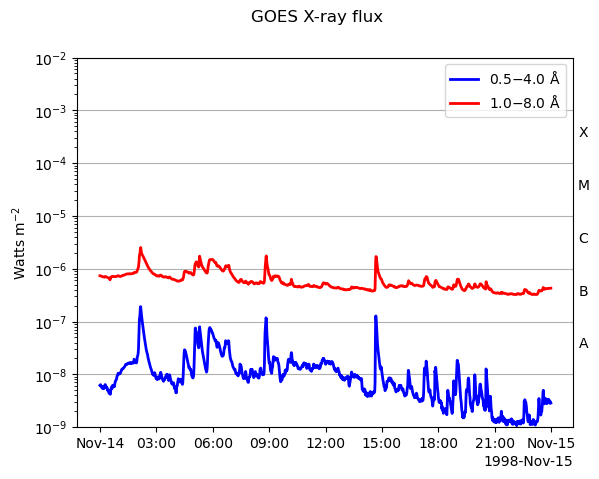

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1998-11-14 00:00:00
End Date:			1998-11-14 23:59:00
Center Date:			1998-11-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.64E+01<br>emission_measure   1.30E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1998-11-14 00:00:00     3.269362      0.000000e+00
1998-11-14 00:01:00     3.269362      0.000000e+00
1998-11-14 00:02:00     3.269362      0.000000e+00
1998-11-14 00:03:00     3.269362      0.000000e+00
1998-11-14 00:04:00     3.269362      0.000000e+00
...                          ...               ...
1998-11-14 23:55:00     3.269362      2.276000e+46
1998-11-14 23:56:00     3.269362      3.648706e+45
1998-11-14 23:57:00     3.269362      1.614480e+46
1998-11-14 23:58:00     3.269362      6.431022e+46
1998-11-14

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1998-11-14 00:00:00
End Date:			1998-11-14 23:59:00
Center Date:			1998-11-14 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.76E+01<br>emission_measure   4.68E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1998-11-14 00:00:00     2.993372      0.000000e+00
1998-11-14 00:01:00     2.993372      0.000000e+00
1998-11-14 00:02:00     2.993372      0.000000e+00
1998-11-14 00:03:00     2.993372      0.000000e+00
1998-11-14 00:04:00     2.993372      0.000000e+00
...                          ...               ...
1998-11-14 23:55:00     2.993372      8.170956e+46
1998-11-14 23:56:00     2.993372      1.309904e+46
1998-11-14 23:57:00     2.993372      5.796063e+46
1998-11-14 23:58:00     2.993372      2.308769e+47
1998-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.60file/s]


Cargando datos de 1999-05-01 00:00:00 en un TimeSeries:


2025-09-04 14:05:33 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:05:33 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1999-05-01 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1999-05-01 00:00:00
End Date:			1999-05-01 23:59:00
Center Date:			1999-05-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.53E-07<br>xrsb   2.70E-06
Units:			dimensionless
                             xrsa          xrsb
1999-05-01 00:00:00  9.323268e-09  6.218015e-07
1999-05-01 00:01:00  8.260360e-09  6.123751e-07
1999-05-01 00:02:00  7.934860e-09  6.010264e-07
1999-05-01 00:03:00  7.161752e-09  5.884665e-07
1999-05-01 00:04:00  6.577378e-09  5.742825e-07
...                           ...           ...
1999-05-01 23:55:00  1.638018e-09  4.908628e-07
1999-05-01 23:56:00  1.866686e-09  4

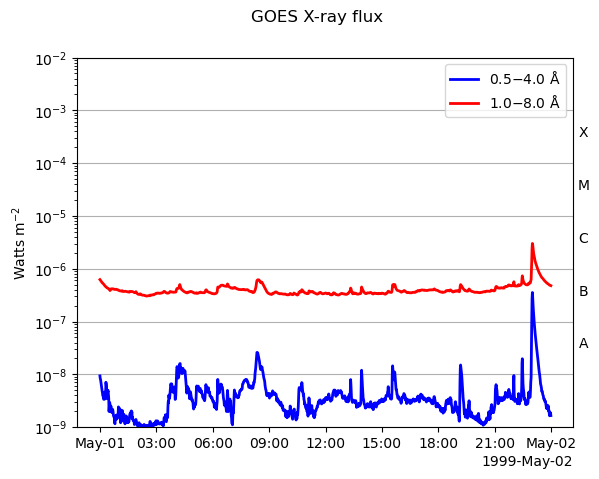

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1999-05-01 00:00:00
End Date:			1999-05-01 23:59:00
Center Date:			1999-05-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.13E+01<br>emission_measure   1.90E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1999-05-01 00:00:00     3.269362      0.000000e+00
1999-05-01 00:01:00     3.269362      0.000000e+00
1999-05-01 00:02:00     3.269362      0.000000e+00
1999-05-01 00:03:00     3.269362      0.000000e+00
1999-05-01 00:04:00     3.269362      0.000000e+00
...                          ...               ...
1999-05-01 23:55:00     3.269362     -3.972027e+47
1999-05-01 23:56:00     3.269362     -3.834211e+47
1999-05-01 23:57:00     3.269362     -3.515393e+47
1999-05-01 23:58:00     3.269362     -2.738982e+47
1999-05-01

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1999-05-01 00:00:00
End Date:			1999-05-01 23:59:00
Center Date:			1999-05-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.10E+01<br>emission_measure   6.65E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1999-05-01 00:00:00     2.993372      0.000000e+00
1999-05-01 00:01:00     2.993372      0.000000e+00
1999-05-01 00:02:00     2.993372      0.000000e+00
1999-05-01 00:03:00     2.993372      0.000000e+00
1999-05-01 00:04:00     2.993372      0.000000e+00
...                          ...               ...
1999-05-01 23:55:00     2.993372     -1.425978e+48
1999-05-01 23:56:00     2.993372     -1.376501e+48
1999-05-01 23:57:00     2.993372     -1.262044e+48
1999-05-01 23:58:00     2.993372     -9.833082e+47
1999-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.74file/s]


Cargando datos de 1999-10-16 00:00:00 en un TimeSeries:


2025-09-04 14:05:44 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:05:44 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 1999-10-16 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			1999-10-16 00:00:00
End Date:			1999-10-16 23:59:00
Center Date:			1999-10-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   3.91E-07<br>xrsb   3.12E-06
Units:			dimensionless
                             xrsa          xrsb
1999-10-16 00:00:00  6.485344e-08  1.758020e-06
1999-10-16 00:01:00  5.352360e-08  1.684064e-06
1999-10-16 00:02:00  3.715289e-08  1.525608e-06
1999-10-16 00:03:00  3.011017e-08  1.423894e-06
1999-10-16 00:04:00  1.940704e-08  1.281727e-06
...                           ...           ...
1999-10-16 23:55:00  2.686566e-09  6.814391e-07
1999-10-16 23:56:00  2.581618e-09  6

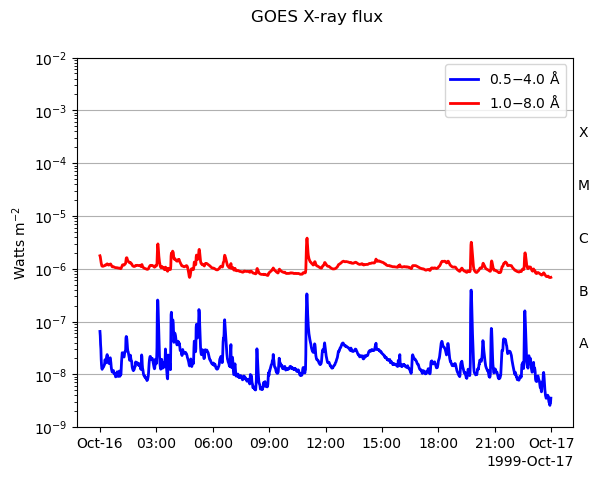

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1999-10-16 00:00:00
End Date:			1999-10-16 23:59:00
Center Date:			1999-10-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.40E+01<br>emission_measure   3.78E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1999-10-16 00:00:00     3.269362      0.000000e+00
1999-10-16 00:01:00     3.269362      0.000000e+00
1999-10-16 00:02:00     3.269362      0.000000e+00
1999-10-16 00:03:00     3.269362      0.000000e+00
1999-10-16 00:04:00     3.269362      0.000000e+00
...                          ...               ...
1999-10-16 23:55:00     3.269362     -6.422449e+47
1999-10-16 23:56:00     3.269362     -5.610901e+47
1999-10-16 23:57:00     3.269362     -3.163933e+47
1999-10-16 23:58:00     3.269362     -1.201396e+47
1999-10-16

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			1999-10-16 00:00:00
End Date:			1999-10-16 23:59:00
Center Date:			1999-10-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.41E+01<br>emission_measure   1.36E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
1999-10-16 00:00:00     2.993372      0.000000e+00
1999-10-16 00:01:00     2.993372      0.000000e+00
1999-10-16 00:02:00     2.993372      0.000000e+00
1999-10-16 00:03:00     2.993372      0.000000e+00
1999-10-16 00:04:00     2.993372      0.000000e+00
...                          ...               ...
1999-10-16 23:55:00     2.993372     -2.305691e+48
1999-10-16 23:56:00     2.993372     -2.014342e+48
1999-10-16 23:57:00     2.993372     -1.135868e+48
1999-10-16 23:58:00     2.993372     -4.313072e+47
1999-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.59file/s]


Cargando datos de 2000-04-01 00:00:00 en un TimeSeries:


2025-09-04 14:05:56 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:05:56 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 2000-04-01 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			2000-04-01 00:00:00
End Date:			2000-04-01 23:59:00
Center Date:			2000-04-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   1.65E-06<br>xrsb   7.52E-06
Units:			dimensionless
                             xrsa      xrsb
2000-04-01 00:00:00  7.522856e-08  0.000002
2000-04-01 00:01:00  9.733403e-08  0.000002
2000-04-01 00:02:00  4.796446e-08  0.000002
2000-04-01 00:03:00  3.018981e-08  0.000002
2000-04-01 00:04:00  2.810572e-08  0.000002
...                           ...       ...
2000-04-01 23:55:00  8.515001e-08  0.000002
2000-04-01 23:56:00  8.281464e-08  0.000002
2000-04-01 23:57:00  7.1

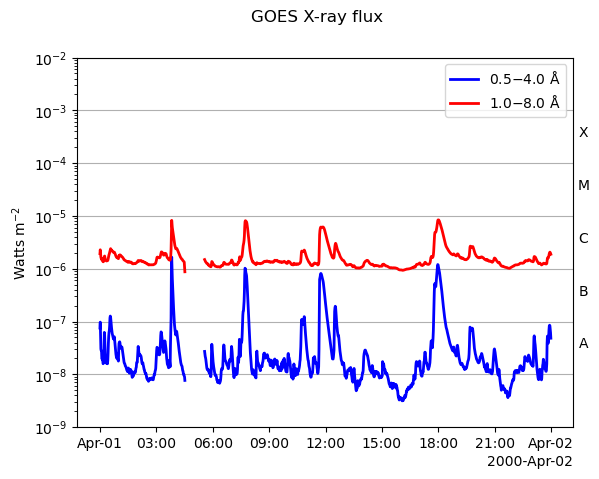

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2000-04-01 00:00:00
End Date:			2000-04-01 23:59:00
Center Date:			2000-04-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.05E+01<br>emission_measure   6.73E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2000-04-01 00:00:00     3.269362      0.000000e+00
2000-04-01 00:01:00     3.269362      0.000000e+00
2000-04-01 00:02:00     3.269362      0.000000e+00
2000-04-01 00:03:00     3.269362      0.000000e+00
2000-04-01 00:04:00     3.269362      0.000000e+00
...                          ...               ...
2000-04-01 23:55:00    12.104934      2.512912e+47
2000-04-01 23:56:00    11.428398      2.934360e+47
2000-04-01 23:57:00     9.004681      2.875744e+47
2000-04-01 23:58:00     3.269362      2.014404e+48
2000-04-01

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2000-04-01 00:00:00
End Date:			2000-04-01 23:59:00
Center Date:			2000-04-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.38E+01<br>emission_measure   2.41E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2000-04-01 00:00:00     2.993372      0.000000e+00
2000-04-01 00:01:00     2.993372      0.000000e+00
2000-04-01 00:02:00     2.993372      0.000000e+00
2000-04-01 00:03:00     2.993372      0.000000e+00
2000-04-01 00:04:00     2.993372      0.000000e+00
...                          ...               ...
2000-04-01 23:55:00    11.097169      6.358577e+47
2000-04-01 23:56:00    10.347952      7.774110e+47
2000-04-01 23:57:00     7.933230      8.876169e+47
2000-04-01 23:58:00     2.993372      7.231814e+48
2000-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.74file/s]


Cargando datos de 2000-09-16 00:00:00 en un TimeSeries:


2025-09-04 14:06:07 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsa
2025-09-04 14:06:07 - sunpy - WARNING: SunpyUserWarning: Unknown units for xrsb


Nos aseguramos que los datos de 2000-09-16 00:00:00 tengan resolución de un min
Resolution detected: 3.00 s → resampling at 1 min
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-8
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">X-ray Detector</a>
Channel(s):			xrsa<br>xrsb
Start Date:			2000-09-16 00:00:00
End Date:			2000-09-16 23:59:00
Center Date:			2000-09-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa   9.15E-06<br>xrsb   3.93E-05
Units:			dimensionless
                             xrsa          xrsb
2000-09-16 00:00:00  5.455058e-09  8.950731e-07
2000-09-16 00:01:00  5.120945e-09  8.810906e-07
2000-09-16 00:02:00  4.951353e-09  8.727621e-07
2000-09-16 00:03:00  5.082810e-09  8.713828e-07
2000-09-16 00:04:00  5.261914e-09  8.708574e-07
...                           ...           ...
2000-09-16 23:55:00  1.738744e-08  1.191858e-06
2000-09-16 23:56:00  1.840731e-08  1

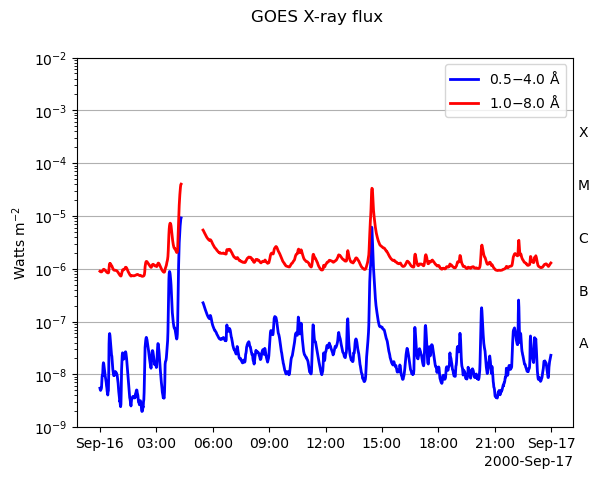

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2000-09-16 00:00:00
End Date:			2000-09-16 23:59:00
Center Date:			2000-09-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.16E+01<br>emission_measure   3.54E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2000-09-16 00:00:00     3.269362      0.000000e+00
2000-09-16 00:01:00     3.269362      0.000000e+00
2000-09-16 00:02:00     3.269362      0.000000e+00
2000-09-16 00:03:00     3.269362      0.000000e+00
2000-09-16 00:04:00     3.269362      0.000000e+00
...                          ...               ...
2000-09-16 23:55:00    12.502393      4.289660e+46
2000-09-16 23:56:00    11.129325      7.128249e+46
2000-09-16 23:57:00    10.182933      9.407299e+46
2000-09-16 23:58:00     9.354099      1.069736e+47
2000-09-16

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.16file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2000-09-16 00:00:00
End Date:			2000-09-16 23:59:00
Center Date:			2000-09-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.51E+01<br>emission_measure   1.27E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2000-09-16 00:00:00     2.993372      0.000000e+00
2000-09-16 00:01:00     2.993372      0.000000e+00
2000-09-16 00:02:00     2.993372      0.000000e+00
2000-09-16 00:03:00     2.993372      0.000000e+00
2000-09-16 00:04:00     2.993372      0.000000e+00
...                          ...               ...
2000-09-16 23:55:00    11.550427      1.057072e+47
2000-09-16 23:56:00    10.028357      1.926317e+47
2000-09-16 23:57:00     9.061795      2.701066e+47
2000-09-16 23:58:00     8.261857      3.231626e+47
2000-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


Cargando datos de 2001-03-03 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2001-03-03 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2001-03-03 00:00:00
End Date:			2001-03-03 23:59:00
Center Date:			2001-03-03 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           7.71E-08<br>xrsb           9.32E-07<br>xrsa_quality   5.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2001-03-03 00:00:00  1.172237e-08  6.400758e-07             0             0
2001-03-03 00:01:00  1.172199e-08  6.354875e-07             0             0
2001-03-03 00:02:00  1.172162e-08  6.303595e-07           

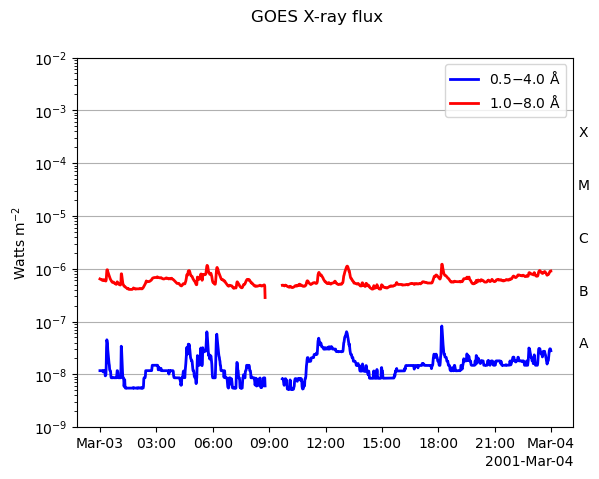

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2001-03-03 00:00:00
End Date:			2001-03-03 23:59:00
Center Date:			2001-03-03 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.27E+01<br>emission_measure   1.46E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2001-03-03 00:00:00     2.795147      0.000000e+00
2001-03-03 00:01:00     2.795147      0.000000e+00
2001-03-03 00:02:00     2.795147      0.000000e+00
2001-03-03 00:03:00     2.795147      0.000000e+00
2001-03-03 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2001-03-03 23:55:00    13.478544      3.789656e+46
2001-03-03 23:56:00    12.988585      4.473486e+46
2001-03-03 23:57:00    11.311317      5.335235e+46
2001-03-03 23:58:00     9.651958      5.312964e+46
2001-03-03

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2001-03-03 00:00:00
End Date:			2001-03-03 23:59:00
Center Date:			2001-03-03 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.25E+01<br>emission_measure   4.62E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2001-03-03 00:00:00     2.645967      0.000000e+00
2001-03-03 00:01:00     2.645967      0.000000e+00
2001-03-03 00:02:00     2.645967      0.000000e+00
2001-03-03 00:03:00     2.645967      0.000000e+00
2001-03-03 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2001-03-03 23:55:00    12.739558      8.657626e+46
2001-03-03 23:56:00    12.158260      1.054064e+47
2001-03-03 23:57:00    10.253932      1.407583e+47
2001-03-03 23:58:00     8.565015      1.561830e+47
2001-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.81file/s]


Cargando datos de 2001-08-18 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2001-08-18 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2001-08-18 00:00:00
End Date:			2001-08-18 23:59:00
Center Date:			2001-08-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           5.75E-07<br>xrsb           4.44E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2001-08-18 00:00:00  1.063013e-08  8.124548e-07             0             0
2001-08-18 00:01:00  1.202773e-08  8.126747e-07             0             0
2001-08-18 00:02:00  1.202721e-08  8.130080e-07           

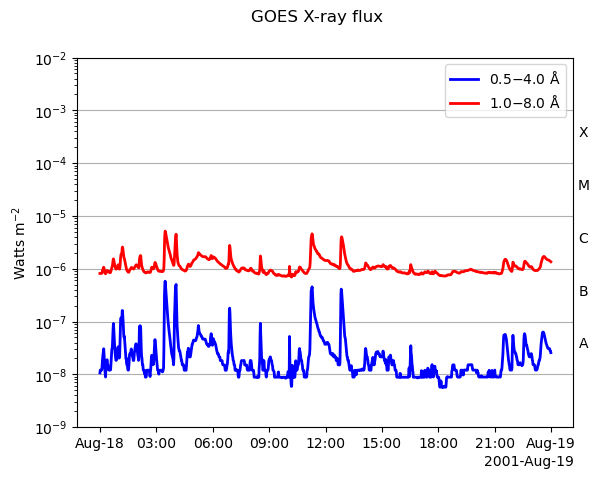

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2001-08-18 00:00:00
End Date:			2001-08-18 23:59:00
Center Date:			2001-08-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.53E+01<br>emission_measure   8.97E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2001-08-18 00:00:00     2.795147      0.000000e+00
2001-08-18 00:01:00     2.795147      0.000000e+00
2001-08-18 00:02:00     2.795147      0.000000e+00
2001-08-18 00:03:00     2.795147      0.000000e+00
2001-08-18 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2001-08-18 23:55:00     2.795147     -1.197535e+48
2001-08-18 23:56:00     2.795147     -1.398482e+48
2001-08-18 23:57:00     2.795147     -1.679582e+48
2001-08-18 23:58:00     2.795147     -1.758144e+48
2001-08-18

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.30file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2001-08-18 00:00:00
End Date:			2001-08-18 23:59:00
Center Date:			2001-08-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.59E+01<br>emission_measure   2.83E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2001-08-18 00:00:00     2.645967      0.000000e+00
2001-08-18 00:01:00     2.645967      0.000000e+00
2001-08-18 00:02:00     2.645967      0.000000e+00
2001-08-18 00:03:00     2.645967      0.000000e+00
2001-08-18 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2001-08-18 23:55:00     2.645967     -3.783565e+48
2001-08-18 23:56:00     2.645967     -4.418449e+48
2001-08-18 23:57:00     2.645967     -5.306572e+48
2001-08-18 23:58:00     2.645967     -5.554788e+48
2001-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.81file/s]


Cargando datos de 2002-02-02 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2002-02-02 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2002-02-02 00:00:00
End Date:			2002-02-02 23:59:00
Center Date:			2002-02-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.59E-07<br>xrsb           2.97E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2002-02-02 00:00:00  2.110554e-08  0.000002             0             0
2002-02-02 00:01:00  1.788282e-08  0.000002             0             0
2002-02-02 00:02:00  2.682572e-08  0.000002             0             

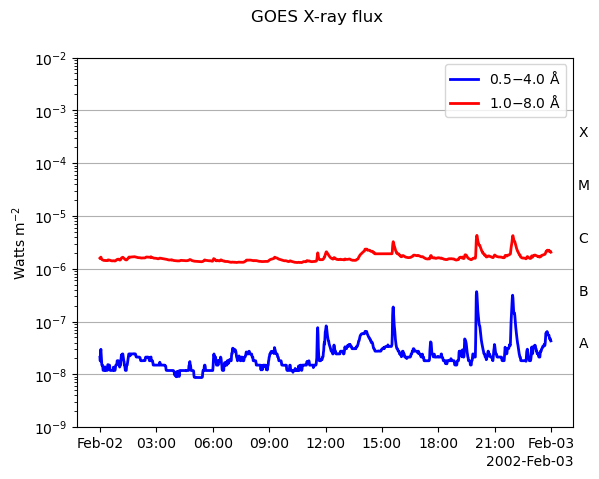

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2002-02-02 00:00:00
End Date:			2002-02-02 23:59:00
Center Date:			2002-02-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.48E+01<br>emission_measure   4.19E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2002-02-02 00:00:00     2.795147      0.000000e+00
2002-02-02 00:01:00     2.795147      0.000000e+00
2002-02-02 00:02:00     2.795147      0.000000e+00
2002-02-02 00:03:00     2.795147      0.000000e+00
2002-02-02 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2002-02-02 23:55:00     2.795147     -2.561711e+48
2002-02-02 23:56:00     2.795147     -6.937314e+47
2002-02-02 23:57:00     2.795147     -2.217942e+48
2002-02-02 23:58:00     2.795147     -2.697879e+48
2002-02-02

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2002-02-02 00:00:00
End Date:			2002-02-02 23:59:00
Center Date:			2002-02-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.50E+01<br>emission_measure   1.32E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2002-02-02 00:00:00     2.645967      0.000000e+00
2002-02-02 00:01:00     2.645967      0.000000e+00
2002-02-02 00:02:00     2.645967      0.000000e+00
2002-02-02 00:03:00     2.645967      0.000000e+00
2002-02-02 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2002-02-02 23:55:00     2.645967     -8.093625e+48
2002-02-02 23:56:00     2.645967     -2.191817e+48
2002-02-02 23:57:00     2.645967     -7.007500e+48
2002-02-02 23:58:00     2.645967     -8.523841e+48
2002-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


Cargando datos de 2002-07-20 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2002-07-20 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2002-07-20 00:00:00
End Date:			2002-07-20 23:59:00
Center Date:			2002-07-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.57E-04<br>xrsb           4.80E-04<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2002-07-20 00:00:00  5.788325e-08  0.000002             0             0
2002-07-20 00:01:00  5.818945e-08  0.000002             0             0
2002-07-20 00:02:00  5.809730e-08  0.000002             0             

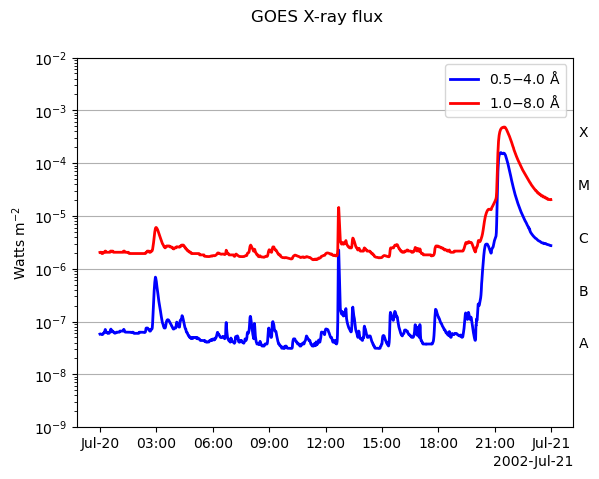

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2002-07-20 00:00:00
End Date:			2002-07-20 23:59:00
Center Date:			2002-07-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.72E+03<br>emission_measure   2.80E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2002-07-20 00:00:00     2.795147      0.000000e+00
2002-07-20 00:01:00     2.795147      0.000000e+00
2002-07-20 00:02:00     2.795147      0.000000e+00
2002-07-20 00:03:00     2.795147      0.000000e+00
2002-07-20 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2002-07-20 23:55:00     2.795147     -1.551521e+46
2002-07-20 23:56:00     2.795147      1.956464e+45
2002-07-20 23:57:00     2.795147     -2.106611e+46
2002-07-20 23:58:00     2.795147     -5.242641e+48
2002-07-20

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2002-07-20 00:00:00
End Date:			2002-07-20 23:59:00
Center Date:			2002-07-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.09E+03<br>emission_measure   8.85E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2002-07-20 00:00:00     2.645967      0.000000e+00
2002-07-20 00:01:00     2.645967      0.000000e+00
2002-07-20 00:02:00     2.645967      0.000000e+00
2002-07-20 00:03:00     2.645967      0.000000e+00
2002-07-20 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2002-07-20 23:55:00     2.645967     -4.901971e+46
2002-07-20 23:56:00     2.645967      6.181371e+45
2002-07-20 23:57:00     2.645967     -6.655755e+46
2002-07-20 23:58:00     2.645967     -1.656392e+49
2002-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


Cargando datos de 2003-01-04 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2003-01-04 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2003-01-04 00:00:00
End Date:			2003-01-04 23:59:00
Center Date:			2003-01-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.18E-07<br>xrsb           2.14E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2003-01-04 00:00:00  6.353962e-08  1.699779e-06             0             0
2003-01-04 00:01:00  8.078676e-08  1.798694e-06             0             0
2003-01-04 00:02:00  1.020355e-07  1.972616e-06           

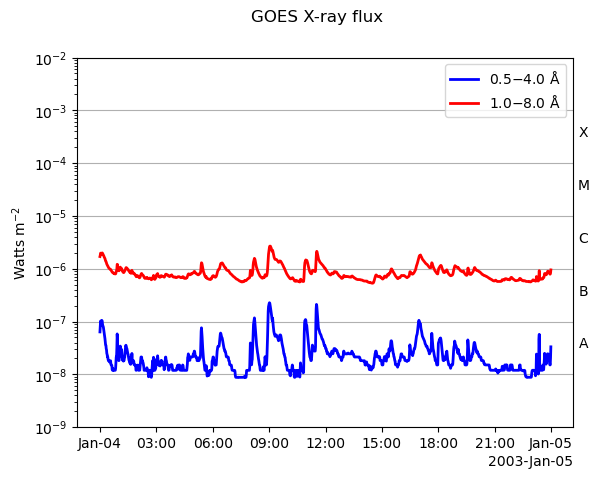

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2003-01-04 00:00:00
End Date:			2003-01-04 23:59:00
Center Date:			2003-01-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.63E+01<br>emission_measure   2.89E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2003-01-04 00:00:00     2.795147      0.000000e+00
2003-01-04 00:01:00     2.795147      0.000000e+00
2003-01-04 00:02:00     2.795147      0.000000e+00
2003-01-04 00:03:00     2.795147      0.000000e+00
2003-01-04 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2003-01-04 23:55:00     2.795147     -2.274229e+48
2003-01-04 23:56:00     2.795147     -2.297874e+48
2003-01-04 23:57:00     2.795147     -1.906031e+48
2003-01-04 23:58:00     2.795147     -4.410675e+47
2003-01-04

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2003-01-04 00:00:00
End Date:			2003-01-04 23:59:00
Center Date:			2003-01-04 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.74E+01<br>emission_measure   9.13E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2003-01-04 00:00:00     2.645967      0.000000e+00
2003-01-04 00:01:00     2.645967      0.000000e+00
2003-01-04 00:02:00     2.645967      0.000000e+00
2003-01-04 00:03:00     2.645967      0.000000e+00
2003-01-04 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2003-01-04 23:55:00     2.645967     -7.185336e+48
2003-01-04 23:56:00     2.645967     -7.260043e+48
2003-01-04 23:57:00     2.645967     -6.022030e+48
2003-01-04 23:58:00     2.645967     -1.393535e+48
2003-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.43file/s]


Cargando datos de 2003-06-21 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2003-06-21 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2003-06-21 00:00:00
End Date:			2003-06-21 23:59:00
Center Date:			2003-06-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           5.19E-07<br>xrsb           3.51E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2003-06-21 00:00:00  1.251765e-08  5.500000e-07             0             0
2003-06-21 00:01:00  1.263294e-08  5.542857e-07             0             0
2003-06-21 00:02:00  1.441176e-08  5.642857e-07           

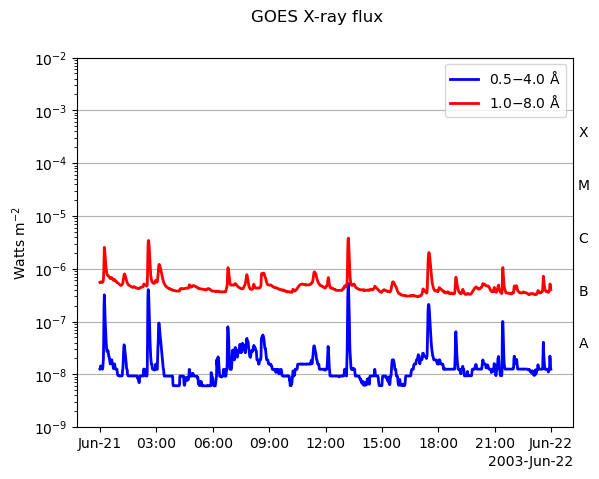

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2003-06-21 00:00:00
End Date:			2003-06-21 23:59:00
Center Date:			2003-06-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.87E+01<br>emission_measure   8.87E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2003-06-21 00:00:00     2.795147      0.000000e+00
2003-06-21 00:01:00     2.795147      0.000000e+00
2003-06-21 00:02:00     2.795147      0.000000e+00
2003-06-21 00:03:00     2.795147      0.000000e+00
2003-06-21 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2003-06-21 23:55:00     8.100981      3.905082e+46
2003-06-21 23:56:00    10.548562      8.078511e+46
2003-06-21 23:57:00     8.660619      1.045147e+47
2003-06-21 23:58:00     4.568673      2.122823e+47
2003-06-21

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2003-06-21 00:00:00
End Date:			2003-06-21 23:59:00
Center Date:			2003-06-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.07E+01<br>emission_measure   2.80E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2003-06-21 00:00:00     2.645967      0.000000e+00
2003-06-21 00:01:00     2.645967      0.000000e+00
2003-06-21 00:02:00     2.645967      0.000000e+00
2003-06-21 00:03:00     2.645967      0.000000e+00
2003-06-21 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2003-06-21 23:55:00     7.109444      1.268255e+47
2003-06-21 23:56:00     9.453718      2.242216e+47
2003-06-21 23:57:00     7.626620      3.272803e+47
2003-06-21 23:58:00     4.033156      8.235160e+47
2003-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.53file/s]


Cargando datos de 2003-12-06 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2003-12-06 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2003-12-06 00:00:00
End Date:			2003-12-06 23:59:00
Center Date:			2003-12-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           8.00E-06<br>xrsb           3.17E-05<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2003-12-06 00:00:00  1.195324e-08  4.715212e-07             0             0
2003-12-06 00:01:00  1.490446e-08  4.994520e-07             0             0
2003-12-06 00:02:00  1.937898e-08  5.558236e-07           

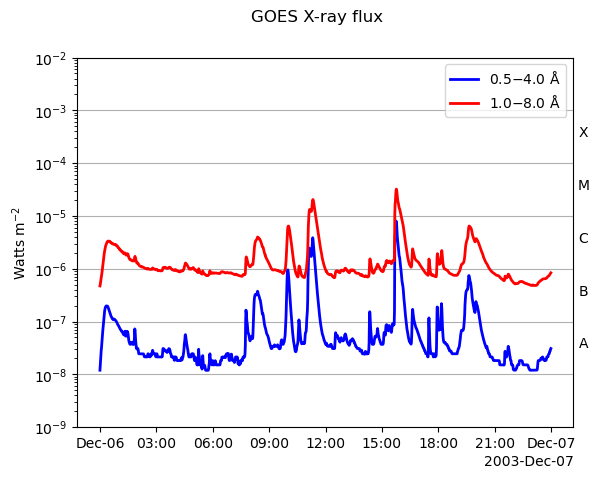

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2003-12-06 00:00:00
End Date:			2003-12-06 23:59:00
Center Date:			2003-12-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.64E+03<br>emission_measure   3.90E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2003-12-06 00:00:00     2.795147      0.000000e+00
2003-12-06 00:01:00     2.795147      0.000000e+00
2003-12-06 00:02:00     2.795147      0.000000e+00
2003-12-06 00:03:00     2.795147      0.000000e+00
2003-12-06 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2003-12-06 23:55:00    12.118039      2.350111e+46
2003-12-06 23:56:00    10.543925      3.283045e+46
2003-12-06 23:57:00     8.877911      4.871706e+46
2003-12-06 23:58:00    10.213758      4.548656e+46
2003-12-06

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2003-12-06 00:00:00
End Date:			2003-12-06 23:59:00
Center Date:			2003-12-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.05E+03<br>emission_measure   1.23E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2003-12-06 00:00:00     2.645967      0.000000e+00
2003-12-06 00:01:00     2.645967      0.000000e+00
2003-12-06 00:02:00     2.645967      0.000000e+00
2003-12-06 00:03:00     2.645967      0.000000e+00
2003-12-06 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2003-12-06 23:55:00    11.149389      5.866684e+46
2003-12-06 23:56:00     9.448988      9.114951e+46
2003-12-06 23:57:00     7.829559      1.504323e+47
2003-12-06 23:58:00     9.115850      1.290256e+47
2003-

Files Downloaded: 100%|██████████| 2/2 [00:02<00:00,  1.49s/file]


Cargando datos de 2004-05-22 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2004-05-22 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2004-05-22 00:00:00
End Date:			2004-05-22 23:59:00
Center Date:			2004-05-22 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.86E-06<br>xrsb           1.50E-05<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2004-05-22 00:00:00  1.865786e-06  1.525301e-05             0             0
2004-05-22 00:01:00  1.563118e-06  1.363963e-05             0             0
2004-05-22 00:02:00  1.324055e-06  1.223616e-05           

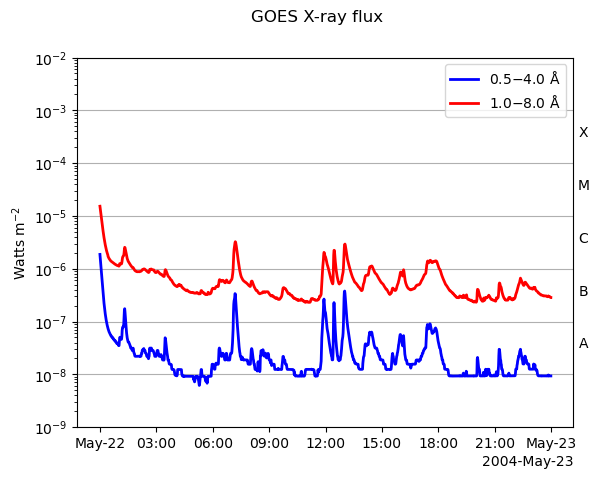

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2004-05-22 00:00:00
End Date:			2004-05-22 23:59:00
Center Date:			2004-05-22 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.14E+01<br>emission_measure   1.73E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2004-05-22 00:00:00     2.795147      0.000000e+00
2004-05-22 00:01:00     2.795147      0.000000e+00
2004-05-22 00:02:00     2.795147      0.000000e+00
2004-05-22 00:03:00     2.795147      0.000000e+00
2004-05-22 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2004-05-22 23:55:00     2.795147     -1.854375e+46
2004-05-22 23:56:00     2.795147     -2.671327e+47
2004-05-22 23:57:00     2.795147     -1.912742e+47
2004-05-22 23:58:00     2.795147     -4.130179e+47
2004-05-22

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2004-05-22 00:00:00
End Date:			2004-05-22 23:59:00
Center Date:			2004-05-22 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.48E+01<br>emission_measure   5.47E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2004-05-22 00:00:00     2.645967      0.000000e+00
2004-05-22 00:01:00     2.645967      0.000000e+00
2004-05-22 00:02:00     2.645967      0.000000e+00
2004-05-22 00:03:00     2.645967      0.000000e+00
2004-05-22 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2004-05-22 23:55:00     2.645967     -5.858826e+46
2004-05-22 23:56:00     2.645967     -8.439952e+47
2004-05-22 23:57:00     2.645967     -6.043233e+47
2004-05-22 23:58:00     2.645967     -1.304914e+48
2004-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  2.36file/s]


Cargando datos de 2004-11-06 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2004-11-06 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2004-11-06 00:00:00
End Date:			2004-11-06 23:59:00
Center Date:			2004-11-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           4.66E-05<br>xrsb           1.41E-04<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2004-11-06 00:00:00  2.661515e-08  8.662529e-07             0             0
2004-11-06 00:01:00  2.412991e-08  8.379469e-07             0             0
2004-11-06 00:02:00  2.133699e-08  8.012395e-07           

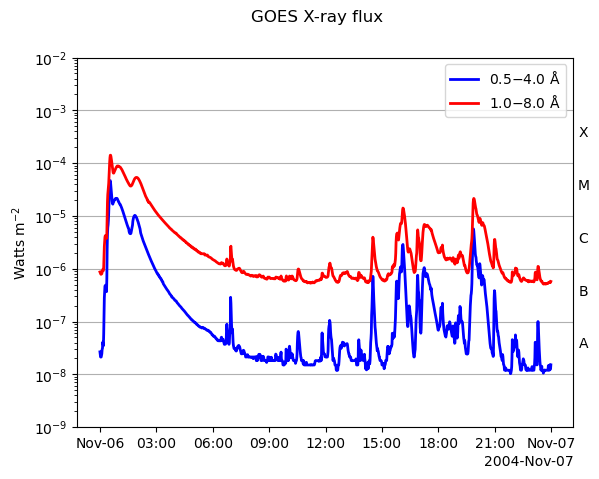

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2004-11-06 00:00:00
End Date:			2004-11-06 23:59:00
Center Date:			2004-11-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.46E+05<br>emission_measure   2.59E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2004-11-06 00:00:00     2.795147      0.000000e+00
2004-11-06 00:01:00     2.795147      0.000000e+00
2004-11-06 00:02:00     2.795147      0.000000e+00
2004-11-06 00:03:00     2.795147      0.000000e+00
2004-11-06 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2004-11-06 23:55:00     2.795147      4.525958e+47
2004-11-06 23:56:00     2.795147      4.547911e+47
2004-11-06 23:57:00     2.795147      1.366525e+47
2004-11-06 23:58:00     2.795147      3.518507e+46
2004-11-06

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2004-11-06 00:00:00
End Date:			2004-11-06 23:59:00
Center Date:			2004-11-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        3.09E+05<br>emission_measure   7.31E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2004-11-06 00:00:00     2.645967      0.000000e+00
2004-11-06 00:01:00     2.645967      0.000000e+00
2004-11-06 00:02:00     2.645967      0.000000e+00
2004-11-06 00:03:00     2.645967      0.000000e+00
2004-11-06 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2004-11-06 23:55:00     2.645967      1.429959e+48
2004-11-06 23:56:00     2.645967      1.436895e+48
2004-11-06 23:57:00     2.645967      4.317481e+47
2004-11-06 23:58:00     2.645967      1.111658e+47
2004-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.60file/s]


Cargando datos de 2005-04-23 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2005-04-23 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2005-04-23 00:00:00
End Date:			2005-04-23 23:59:00
Center Date:			2005-04-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.41E-08<br>xrsb           4.07E-07<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2005-04-23 00:00:00  5.967459e-09  3.383300e-08             0             0
2005-04-23 00:01:00  5.967047e-09  3.309136e-08             0             0
2005-04-23 00:02:00  5.967376e-09  3.264507e-08           

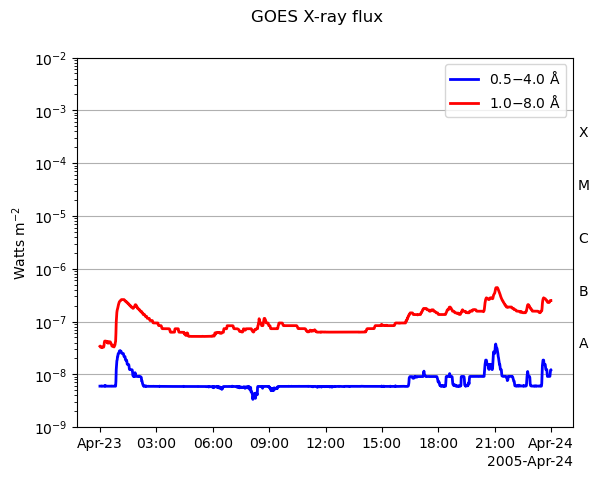

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2005-04-23 00:00:00
End Date:			2005-04-23 23:59:00
Center Date:			2005-04-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.13E+01<br>emission_measure   2.67E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2005-04-23 00:00:00     2.795147      0.000000e+00
2005-04-23 00:01:00     2.795147      0.000000e+00
2005-04-23 00:02:00     2.795147      0.000000e+00
2005-04-23 00:03:00     2.795147      0.000000e+00
2005-04-23 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2005-04-23 23:55:00     2.795147      2.448225e+47
2005-04-23 23:56:00     2.795147      2.725695e+47
2005-04-23 23:57:00     2.795147      5.272439e+47
2005-04-23 23:58:00     2.795147      5.352536e+47
2005-04-23

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.04file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2005-04-23 00:00:00
End Date:			2005-04-23 23:59:00
Center Date:			2005-04-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.46E+01<br>emission_measure   8.44E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2005-04-23 00:00:00     2.645967      0.000000e+00
2005-04-23 00:01:00     2.645967      0.000000e+00
2005-04-23 00:02:00     2.645967      0.000000e+00
2005-04-23 00:03:00     2.645967      0.000000e+00
2005-04-23 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2005-04-23 23:55:00     2.645967      7.735069e+47
2005-04-23 23:56:00     2.645967      8.611726e+47
2005-04-23 23:57:00     2.645967      1.665806e+48
2005-04-23 23:58:00     2.645967      1.691113e+48
2005-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.42file/s]


Cargando datos de 2005-10-08 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2005-10-08 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2005-10-08 00:00:00
End Date:			2005-10-08 23:59:00
Center Date:			2005-10-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.79E-08<br>xrsb           1.23E-07<br>xrsa_quality   5.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2005-10-08 00:00:00  5.562364e-09  6.013036e-08             0             0
2005-10-08 00:01:00  5.572000e-09  6.013243e-08             0             0
2005-10-08 00:02:00  5.593494e-09  6.021072e-08           

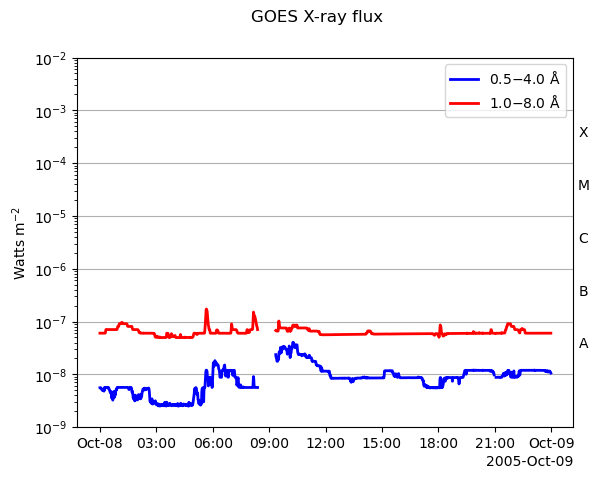

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2005-10-08 00:00:00
End Date:			2005-10-08 23:59:00
Center Date:			2005-10-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.31E+01<br>emission_measure   2.71E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2005-10-08 00:00:00     2.795147      0.000000e+00
2005-10-08 00:01:00     2.795147      0.000000e+00
2005-10-08 00:02:00     2.795147      0.000000e+00
2005-10-08 00:03:00     2.795147      0.000000e+00
2005-10-08 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2005-10-08 23:55:00     2.795147     -4.860946e+44
2005-10-08 23:56:00     2.795147      5.171975e+43
2005-10-08 23:57:00     2.795147      8.584412e+43
2005-10-08 23:58:00     2.795147      4.253105e+44
2005-10-08

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2005-10-08 00:00:00
End Date:			2005-10-08 23:59:00
Center Date:			2005-10-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.31E+01<br>emission_measure   8.56E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2005-10-08 00:00:00     2.645967      0.000000e+00
2005-10-08 00:01:00     2.645967      0.000000e+00
2005-10-08 00:02:00     2.645967      0.000000e+00
2005-10-08 00:03:00     2.645967      0.000000e+00
2005-10-08 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2005-10-08 23:55:00     2.645967     -1.535797e+45
2005-10-08 23:56:00     2.645967      1.634065e+44
2005-10-08 23:57:00     2.645967      2.712211e+44
2005-10-08 23:58:00     2.645967      1.343752e+45
2005-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.56file/s]


Cargando datos de 2006-03-25 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2006-03-25 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2006-03-25 00:00:00
End Date:			2006-03-25 23:59:00
Center Date:			2006-03-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.27E-08<br>xrsb           1.56E-07<br>xrsa_quality   5.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2006-03-25 00:00:00  8.925165e-09  4.095293e-08             0             0
2006-03-25 00:01:00  8.922694e-09  4.093336e-08             0             0
2006-03-25 00:02:00  8.921376e-09  4.249650e-08           

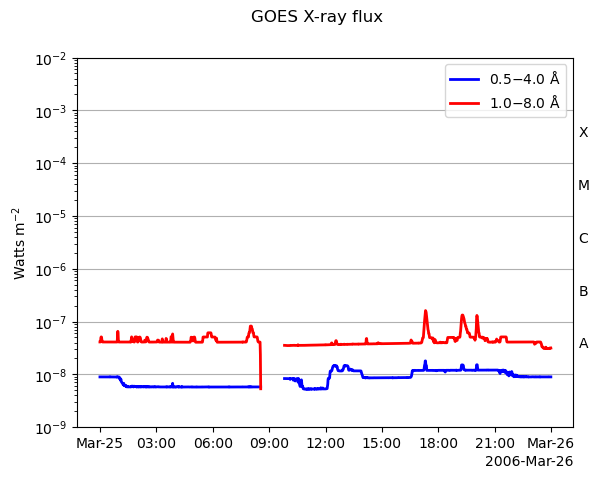

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2006-03-25 00:00:00
End Date:			2006-03-25 23:59:00
Center Date:			2006-03-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.64E+00<br>emission_measure   2.91E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2006-03-25 00:00:00     2.795147      0.000000e+00
2006-03-25 00:01:00     2.795147      0.000000e+00
2006-03-25 00:02:00     2.795147      0.000000e+00
2006-03-25 00:03:00     2.795147      0.000000e+00
2006-03-25 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2006-03-25 23:55:00     2.795147     -5.610082e+44
2006-03-25 23:56:00     2.795147      2.121674e+46
2006-03-25 23:57:00     2.795147      2.281232e+46
2006-03-25 23:58:00     2.795147      1.436663e+46
2006-03-25

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2006-03-25 00:00:00
End Date:			2006-03-25 23:59:00
Center Date:			2006-03-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.70E+00<br>emission_measure   9.20E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2006-03-25 00:00:00     2.645967      0.000000e+00
2006-03-25 00:01:00     2.645967      0.000000e+00
2006-03-25 00:02:00     2.645967      0.000000e+00
2006-03-25 00:03:00     2.645967      0.000000e+00
2006-03-25 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2006-03-25 23:55:00     2.645967     -1.772483e+45
2006-03-25 23:56:00     2.645967      6.703345e+46
2006-03-25 23:57:00     2.645967      7.207463e+46
2006-03-25 23:58:00     2.645967      4.539079e+46
2006-

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  4.69file/s]


Cargando datos de 2006-09-09 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2006-09-09 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2006-09-09 00:00:00
End Date:			2006-09-09 23:59:00
Center Date:			2006-09-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.78E-08<br>xrsb           4.95E-07<br>xrsa_quality   5.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2006-09-09 00:00:00  5.814118e-09  1.335714e-07             0             0
2006-09-09 00:01:00  5.764706e-09  1.332857e-07             0             0
2006-09-09 00:02:00  5.847059e-09  1.332857e-07           

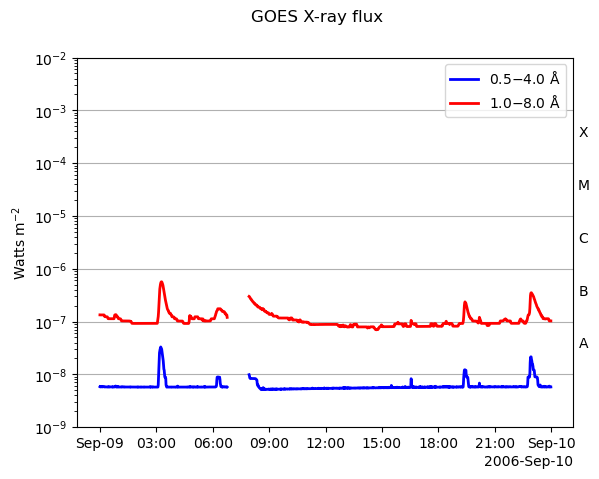

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2006-09-09 00:00:00
End Date:			2006-09-09 23:59:00
Center Date:			2006-09-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        9.62E+00<br>emission_measure   6.75E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2006-09-09 00:00:00     2.795147      0.000000e+00
2006-09-09 00:01:00     2.795147      0.000000e+00
2006-09-09 00:02:00     2.795147      0.000000e+00
2006-09-09 00:03:00     2.795147      0.000000e+00
2006-09-09 00:04:00     2.795147      0.000000e+00
...                          ...               ...
2006-09-09 23:55:00     2.795147     -2.608542e+47
2006-09-09 23:56:00     2.795147     -2.608542e+47
2006-09-09 23:57:00     2.795147     -2.215473e+47
2006-09-09 23:58:00     2.795147     -7.146692e+46
2006-09-09

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2006-09-09 00:00:00
End Date:			2006-09-09 23:59:00
Center Date:			2006-09-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.84E+00<br>emission_measure   2.13E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2006-09-09 00:00:00     2.645967      0.000000e+00
2006-09-09 00:01:00     2.645967      0.000000e+00
2006-09-09 00:02:00     2.645967      0.000000e+00
2006-09-09 00:03:00     2.645967      0.000000e+00
2006-09-09 00:04:00     2.645967      0.000000e+00
...                          ...               ...
2006-09-09 23:55:00     2.645967     -8.241585e+47
2006-09-09 23:56:00     2.645967     -8.241585e+47
2006-09-09 23:57:00     2.645967     -6.999701e+47
2006-09-09 23:58:00     2.645967     -2.257969e+47
2006-

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  5.40file/s]


Cargando datos de 2007-02-24 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2007-02-24 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2007-02-24 00:00:00
End Date:			2007-02-24 23:59:00
Center Date:			2007-02-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           5.27E-10<br>xrsb           3.45E-08<br>xrsa_quality   5.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2007-02-24 00:00:00  5.715294e-09  5.357143e-09             0             0
2007-02-24 00:01:00  5.715294e-09  5.328571e-09             0             0
2007-02-24 00:02:00  5.715294e-09  5.428571e-09           

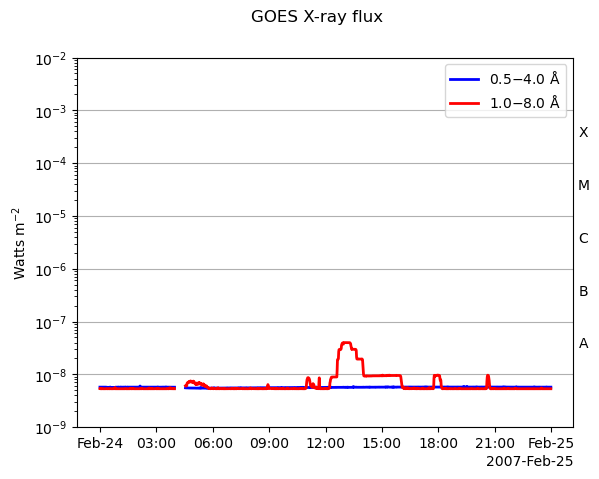

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2007-02-24 00:00:00
End Date:			2007-02-24 23:59:00
Center Date:			2007-02-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   6.27E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2007-02-24 00:00:00     2.795147               0.0
2007-02-24 00:01:00     2.795147               0.0
2007-02-24 00:02:00     2.795147               0.0
2007-02-24 00:03:00     2.795147               0.0
2007-02-24 00:04:00     2.795147               0.0
...                          ...               ...
2007-02-24 23:55:00     2.795147               0.0
2007-02-24 23:56:00     2.795147               0.0
2007-02-24 23:57:00     2.795147               0.0
2007-02-24 23:58:00     2.795147               0.0
2007-02-24

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2007-02-24 00:00:00
End Date:			2007-02-24 23:59:00
Center Date:			2007-02-24 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.98E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2007-02-24 00:00:00     2.645967               0.0
2007-02-24 00:01:00     2.645967               0.0
2007-02-24 00:02:00     2.645967               0.0
2007-02-24 00:03:00     2.645967               0.0
2007-02-24 00:04:00     2.645967               0.0
...                          ...               ...
2007-02-24 23:55:00     2.645967               0.0
2007-02-24 23:56:00     2.645967               0.0
2007-02-24 23:57:00     2.645967               0.0
2007-02-24 23:58:00     2.645967               0.0
2007-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.59file/s]


Cargando datos de 2007-08-11 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2007-08-11 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2007-08-11 00:00:00
End Date:			2007-08-11 23:59:00
Center Date:			2007-08-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.29E-08<br>xrsb           1.62E-08<br>xrsa_quality   4.00E+00<br>xrsb_quality   4.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2007-08-11 00:00:00  5.896470e-09  5.328571e-09             0             0
2007-08-11 00:01:00  5.945882e-09  5.328571e-09             0             0
2007-08-11 00:02:00  5.896470e-09  5.328571e-09           

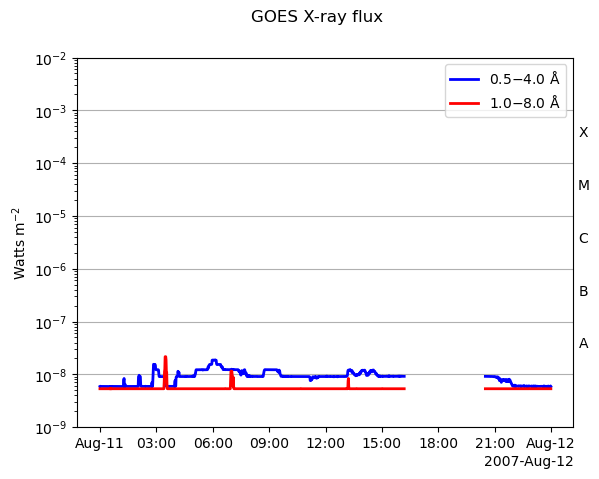

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2007-08-11 00:00:00
End Date:			2007-08-11 23:59:00
Center Date:			2007-08-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   8.13E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2007-08-11 00:00:00     2.795147               0.0
2007-08-11 00:01:00     2.795147               0.0
2007-08-11 00:02:00     2.795147               0.0
2007-08-11 00:03:00     2.795147               0.0
2007-08-11 00:04:00     2.795147               0.0
...                          ...               ...
2007-08-11 23:55:00     2.795147               0.0
2007-08-11 23:56:00     2.795147               0.0
2007-08-11 23:57:00     2.795147               0.0
2007-08-11 23:58:00     2.795147               0.0
2007-08-11

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2007-08-11 00:00:00
End Date:			2007-08-11 23:59:00
Center Date:			2007-08-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   2.57E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2007-08-11 00:00:00     2.645967               0.0
2007-08-11 00:01:00     2.645967               0.0
2007-08-11 00:02:00     2.645967               0.0
2007-08-11 00:03:00     2.645967               0.0
2007-08-11 00:04:00     2.645967               0.0
...                          ...               ...
2007-08-11 23:55:00     2.645967               0.0
2007-08-11 23:56:00     2.645967               0.0
2007-08-11 23:57:00     2.645967               0.0
2007-08-11 23:58:00     2.645967               0.0
2007-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


Cargando datos de 2008-07-12 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2008-07-12 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2008-07-12 00:00:00
End Date:			2008-07-12 23:59:00
Center Date:			2008-07-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.90E-08<br>xrsb           2.99E-10<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2008-07-12 00:00:00  6.122282e-09  5.322857e-09             0             0
2008-07-12 00:01:00  6.099388e-09  5.322857e-09             0             0
2008-07-12 00:02:00  6.122777e-09  5.322857e-09           

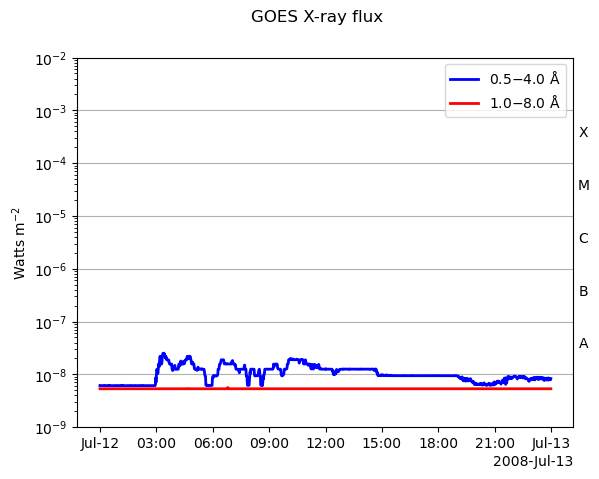

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2008-07-12 00:00:00
End Date:			2008-07-12 23:59:00
Center Date:			2008-07-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.49E+46
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2008-07-12 00:00:00     2.795147               0.0
2008-07-12 00:01:00     2.795147               0.0
2008-07-12 00:02:00     2.795147               0.0
2008-07-12 00:03:00     2.795147               0.0
2008-07-12 00:04:00     2.795147               0.0
...                          ...               ...
2008-07-12 23:55:00     2.795147               0.0
2008-07-12 23:56:00     2.795147               0.0
2008-07-12 23:57:00     2.795147               0.0
2008-07-12 23:58:00     2.795147               0.0
2008-07-12

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2008-07-12 00:00:00
End Date:			2008-07-12 23:59:00
Center Date:			2008-07-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   4.72E+46
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2008-07-12 00:00:00     2.645967               0.0
2008-07-12 00:01:00     2.645967               0.0
2008-07-12 00:02:00     2.645967               0.0
2008-07-12 00:03:00     2.645967               0.0
2008-07-12 00:04:00     2.645967               0.0
...                          ...               ...
2008-07-12 23:55:00     2.645967               0.0
2008-07-12 23:56:00     2.645967               0.0
2008-07-12 23:57:00     2.645967               0.0
2008-07-12 23:58:00     2.645967               0.0
2008-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


Cargando datos de 2008-12-27 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2008-12-27 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2008-12-27 00:00:00
End Date:			2008-12-27 23:59:00
Center Date:			2008-12-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           4.44E-10<br>xrsb           1.52E-10<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2008-12-27 00:00:00  5.800941e-09  5.322857e-09             0             0
2008-12-27 00:01:00  5.800941e-09  5.322857e-09             0             0
2008-12-27 00:02:00  5.800282e-09  5.322857e-09           

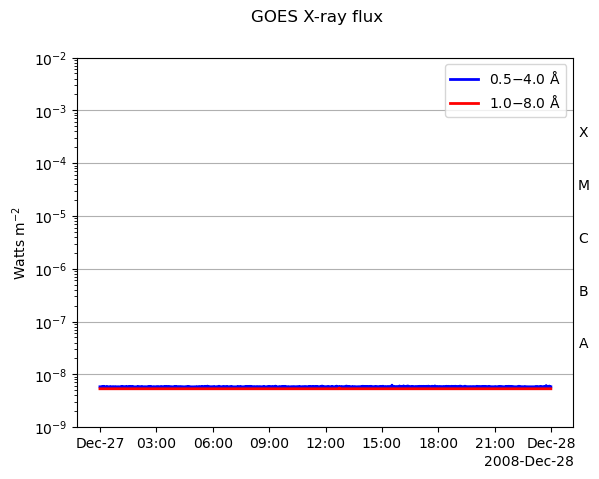

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2008-12-27 00:00:00
End Date:			2008-12-27 23:59:00
Center Date:			2008-12-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   7.63E+45
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2008-12-27 00:00:00     2.795147               0.0
2008-12-27 00:01:00     2.795147               0.0
2008-12-27 00:02:00     2.795147               0.0
2008-12-27 00:03:00     2.795147               0.0
2008-12-27 00:04:00     2.795147               0.0
...                          ...               ...
2008-12-27 23:55:00     2.795147               0.0
2008-12-27 23:56:00     2.795147               0.0
2008-12-27 23:57:00     2.795147               0.0
2008-12-27 23:58:00     2.795147               0.0
2008-12-27

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2008-12-27 00:00:00
End Date:			2008-12-27 23:59:00
Center Date:			2008-12-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   2.41E+46
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2008-12-27 00:00:00     2.645967               0.0
2008-12-27 00:01:00     2.645967               0.0
2008-12-27 00:02:00     2.645967               0.0
2008-12-27 00:03:00     2.645967               0.0
2008-12-27 00:04:00     2.645967               0.0
...                          ...               ...
2008-12-27 23:55:00     2.645967               0.0
2008-12-27 23:56:00     2.645967               0.0
2008-12-27 23:57:00     2.645967               0.0
2008-12-27 23:58:00     2.645967               0.0
2008-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.81file/s]


Cargando datos de 2009-06-13 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2009-06-13 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2009-06-13 00:00:00
End Date:			2009-06-13 23:59:00
Center Date:			2009-06-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.55E-10<br>xrsb           2.64E-10<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2009-06-13 00:00:00  6.227611e-09  5.322857e-09             0             0
2009-06-13 00:01:00  6.225964e-09  5.322857e-09             0             0
2009-06-13 00:02:00  6.250752e-09  5.322857e-09           

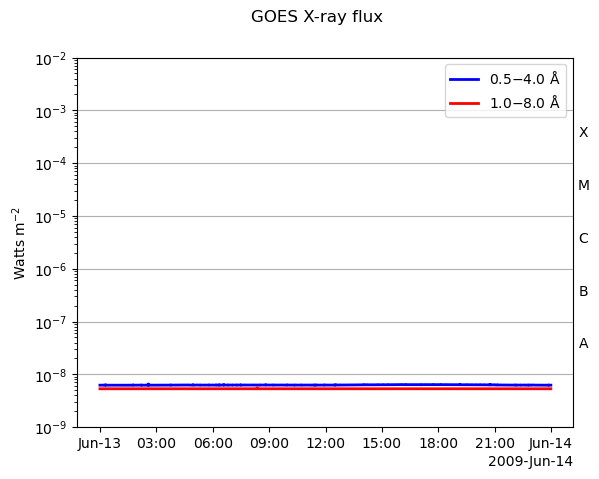

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.03file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2009-06-13 00:00:00
End Date:			2009-06-13 23:59:00
Center Date:			2009-06-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.32E+46
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2009-06-13 00:00:00     2.795147               0.0
2009-06-13 00:01:00     2.795147               0.0
2009-06-13 00:02:00     2.795147               0.0
2009-06-13 00:03:00     2.795147               0.0
2009-06-13 00:04:00     2.795147               0.0
...                          ...               ...
2009-06-13 23:55:00     2.795147               0.0
2009-06-13 23:56:00     2.795147               0.0
2009-06-13 23:57:00     2.795147               0.0
2009-06-13 23:58:00     2.795147               0.0
2009-06-13

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2009-06-13 00:00:00
End Date:			2009-06-13 23:59:00
Center Date:			2009-06-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   4.17E+46
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2009-06-13 00:00:00     2.645967               0.0
2009-06-13 00:01:00     2.645967               0.0
2009-06-13 00:02:00     2.645967               0.0
2009-06-13 00:03:00     2.645967               0.0
2009-06-13 00:04:00     2.645967               0.0
...                          ...               ...
2009-06-13 23:55:00     2.645967               0.0
2009-06-13 23:56:00     2.645967               0.0
2009-06-13 23:57:00     2.645967               0.0
2009-06-13 23:58:00     2.645967               0.0
2009-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


Cargando datos de 2009-11-28 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2009-11-28 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-10
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2009-11-28 00:00:00
End Date:			2009-11-28 23:59:00
Center Date:			2009-11-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.15E-09<br>xrsb           1.54E-08<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2009-11-28 00:00:00  5.800941e-09  5.322857e-09             0             0
2009-11-28 00:01:00  5.866494e-09  5.322857e-09             0             0
2009-11-28 00:02:00  5.801517e-09  5.322857e-09           

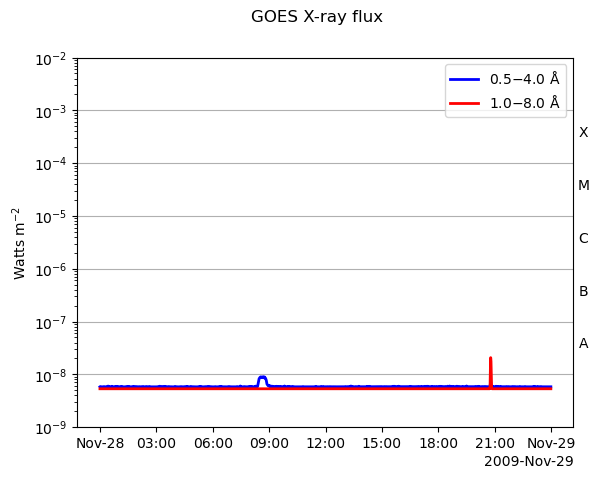

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2009-11-28 00:00:00
End Date:			2009-11-28 23:59:00
Center Date:			2009-11-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   7.68E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2009-11-28 00:00:00     2.795147               0.0
2009-11-28 00:01:00     2.795147               0.0
2009-11-28 00:02:00     2.795147               0.0
2009-11-28 00:03:00     2.795147               0.0
2009-11-28 00:04:00     2.795147               0.0
...                          ...               ...
2009-11-28 23:55:00     2.795147               0.0
2009-11-28 23:56:00     2.795147               0.0
2009-11-28 23:57:00     2.795147               0.0
2009-11-28 23:58:00     2.795147               0.0
2009-11-28

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2009-11-28 00:00:00
End Date:			2009-11-28 23:59:00
Center Date:			2009-11-28 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   2.43E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2009-11-28 00:00:00     2.645967               0.0
2009-11-28 00:01:00     2.645967               0.0
2009-11-28 00:02:00     2.645967               0.0
2009-11-28 00:03:00     2.645967               0.0
2009-11-28 00:04:00     2.645967               0.0
...                          ...               ...
2009-11-28 23:55:00     2.645967               0.0
2009-11-28 23:56:00     2.645967               0.0
2009-11-28 23:57:00     2.645967               0.0
2009-11-28 23:58:00     2.645967               0.0
2009-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.81file/s]


Cargando datos de 2010-05-15 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2010-05-15 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-14
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2010-05-15 00:00:00
End Date:			2010-05-15 23:59:00
Center Date:			2010-05-15 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           7.47E-09<br>xrsb           1.65E-08<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2010-05-15 00:00:00  1.000000e-09  3.229845e-09            16            16
2010-05-15 00:01:00  1.000000e-09  4.101665e-09            16            16
2010-05-15 00:02:00  1.000000e-09  1.000000e-09           

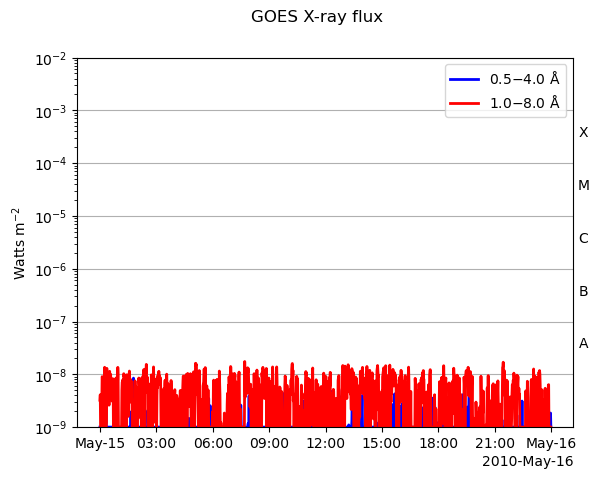

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2010-05-15 00:00:00
End Date:			2010-05-15 23:59:00
Center Date:			2010-05-15 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   7.16E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2010-05-15 00:00:00     2.797938      0.000000e+00
2010-05-15 00:01:00     2.797938      0.000000e+00
2010-05-15 00:02:00     2.797938      0.000000e+00
2010-05-15 00:03:00     2.797938      0.000000e+00
2010-05-15 00:04:00     2.797938      0.000000e+00
...                          ...               ...
2010-05-15 23:55:00     2.797938     -2.498928e+46
2010-05-15 23:56:00     2.797938     -1.203686e+47
2010-05-15 23:57:00     2.797938     -1.222762e+47
2010-05-15 23:58:00     2.797938      0.000000e+00
2010-05-15

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.18s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2010-05-15 00:00:00
End Date:			2010-05-15 23:59:00
Center Date:			2010-05-15 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   2.29E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2010-05-15 00:00:00      2.63945      0.000000e+00
2010-05-15 00:01:00      2.63945      0.000000e+00
2010-05-15 00:02:00      2.63945      0.000000e+00
2010-05-15 00:03:00      2.63945      0.000000e+00
2010-05-15 00:04:00      2.63945      0.000000e+00
...                          ...               ...
2010-05-15 23:55:00      2.63945     -7.999669e+46
2010-05-15 23:56:00      2.63945     -3.853288e+47
2010-05-15 23:57:00      2.63945     -3.914355e+47
2010-05-15 23:58:00      2.63945      0.000000e+00
2010-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.61file/s]


Cargando datos de 2010-10-30 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2010-10-30 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-14
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2010-10-30 00:00:00
End Date:			2010-10-30 23:59:00
Center Date:			2010-10-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           8.78E-08<br>xrsb           7.40E-07<br>xrsa_quality   1.00E+00<br>xrsb_quality   1.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2010-10-30 00:00:00  1.000000e-09  1.555319e-07            16            16
2010-10-30 00:01:00  1.000000e-09  1.549702e-07            16            16
2010-10-30 00:02:00  1.304109e-09  1.438377e-07           

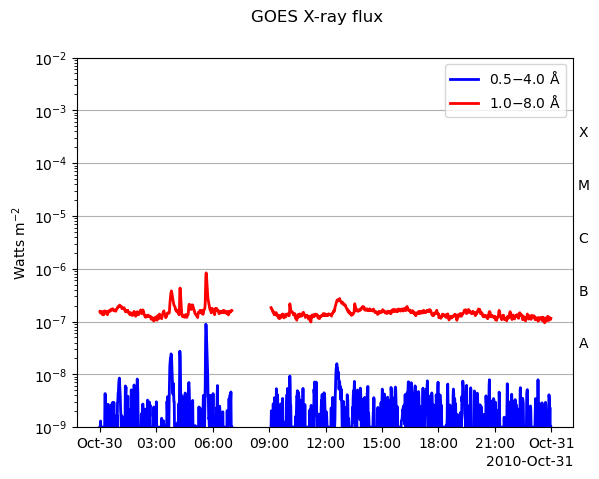

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2010-10-30 00:00:00
End Date:			2010-10-30 23:59:00
Center Date:			2010-10-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.26E+01<br>emission_measure   1.38E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2010-10-30 00:00:00     2.797938      0.000000e+00
2010-10-30 00:01:00     2.797938      0.000000e+00
2010-10-30 00:02:00     2.797938      0.000000e+00
2010-10-30 00:03:00     2.797938      0.000000e+00
2010-10-30 00:04:00     2.797938      0.000000e+00
...                          ...               ...
2010-10-30 23:55:00     2.797938     -2.394974e+47
2010-10-30 23:56:00     2.797938      1.382045e+47
2010-10-30 23:57:00     2.797938      1.659599e+47
2010-10-30 23:58:00     2.797938     -2.459834e+47
2010-10-30

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.16file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2010-10-30 00:00:00
End Date:			2010-10-30 23:59:00
Center Date:			2010-10-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.24E+01<br>emission_measure   4.46E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2010-10-30 00:00:00      2.63945      0.000000e+00
2010-10-30 00:01:00      2.63945      0.000000e+00
2010-10-30 00:02:00      2.63945      0.000000e+00
2010-10-30 00:03:00      2.63945      0.000000e+00
2010-10-30 00:04:00      2.63945      0.000000e+00
...                          ...               ...
2010-10-30 23:55:00      2.63945     -7.666887e+47
2010-10-30 23:56:00      2.63945      4.424259e+47
2010-10-30 23:57:00      2.63945      5.312776e+47
2010-10-30 23:58:00      2.63945     -7.874519e+47
2010-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.82file/s]


Cargando datos de 2011-04-16 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2011-04-16 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2011-04-16 00:00:00
End Date:			2011-04-16 23:59:00
Center Date:			2011-04-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           8.61E-07<br>xrsb           7.66E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2011-04-16 00:00:00  1.786398e-08  1.048506e-06            16            16
2011-04-16 00:01:00  1.695626e-08  1.050712e-06            16            16
2011-04-16 00:02:00  1.942073e-08  1.047022e-06           

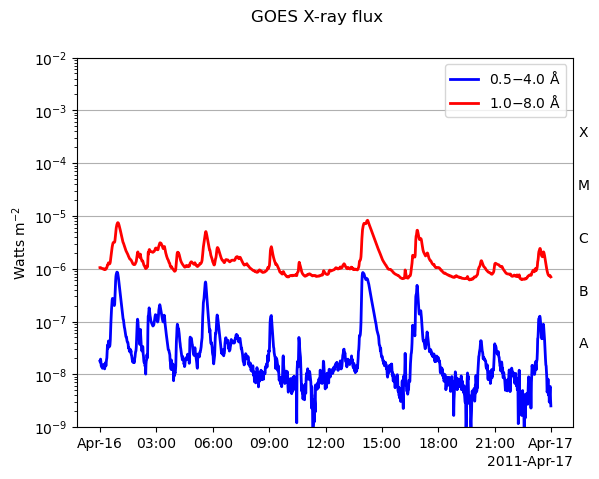

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2011-04-16 00:00:00
End Date:			2011-04-16 23:59:00
Center Date:			2011-04-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.61E+01<br>emission_measure   8.04E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2011-04-16 00:00:00     2.750396      0.000000e+00
2011-04-16 00:01:00     2.750396      0.000000e+00
2011-04-16 00:02:00     2.750396      0.000000e+00
2011-04-16 00:03:00     2.750396      0.000000e+00
2011-04-16 00:04:00     2.750396      0.000000e+00
...                          ...               ...
2011-04-16 23:55:00     2.750396     -1.357258e+48
2011-04-16 23:56:00     2.750396     -3.738805e+47
2011-04-16 23:57:00     2.750396     -2.984540e+47
2011-04-16 23:58:00     2.750396     -6.057411e+47
2011-04-16

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2011-04-16 00:00:00
End Date:			2011-04-16 23:59:00
Center Date:			2011-04-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.68E+01<br>emission_measure   2.51E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2011-04-16 00:00:00     2.605354      0.000000e+00
2011-04-16 00:01:00     2.605354      0.000000e+00
2011-04-16 00:02:00     2.605354      0.000000e+00
2011-04-16 00:03:00     2.605354      0.000000e+00
2011-04-16 00:04:00     2.605354      0.000000e+00
...                          ...               ...
2011-04-16 23:55:00     2.605354     -4.246204e+48
2011-04-16 23:56:00     2.605354     -1.169691e+48
2011-04-16 23:57:00     2.605354     -9.337178e+47
2011-04-16 23:58:00     2.605354     -1.895071e+48
2011-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.82file/s]


Cargando datos de 2011-10-01 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2011-10-01 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2011-10-01 00:00:00
End Date:			2011-10-01 23:59:00
Center Date:			2011-10-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.93E-06<br>xrsb           1.83E-05<br>xrsa_quality   6.00E+00<br>xrsb_quality   2.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2011-10-01 00:00:00  3.230151e-08  0.000001            16            16
2011-10-01 00:01:00  2.980529e-08  0.000001            16            16
2011-10-01 00:02:00  3.439985e-08  0.000001            16            1

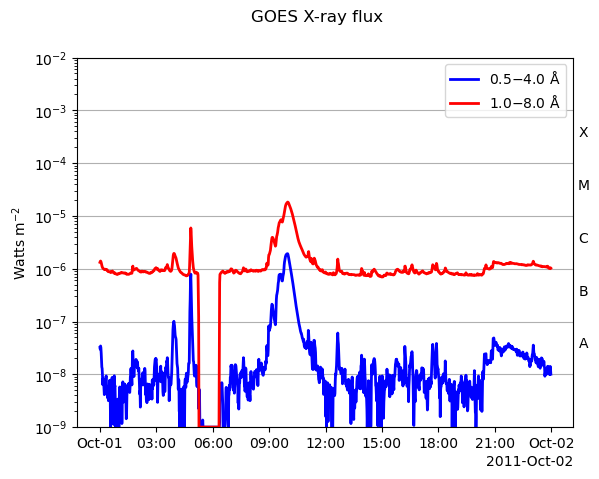

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2011-10-01 00:00:00
End Date:			2011-10-01 23:59:00
Center Date:			2011-10-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.60E+02<br>emission_measure   3.38E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2011-10-01 00:00:00     2.750396      0.000000e+00
2011-10-01 00:01:00     2.750396      0.000000e+00
2011-10-01 00:02:00     2.750396      0.000000e+00
2011-10-01 00:03:00     2.750396      0.000000e+00
2011-10-01 00:04:00     2.750396      0.000000e+00
...                          ...               ...
2011-10-01 23:55:00     2.750396     -1.706876e+48
2011-10-01 23:56:00     2.750396     -9.440900e+47
2011-10-01 23:57:00     2.750396      2.160257e+47
2011-10-01 23:58:00     2.750396      4.237251e+47
2011-10-01

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2011-10-01 00:00:00
End Date:			2011-10-01 23:59:00
Center Date:			2011-10-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.85E+02<br>emission_measure   8.54E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2011-10-01 00:00:00     2.605354      0.000000e+00
2011-10-01 00:01:00     2.605354      0.000000e+00
2011-10-01 00:02:00     2.605354      0.000000e+00
2011-10-01 00:03:00     2.605354      0.000000e+00
2011-10-01 00:04:00     2.605354      0.000000e+00
...                          ...               ...
2011-10-01 23:55:00     2.605354     -5.339989e+48
2011-10-01 23:56:00     2.605354     -2.953600e+48
2011-10-01 23:57:00     2.605354      6.758397e+47
2011-10-01 23:58:00     2.605354      1.325630e+48
2011-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.81file/s]


Cargando datos de 2012-03-17 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2012-03-17 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2012-03-17 00:00:00
End Date:			2012-03-17 23:59:00
Center Date:			2012-03-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.59E-06<br>xrsb           2.00E-05<br>xrsa_quality   6.00E+00<br>xrsb_quality   2.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2012-03-17 00:00:00  3.671920e-09  3.087522e-07            16            16
2012-03-17 00:01:00  2.854970e-09  3.063281e-07            16            16
2012-03-17 00:02:00  2.945742e-09  3.090535e-07           

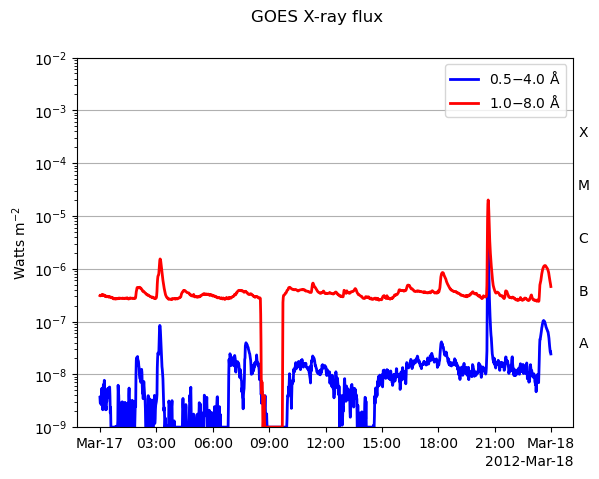

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.18s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2012-03-17 00:00:00
End Date:			2012-03-17 23:59:00
Center Date:			2012-03-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.31E+01<br>emission_measure   3.99E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2012-03-17 00:00:00     2.750396      0.000000e+00
2012-03-17 00:01:00     2.750396      0.000000e+00
2012-03-17 00:02:00     2.750396      0.000000e+00
2012-03-17 00:03:00     2.750396      0.000000e+00
2012-03-17 00:04:00     2.750396      0.000000e+00
...                          ...               ...
2012-03-17 23:55:00     2.750396     -6.936940e+48
2012-03-17 23:56:00     2.750396     -7.039776e+48
2012-03-17 23:57:00     2.750396     -6.818776e+48
2012-03-17 23:58:00     2.750396     -6.397895e+48
2012-03-17

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2012-03-17 00:00:00
End Date:			2012-03-17 23:59:00
Center Date:			2012-03-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.30E+01<br>emission_measure   1.25E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2012-03-17 00:00:00     2.605354      0.000000e+00
2012-03-17 00:01:00     2.605354      0.000000e+00
2012-03-17 00:02:00     2.605354      0.000000e+00
2012-03-17 00:03:00     2.605354      0.000000e+00
2012-03-17 00:04:00     2.605354      0.000000e+00
...                          ...               ...
2012-03-17 23:55:00     2.605354     -2.170232e+49
2012-03-17 23:56:00     2.605354     -2.202405e+49
2012-03-17 23:57:00     2.605354     -2.133265e+49
2012-03-17 23:58:00     2.605354     -2.001591e+49
2012-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


Cargando datos de 2012-09-01 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2012-09-01 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2012-09-01 00:00:00
End Date:			2012-09-01 23:59:00
Center Date:			2012-09-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.47E-07<br>xrsb           4.99E-06<br>xrsa_quality   6.00E+00<br>xrsb_quality   2.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2012-09-01 00:00:00  4.553080e-08  0.000003            16            16
2012-09-01 00:01:00  4.277614e-08  0.000003            16            16
2012-09-01 00:02:00  4.263090e-08  0.000003            16            1

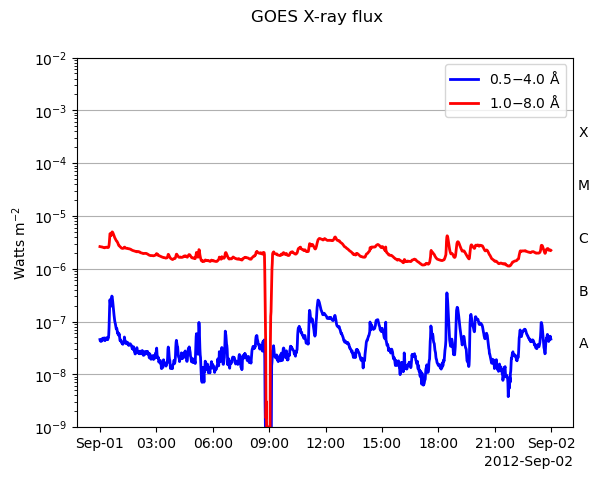

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2012-09-01 00:00:00
End Date:			2012-09-01 23:59:00
Center Date:			2012-09-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.01E+01<br>emission_measure   5.85E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2012-09-01 00:00:00     2.750396      0.000000e+00
2012-09-01 00:01:00     2.750396      0.000000e+00
2012-09-01 00:02:00     2.750396      0.000000e+00
2012-09-01 00:03:00     2.750396      0.000000e+00
2012-09-01 00:04:00     2.750396      0.000000e+00
...                          ...               ...
2012-09-01 23:55:00     2.750396     -4.038273e+48
2012-09-01 23:56:00     2.750396     -2.606709e+48
2012-09-01 23:57:00     2.750396     -3.370283e+47
2012-09-01 23:58:00     2.750396      6.456334e+47
2012-09-01

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2012-09-01 00:00:00
End Date:			2012-09-01 23:59:00
Center Date:			2012-09-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.25E+01<br>emission_measure   1.83E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2012-09-01 00:00:00     2.605354      0.000000e+00
2012-09-01 00:01:00     2.605354      0.000000e+00
2012-09-01 00:02:00     2.605354      0.000000e+00
2012-09-01 00:03:00     2.605354      0.000000e+00
2012-09-01 00:04:00     2.605354      0.000000e+00
...                          ...               ...
2012-09-01 23:55:00     2.605354     -1.263380e+49
2012-09-01 23:56:00     2.605354     -8.155131e+48
2012-09-01 23:57:00     2.605354     -1.054398e+48
2012-09-01 23:58:00     2.605354      2.019874e+48
2012-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.81file/s]


Cargando datos de 2013-02-16 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2013-02-16 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2013-02-16 00:00:00
End Date:			2013-02-16 23:59:00
Center Date:			2013-02-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.37E-08<br>xrsb           5.02E-07<br>xrsa_quality   1.00E+00<br>xrsb_quality   1.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2013-02-16 00:00:00  3.337713e-09  3.791793e-07            16            16
2013-02-16 00:01:00  2.780950e-09  3.794951e-07            16            16
2013-02-16 00:02:00  1.794511e-09  3.829429e-07           

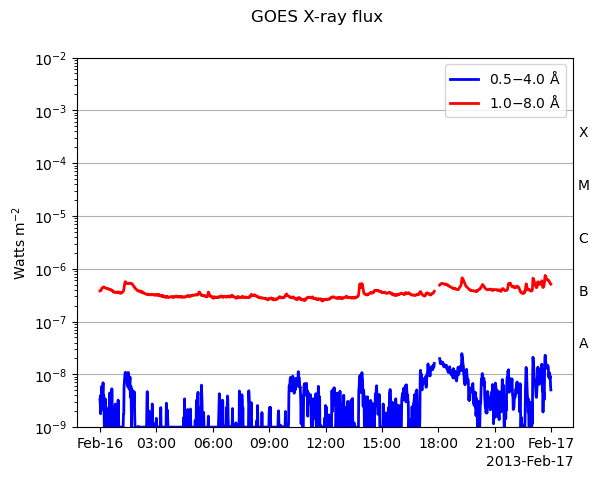

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2013-02-16 00:00:00
End Date:			2013-02-16 23:59:00
Center Date:			2013-02-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.33E+01<br>emission_measure   6.78E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2013-02-16 00:00:00     2.750396      0.000000e+00
2013-02-16 00:01:00     2.750396      0.000000e+00
2013-02-16 00:02:00     2.750396      0.000000e+00
2013-02-16 00:03:00     2.750396      0.000000e+00
2013-02-16 00:04:00     2.750396      0.000000e+00
...                          ...               ...
2013-02-16 23:55:00     2.750396     -1.419284e+48
2013-02-16 23:56:00     2.750396     -1.687182e+48
2013-02-16 23:57:00     2.750396     -1.502121e+48
2013-02-16 23:58:00     2.750396     -1.663529e+48
2013-02-16

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2013-02-16 00:00:00
End Date:			2013-02-16 23:59:00
Center Date:			2013-02-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.32E+01<br>emission_measure   2.12E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2013-02-16 00:00:00     2.605354      0.000000e+00
2013-02-16 00:01:00     2.605354      0.000000e+00
2013-02-16 00:02:00     2.605354      0.000000e+00
2013-02-16 00:03:00     2.605354      0.000000e+00
2013-02-16 00:04:00     2.605354      0.000000e+00
...                          ...               ...
2013-02-16 23:55:00     2.605354     -4.440253e+48
2013-02-16 23:56:00     2.605354     -5.278376e+48
2013-02-16 23:57:00     2.605354     -4.699408e+48
2013-02-16 23:58:00     2.605354     -5.204377e+48
2013-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.82file/s]


Cargando datos de 2013-08-03 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2013-08-03 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2013-08-03 00:00:00
End Date:			2013-08-03 23:59:00
Center Date:			2013-08-03 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           7.77E-09<br>xrsb           2.33E-07<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2013-08-03 00:00:00  1.000000e-09  3.123598e-07            16            16
2013-08-03 00:01:00  1.000000e-09  3.175163e-07            16            16
2013-08-03 00:02:00  1.000000e-09  3.159936e-07           

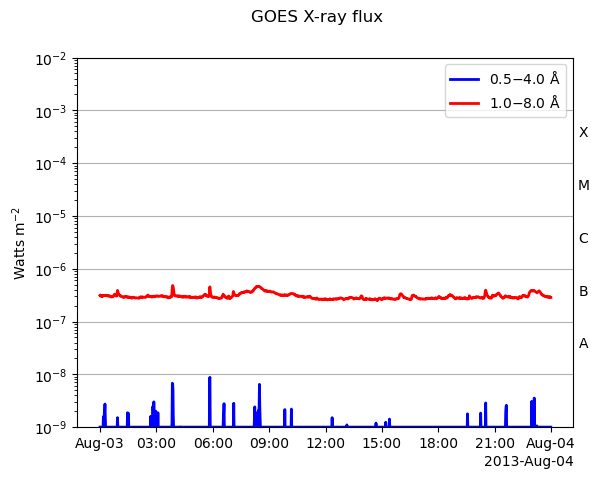

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2013-08-03 00:00:00
End Date:			2013-08-03 23:59:00
Center Date:			2013-08-03 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.36E+00<br>emission_measure   6.24E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2013-08-03 00:00:00     2.750396      0.000000e+00
2013-08-03 00:01:00     2.750396      0.000000e+00
2013-08-03 00:02:00     2.750396      0.000000e+00
2013-08-03 00:03:00     2.750396      0.000000e+00
2013-08-03 00:04:00     2.750396      0.000000e+00
...                          ...               ...
2013-08-03 23:55:00     2.750396      7.562860e+46
2013-08-03 23:56:00     2.750396      1.309543e+47
2013-08-03 23:57:00     2.750396      1.944015e+47
2013-08-03 23:58:00     2.750396     -2.266831e+47
2013-08-03

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2013-08-03 00:00:00
End Date:			2013-08-03 23:59:00
Center Date:			2013-08-03 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.48E+00<br>emission_measure   1.95E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2013-08-03 00:00:00     2.605354      0.000000e+00
2013-08-03 00:01:00     2.605354      0.000000e+00
2013-08-03 00:02:00     2.605354      0.000000e+00
2013-08-03 00:03:00     2.605354      0.000000e+00
2013-08-03 00:04:00     2.605354      0.000000e+00
...                          ...               ...
2013-08-03 23:55:00     2.605354      2.366053e+47
2013-08-03 23:56:00     2.605354      4.096925e+47
2013-08-03 23:57:00     2.605354      6.081882e+47
2013-08-03 23:58:00     2.605354     -7.091814e+47
2013-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.49file/s]


Cargando datos de 2014-01-18 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2014-01-18 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-13
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2014-01-18 00:00:00
End Date:			2014-01-18 23:59:00
Center Date:			2014-01-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.34E-06<br>xrsb           9.32E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2014-01-18 00:00:00  4.490094e-08  1.618799e-06            16            16
2014-01-18 00:01:00  2.734743e-08  1.401918e-06            16            16
2014-01-18 00:02:00  2.508901e-08  1.298446e-06           

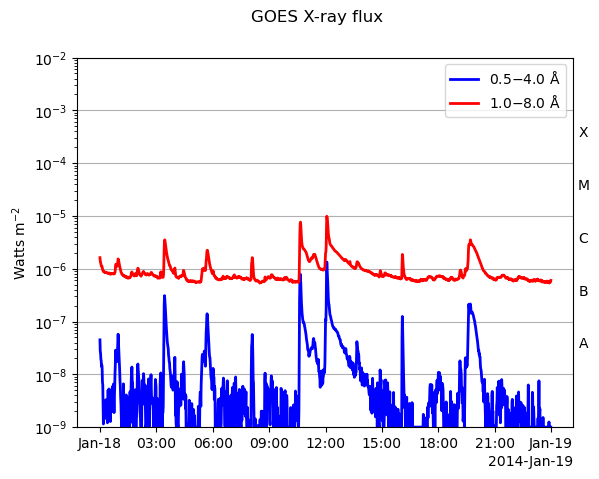

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.12s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2014-01-18 00:00:00
End Date:			2014-01-18 23:59:00
Center Date:			2014-01-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.01E+01<br>emission_measure   2.06E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2014-01-18 00:00:00     2.667883      0.000000e+00
2014-01-18 00:01:00     2.667883      0.000000e+00
2014-01-18 00:02:00     2.667883      0.000000e+00
2014-01-18 00:03:00     2.667883      0.000000e+00
2014-01-18 00:04:00     2.667883      0.000000e+00
...                          ...               ...
2014-01-18 23:55:00     2.667883      3.778303e+47
2014-01-18 23:56:00     2.667883      1.014177e+47
2014-01-18 23:57:00     2.667883     -3.818078e+47
2014-01-18 23:58:00     2.667883      4.905180e+47
2014-01-18

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2014-01-18 00:00:00
End Date:			2014-01-18 23:59:00
Center Date:			2014-01-18 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        9.42E+00<br>emission_measure   6.55E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2014-01-18 00:00:00     2.528493      0.000000e+00
2014-01-18 00:01:00     2.528493      0.000000e+00
2014-01-18 00:02:00     2.528493      0.000000e+00
2014-01-18 00:03:00     2.528493      0.000000e+00
2014-01-18 00:04:00     2.528493      0.000000e+00
...                          ...               ...
2014-01-18 23:55:00     2.528493      1.200168e+48
2014-01-18 23:56:00     2.528493      3.221507e+47
2014-01-18 23:57:00     2.528493     -1.212802e+48
2014-01-18 23:58:00     2.528493      1.558117e+48
2014-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.75file/s]


Cargando datos de 2014-07-05 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2014-07-05 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2014-07-05 00:00:00
End Date:			2014-07-05 23:59:00
Center Date:			2014-07-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.53E-07<br>xrsb           2.16E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2014-07-05 00:00:00  1.749757e-08  0.000002            16            16
2014-07-05 00:01:00  1.692397e-08  0.000002            16            16
2014-07-05 00:02:00  2.589400e-08  0.000002            16            1

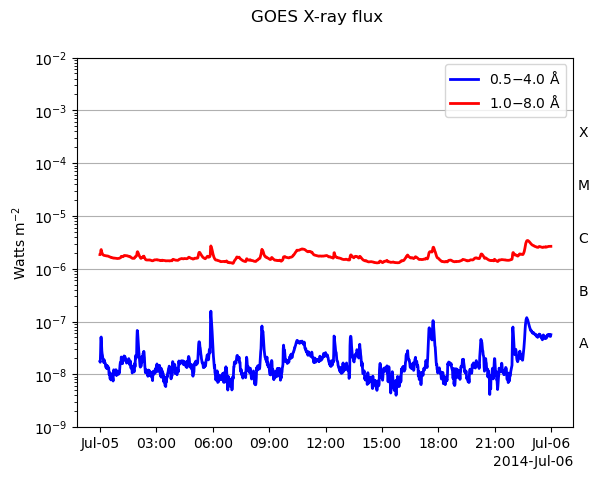

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2014-07-05 00:00:00
End Date:			2014-07-05 23:59:00
Center Date:			2014-07-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.39E+01<br>emission_measure   2.08E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2014-07-05 00:00:00     2.750396      0.000000e+00
2014-07-05 00:01:00     2.750396      0.000000e+00
2014-07-05 00:02:00     2.750396      0.000000e+00
2014-07-05 00:03:00     2.750396      0.000000e+00
2014-07-05 00:04:00     2.750396      0.000000e+00
...                          ...               ...
2014-07-05 23:55:00     2.750396      7.114170e+47
2014-07-05 23:56:00     2.750396     -5.501620e+46
2014-07-05 23:57:00     2.750396      3.654408e+46
2014-07-05 23:58:00     2.750396      7.938426e+46
2014-07-05

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2014-07-05 00:00:00
End Date:			2014-07-05 23:59:00
Center Date:			2014-07-05 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.39E+01<br>emission_measure   6.52E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2014-07-05 00:00:00     2.605354      0.000000e+00
2014-07-05 00:01:00     2.605354      0.000000e+00
2014-07-05 00:02:00     2.605354      0.000000e+00
2014-07-05 00:03:00     2.605354      0.000000e+00
2014-07-05 00:04:00     2.605354      0.000000e+00
...                          ...               ...
2014-07-05 23:55:00     2.605354      2.225679e+48
2014-07-05 23:56:00     2.605354     -1.721190e+47
2014-07-05 23:57:00     2.605354      1.143287e+47
2014-07-05 23:58:00     2.605354      2.483549e+47
2014-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  2.97file/s]


Cargando datos de 2014-12-20 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2014-12-20 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-13
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2014-12-20 00:00:00
End Date:			2014-12-20 23:59:00
Center Date:			2014-12-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           6.42E-05<br>xrsb           3.20E-04<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2014-12-20 00:00:00  2.205707e-08  0.000002            16            16
2014-12-20 00:01:00  2.653362e-08  0.000002            16            16
2014-12-20 00:02:00  2.898752e-08  0.000002            16            1

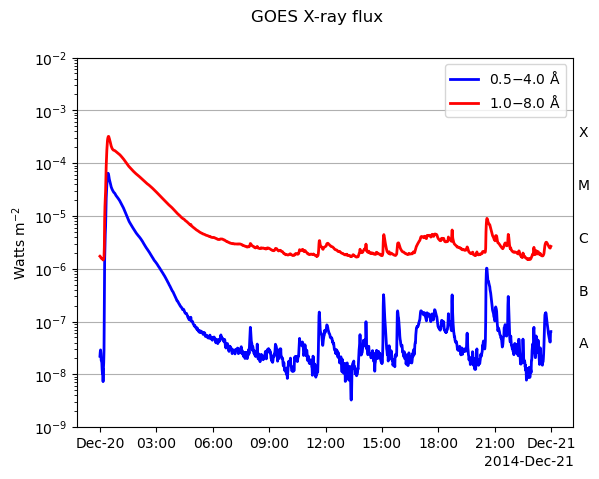

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.09file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2014-12-20 00:00:00
End Date:			2014-12-20 23:59:00
Center Date:			2014-12-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.18E+01<br>emission_measure   3.88E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2014-12-20 00:00:00     2.667883      0.000000e+00
2014-12-20 00:01:00     2.667883      0.000000e+00
2014-12-20 00:02:00     2.667883      0.000000e+00
2014-12-20 00:03:00     2.667883      0.000000e+00
2014-12-20 00:04:00     2.667883      0.000000e+00
...                          ...               ...
2014-12-20 23:55:00     2.667883     -1.120901e+49
2014-12-20 23:56:00     2.667883     -9.818539e+48
2014-12-20 23:57:00     2.667883     -7.512654e+48
2014-12-20 23:58:00     2.667883     -3.134368e+47
2014-12-20

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2014-12-20 00:00:00
End Date:			2014-12-20 23:59:00
Center Date:			2014-12-20 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.50E+01<br>emission_measure   1.23E+52
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2014-12-20 00:00:00     2.528493      0.000000e+00
2014-12-20 00:01:00     2.528493      0.000000e+00
2014-12-20 00:02:00     2.528493      0.000000e+00
2014-12-20 00:03:00     2.528493      0.000000e+00
2014-12-20 00:04:00     2.528493      0.000000e+00
...                          ...               ...
2014-12-20 23:55:00     2.528493     -3.560511e+49
2014-12-20 23:56:00     2.528493     -3.118833e+49
2014-12-20 23:57:00     2.528493     -2.386374e+49
2014-12-20 23:58:00     2.528493     -9.956235e+47
2014-

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  5.39file/s]


Cargando datos de 2015-06-06 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2015-06-06 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-13
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2015-06-06 00:00:00
End Date:			2015-06-06 23:59:00
Center Date:			2015-06-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.97E-07<br>xrsb           3.12E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2015-06-06 00:00:00  9.242857e-09  6.946671e-07            16            16
2015-06-06 00:01:00  5.751148e-09  6.940939e-07            16            16
2015-06-06 00:02:00  1.274596e-09  6.761331e-07           

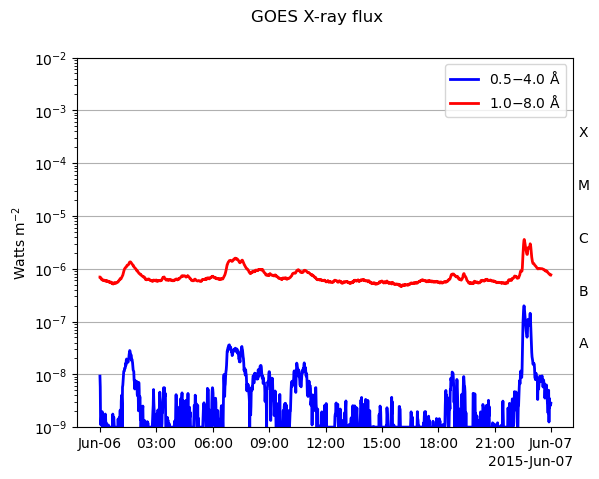

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2015-06-06 00:00:00
End Date:			2015-06-06 23:59:00
Center Date:			2015-06-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.05E+01<br>emission_measure   5.36E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2015-06-06 00:00:00     2.667883      0.000000e+00
2015-06-06 00:01:00     2.667883      0.000000e+00
2015-06-06 00:02:00     2.667883      0.000000e+00
2015-06-06 00:03:00     2.667883      0.000000e+00
2015-06-06 00:04:00     2.667883      0.000000e+00
...                          ...               ...
2015-06-06 23:55:00     2.667883     -1.483928e+48
2015-06-06 23:56:00     2.667883     -1.836130e+48
2015-06-06 23:57:00     2.667883     -1.955886e+48
2015-06-06 23:58:00     2.667883     -1.190501e+48
2015-06-06

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.16file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2015-06-06 00:00:00
End Date:			2015-06-06 23:59:00
Center Date:			2015-06-06 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        9.79E+00<br>emission_measure   1.73E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2015-06-06 00:00:00     2.528493      0.000000e+00
2015-06-06 00:01:00     2.528493      0.000000e+00
2015-06-06 00:02:00     2.528493      0.000000e+00
2015-06-06 00:03:00     2.528493      0.000000e+00
2015-06-06 00:04:00     2.528493      0.000000e+00
...                          ...               ...
2015-06-06 23:55:00     2.528493     -4.713658e+48
2015-06-06 23:56:00     2.528493     -5.832419e+48
2015-06-06 23:57:00     2.528493     -6.212818e+48
2015-06-06 23:58:00     2.528493     -3.781595e+48
2015-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.64file/s]


Cargando datos de 2015-11-21 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2015-11-21 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-13
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2015-11-21 00:00:00
End Date:			2015-11-21 23:59:00
Center Date:			2015-11-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.50E-07<br>xrsb           4.90E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2015-11-21 00:00:00  1.000000e-09  3.865245e-07            16            16
2015-11-21 00:01:00  1.000000e-09  4.043898e-07            16            16
2015-11-21 00:02:00  1.000000e-09  4.020014e-07           

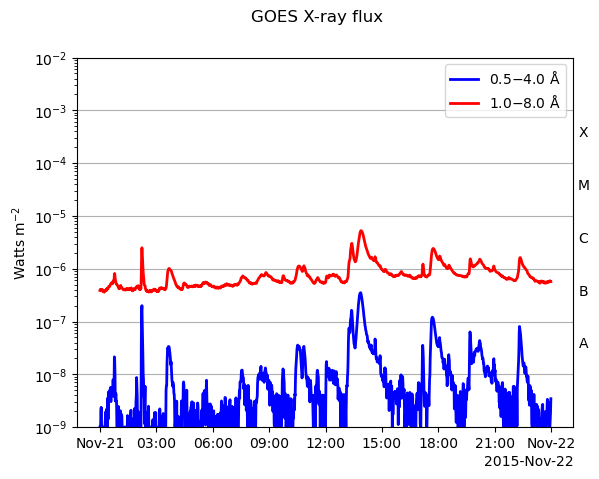

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2015-11-21 00:00:00
End Date:			2015-11-21 23:59:00
Center Date:			2015-11-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.42E+01<br>emission_measure   8.69E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2015-11-21 00:00:00     2.667883      0.000000e+00
2015-11-21 00:01:00     2.667883      0.000000e+00
2015-11-21 00:02:00     2.667883      0.000000e+00
2015-11-21 00:03:00     2.667883      0.000000e+00
2015-11-21 00:04:00     2.667883      0.000000e+00
...                          ...               ...
2015-11-21 23:55:00     2.667883      8.086915e+47
2015-11-21 23:56:00     2.667883      1.324177e+48
2015-11-21 23:57:00     2.667883      1.073838e+48
2015-11-21 23:58:00     2.667883     -1.575387e+47
2015-11-21

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.15file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2015-11-21 00:00:00
End Date:			2015-11-21 23:59:00
Center Date:			2015-11-21 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.43E+01<br>emission_measure   2.76E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2015-11-21 00:00:00     2.528493      0.000000e+00
2015-11-21 00:01:00     2.528493      0.000000e+00
2015-11-21 00:02:00     2.528493      0.000000e+00
2015-11-21 00:03:00     2.528493      0.000000e+00
2015-11-21 00:04:00     2.528493      0.000000e+00
...                          ...               ...
2015-11-21 23:55:00     2.528493      2.568787e+48
2015-11-21 23:56:00     2.528493      4.206212e+48
2015-11-21 23:57:00     2.528493      3.411018e+48
2015-11-21 23:58:00     2.528493     -5.004176e+47
2015-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  2.66file/s]


Cargando datos de 2016-05-07 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2016-05-07 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-13
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2016-05-07 00:00:00
End Date:			2016-05-07 23:59:00
Center Date:			2016-05-07 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.80E-07<br>xrsb           2.90E-06<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2016-05-07 00:00:00  3.813593e-09  4.671202e-07            16            16
2016-05-07 00:01:00  1.000000e-09  4.605104e-07            16            16
2016-05-07 00:02:00  2.585739e-09  4.456450e-07           

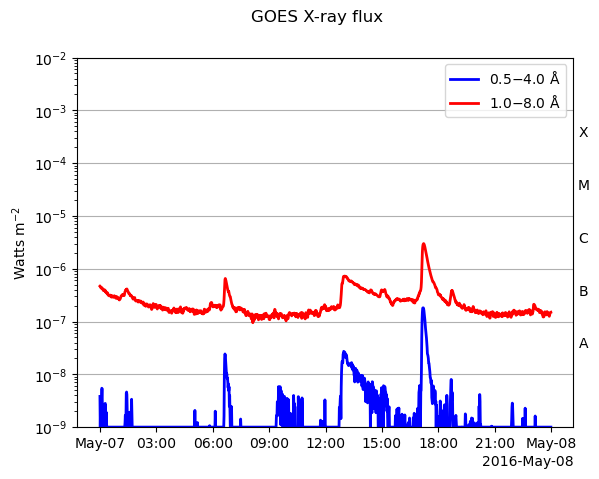

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.19file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2016-05-07 00:00:00
End Date:			2016-05-07 23:59:00
Center Date:			2016-05-07 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.34E+00<br>emission_measure   3.45E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2016-05-07 00:00:00     2.667883      0.000000e+00
2016-05-07 00:01:00     2.667883      0.000000e+00
2016-05-07 00:02:00     2.667883      0.000000e+00
2016-05-07 00:03:00     2.667883      0.000000e+00
2016-05-07 00:04:00     2.667883      0.000000e+00
...                          ...               ...
2016-05-07 23:55:00     2.667883     -1.325723e+46
2016-05-07 23:56:00     2.667883      2.211750e+47
2016-05-07 23:57:00     2.667883      4.308602e+47
2016-05-07 23:58:00     2.667883      5.031126e+47
2016-05-07

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]Exception ignored in: <function BaseEventLoop.__del__ at 0x7f35bee77420>
Traceback (most recent call last):
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/base_events.py", line 766, in __del__
    self.close()
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 73, in close
    self.remove_signal_handler(sig)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/asyncio/unix_events.py", line 162, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter
Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.17s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: Runtim

se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2016-05-07 00:00:00
End Date:			2016-05-07 23:59:00
Center Date:			2016-05-07 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.43E+00<br>emission_measure   1.10E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2016-05-07 00:00:00     2.528493      0.000000e+00
2016-05-07 00:01:00     2.528493      0.000000e+00
2016-05-07 00:02:00     2.528493      0.000000e+00
2016-05-07 00:03:00     2.528493      0.000000e+00
2016-05-07 00:04:00     2.528493      0.000000e+00
...                          ...               ...
2016-05-07 23:55:00     2.528493     -4.211123e+46
2016-05-07 23:56:00     2.528493      7.025565e+47
2016-05-07 23:57:00     2.528493      1.368616e+48
2016-05-07 23:58:00     2.528493      1.598124e+48
2016-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.59file/s]


Cargando datos de 2016-10-22 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2016-10-22 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-13
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2016-10-22 00:00:00
End Date:			2016-10-22 23:59:00
Center Date:			2016-10-22 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           6.76E-09<br>xrsb           1.78E-07<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2016-10-22 00:00:00  1.000000e-09  7.439557e-08            16            16
2016-10-22 00:01:00  1.000000e-09  5.949193e-08            16            16
2016-10-22 00:02:00  1.000000e-09  5.956199e-08           

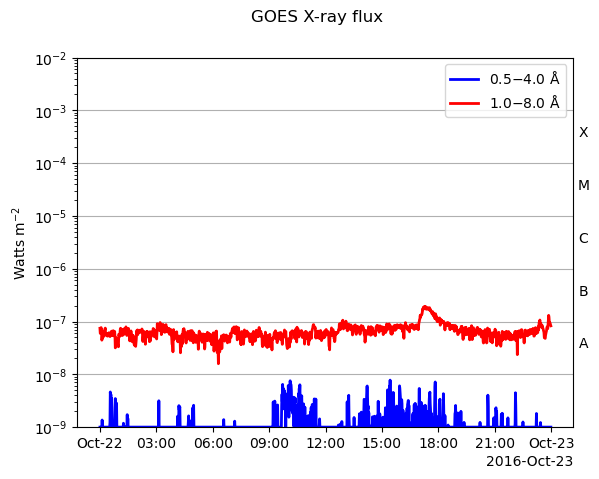

2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2016-10-22 00:00:00
End Date:			2016-10-22 23:59:00
Center Date:			2016-10-22 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.08E+00<br>emission_measure   3.27E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2016-10-22 00:00:00     2.667883      0.000000e+00
2016-10-22 00:01:00     2.667883      0.000000e+00
2016-10-22 00:02:00     2.667883      0.000000e+00
2016-10-22 00:03:00     2.667883      0.000000e+00
2016-10-22 00:04:00     2.667883      0.000000e+00
...                          ...               ...
2016-10-22 23:55:00     2.667883      1.259439e+47
2016-10-22 23:56:00     2.667883     -5.044383e+47
2016-10-22 23:57:00     2.667883     -1.471554e+48
2016-10-22 23:58:00     2.667883     -1.239552e+48
2016-10-22

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2016-10-22 00:00:00
End Date:			2016-10-22 23:59:00
Center Date:			2016-10-22 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.27E+00<br>emission_measure   1.04E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2016-10-22 00:00:00     2.528493      0.000000e+00
2016-10-22 00:01:00     2.528493      0.000000e+00
2016-10-22 00:02:00     2.528493      0.000000e+00
2016-10-22 00:03:00     2.528493      0.000000e+00
2016-10-22 00:04:00     2.528493      0.000000e+00
...                          ...               ...
2016-10-22 23:55:00     2.528493      4.000575e+47
2016-10-22 23:56:00     2.528493     -1.602335e+48
2016-10-22 23:57:00     2.528493     -4.674352e+48
2016-10-22 23:58:00     2.528493     -3.937405e+48
2016-

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  5.40file/s]


Cargando datos de 2017-04-08 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2017-04-08 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2017-04-08 00:00:00
End Date:			2017-04-08 23:59:00
Center Date:			2017-04-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.17E-07<br>xrsb           1.96E-06<br>xrsa_quality   2.10E+01<br>xrsb_quality   2.10E+01
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2017-04-08 00:00:00  1.323863e-09  1.125496e-07             4             0
2017-04-08 00:01:00  1.709019e-09  1.130889e-07             4             0
2017-04-08 00:02:00  2.021980e-09  1.119325e-07           

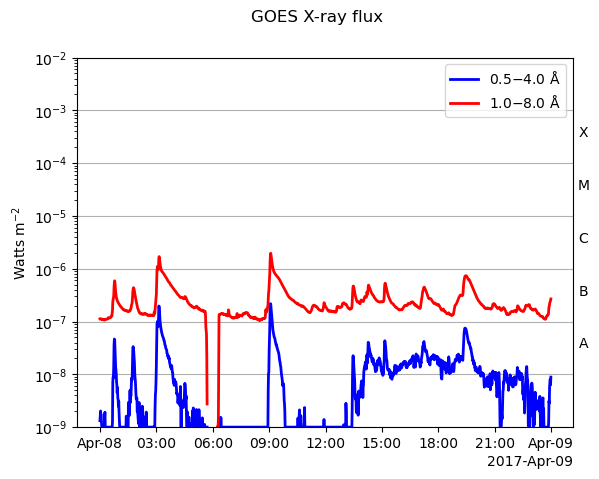

2025-09-04 14:15:34 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:15:36 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2017-04-08 00:00:00
End Date:			2017-04-08 23:59:00
Center Date:			2017-04-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.31E+01<br>emission_measure   2.02E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2017-04-08 00:00:00     2.811526      0.000000e+00
2017-04-08 00:01:00     2.811526      0.000000e+00
2017-04-08 00:02:00     2.811526      0.000000e+00
2017-04-08 00:03:00     2.811526      0.000000e+00
2017-04-08 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2017-04-08 23:55:00     7.878403      6.390585e+46
2017-04-08 23:56:00     8.123604      7.171311e+46
2017-04-08 23:57:00     9.293427      4.773375e+46
2017-04-08 23:58:00     7.338188      5.633079e+46
2017-04-08

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.23file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2017-04-08 00:00:00
End Date:			2017-04-08 23:59:00
Center Date:			2017-04-08 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.30E+01<br>emission_measure   6.63E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2017-04-08 00:00:00     2.637235      0.000000e+00
2017-04-08 00:01:00     2.637235      0.000000e+00
2017-04-08 00:02:00     2.637235      0.000000e+00
2017-04-08 00:03:00     2.637235      0.000000e+00
2017-04-08 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2017-04-08 23:55:00     6.951653      2.063043e+47
2017-04-08 23:56:00     7.176424      2.279846e+47
2017-04-08 23:57:00     8.261855      1.414533e+47
2017-04-08 23:58:00     6.459288      1.881752e+47
2017-

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  5.44file/s]


Cargando datos de 2017-09-23 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2017-09-23 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2017-09-23 00:00:00
End Date:			2017-09-23 23:59:00
Center Date:			2017-09-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.93E-08<br>xrsb           3.58E-07<br>xrsa_quality   2.00E+01<br>xrsb_quality   1.60E+01
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2017-09-23 00:00:00  4.802880e-09  1.226338e-07             4             0
2017-09-23 00:01:00  4.278338e-09  1.193290e-07             4             0
2017-09-23 00:02:00  3.791535e-09  1.202227e-07           

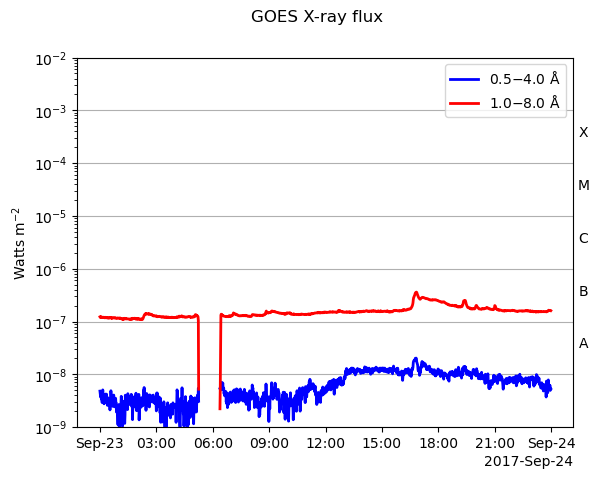

2025-09-04 14:15:52 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:15:53 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2017-09-23 00:00:00
End Date:			2017-09-23 23:59:00
Center Date:			2017-09-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.17E+00<br>emission_measure   5.57E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2017-09-23 00:00:00     2.811526      0.000000e+00
2017-09-23 00:01:00     2.811526      0.000000e+00
2017-09-23 00:02:00     2.811526      0.000000e+00
2017-09-23 00:03:00     2.811526      0.000000e+00
2017-09-23 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2017-09-23 23:55:00     2.811526      1.263052e+47
2017-09-23 23:56:00     2.811526      4.945745e+46
2017-09-23 23:57:00     2.811526     -2.646187e+46
2017-09-23 23:58:00     2.811526      1.381980e+46
2017-09-23

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2017-09-23 00:00:00
End Date:			2017-09-23 23:59:00
Center Date:			2017-09-23 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        5.33E+00<br>emission_measure   1.83E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2017-09-23 00:00:00     2.637235      0.000000e+00
2017-09-23 00:01:00     2.637235      0.000000e+00
2017-09-23 00:02:00     2.637235      0.000000e+00
2017-09-23 00:03:00     2.637235      0.000000e+00
2017-09-23 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2017-09-23 23:55:00     2.637235      4.145977e+47
2017-09-23 23:56:00     2.637235      1.623443e+47
2017-09-23 23:57:00     2.637235     -8.686122e+46
2017-09-23 23:58:00     2.637235      4.536357e+46
2017-

/tmp/ipykernel_713106/4282585637.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_anticipation_time = pd.concat([all_anticipation_time, results["anticipation_time"]])


Data found according to the date(2018-03-10 00:00:00): Results from 1 Provider:

3 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument  Physobs   Source Provider Resolution SatelliteNumber filename_res
----------------------- ----------------------- ---------- ---------- ------ -------- ---------- --------------- ------------
2018-03-10 00:00:00.000 2018-03-10 23:59:59.999       GOES irradiance   GOES     NOAA      avg1m              16           --
2018-03-10 00:00:00.000 2018-03-10 23:59:59.999       GOES irradiance   GOES     NOAA      avg1m              14         xrsf
2018-03-10 00:00:00.000 2018-03-10 23:59:59.999       GOES irradiance   GOES     NOAA      avg1m              15         xrsf




Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  5.43file/s]


Cargando datos de 2018-03-10 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2018-03-10 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2018-03-10 00:00:00
End Date:			2018-03-10 23:59:00
Center Date:			2018-03-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           7.58E-09<br>xrsb           1.20E-08<br>xrsa_quality   4.00E+00<br>xrsb_quality   4.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2018-03-10 00:00:00  3.659864e-09  5.079360e-09             0             0
2018-03-10 00:01:00  2.240566e-09  5.916183e-09             0             0
2018-03-10 00:02:00  2.975337e-09  6.311327e-09           

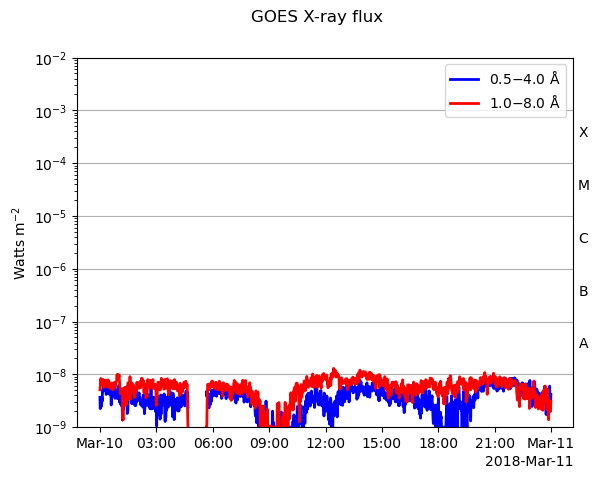

2025-09-04 14:16:06 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:16:07 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2018-03-10 00:00:00
End Date:			2018-03-10 23:59:00
Center Date:			2018-03-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   2.45E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2018-03-10 00:00:00     2.811526      0.000000e+00
2018-03-10 00:01:00     2.811526      0.000000e+00
2018-03-10 00:02:00     2.811526      0.000000e+00
2018-03-10 00:03:00     2.811526      0.000000e+00
2018-03-10 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2018-03-10 23:55:00     2.811526     -1.535270e+46
2018-03-10 23:56:00     2.811526     -2.075527e+46
2018-03-10 23:57:00     2.811526      1.972464e+46
2018-03-10 23:58:00     2.811526     -1.799017e+46
2018-03-10

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.04file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2018-03-10 00:00:00
End Date:			2018-03-10 23:59:00
Center Date:			2018-03-10 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   8.05E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2018-03-10 00:00:00     2.637235      0.000000e+00
2018-03-10 00:01:00     2.637235      0.000000e+00
2018-03-10 00:02:00     2.637235      0.000000e+00
2018-03-10 00:03:00     2.637235      0.000000e+00
2018-03-10 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2018-03-10 23:55:00     2.637235     -5.039534e+46
2018-03-10 23:56:00     2.637235     -6.812927e+46
2018-03-10 23:57:00     2.637235      6.474624e+46
2018-03-10 23:58:00     2.637235     -5.905283e+46
2018-

Files Downloaded: 100%|██████████| 4/4 [00:00<00:00,  7.12file/s]


Cargando datos de 2018-08-25 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2018-08-25 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2018-08-25 00:00:00
End Date:			2018-08-25 23:59:00
Center Date:			2018-08-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           5.56E-08<br>xrsb           6.11E-07<br>xrsa_quality   4.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2018-08-25 00:00:00  5.686455e-09  4.143545e-08             4             0
2018-08-25 00:01:00  5.227563e-09  4.005020e-08             4             0
2018-08-25 00:02:00  4.963703e-09  4.298902e-08           

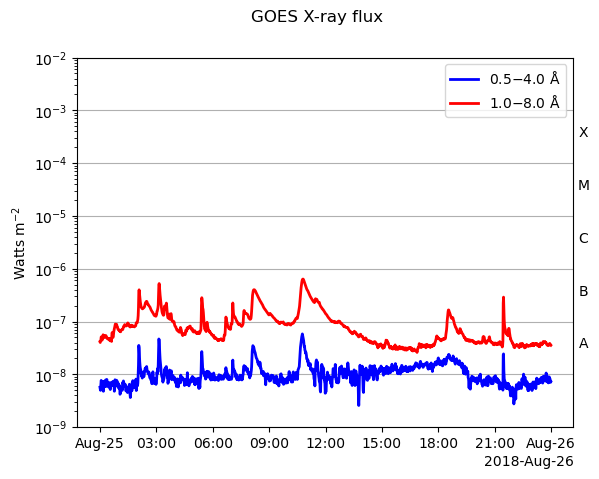

2025-09-04 14:16:23 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:16:24 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2018-08-25 00:00:00
End Date:			2018-08-25 23:59:00
Center Date:			2018-08-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.74E+01<br>emission_measure   8.25E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2018-08-25 00:00:00     2.811526      0.000000e+00
2018-08-25 00:01:00     2.811526      0.000000e+00
2018-08-25 00:02:00     2.811526      0.000000e+00
2018-08-25 00:03:00     2.811526      0.000000e+00
2018-08-25 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2018-08-25 23:55:00     2.811526      2.821047e+46
2018-08-25 23:56:00     2.811526      1.701195e+46
2018-08-25 23:57:00     2.811526      4.828328e+46
2018-08-25 23:58:00     2.811526     -1.166237e+45
2018-08-25

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.38s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2018-08-25 00:00:00
End Date:			2018-08-25 23:59:00
Center Date:			2018-08-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.86E+01<br>emission_measure   2.71E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2018-08-25 00:00:00     2.637235      0.000000e+00
2018-08-25 00:01:00     2.637235      0.000000e+00
2018-08-25 00:02:00     2.637235      0.000000e+00
2018-08-25 00:03:00     2.637235      0.000000e+00
2018-08-25 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2018-08-25 23:55:00     2.637235      9.260102e+46
2018-08-25 23:56:00     2.637235      5.584181e+46
2018-08-25 23:57:00     2.637235      1.584901e+47
2018-08-25 23:58:00     2.637235     -3.828179e+45
2018-

Files Downloaded: 100%|██████████| 4/4 [00:00<00:00,  7.17file/s]


Cargando datos de 2019-02-09 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2019-02-09 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2019-02-09 00:00:00
End Date:			2019-02-09 23:59:00
Center Date:			2019-02-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.34E-08<br>xrsb           5.92E-09<br>xrsa_quality   4.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2019-02-09 00:00:00  6.970683e-09  3.159197e-09             4             4
2019-02-09 00:01:00  6.749205e-09  2.301397e-09             4             4
2019-02-09 00:02:00  6.390424e-09  2.740821e-09           

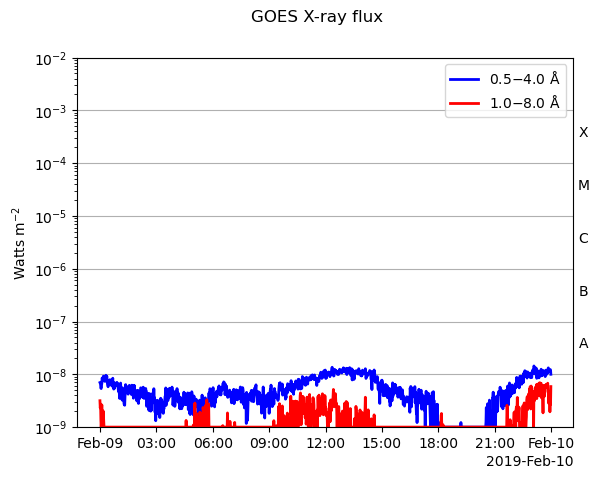

2025-09-04 14:16:40 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.15file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:16:41 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2019-02-09 00:00:00
End Date:			2019-02-09 23:59:00
Center Date:			2019-02-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.78E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2019-02-09 00:00:00     2.811526      0.000000e+00
2019-02-09 00:01:00     2.811526      0.000000e+00
2019-02-09 00:02:00     2.811526      0.000000e+00
2019-02-09 00:03:00     2.811526      0.000000e+00
2019-02-09 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2019-02-09 23:55:00     2.811526     -1.862949e+45
2019-02-09 23:56:00     2.811526     -6.081176e+46
2019-02-09 23:57:00     2.811526      1.568713e+46
2019-02-09 23:58:00     2.811526     -3.173927e+46
2019-02-09

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.98s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2019-02-09 00:00:00
End Date:			2019-02-09 23:59:00
Center Date:			2019-02-09 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   5.83E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2019-02-09 00:00:00     2.637235      0.000000e+00
2019-02-09 00:01:00     2.637235      0.000000e+00
2019-02-09 00:02:00     2.637235      0.000000e+00
2019-02-09 00:03:00     2.637235      0.000000e+00
2019-02-09 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2019-02-09 23:55:00     2.637235     -6.115139e+45
2019-02-09 23:56:00     2.637235     -1.996149e+47
2019-02-09 23:57:00     2.637235      5.149308e+46
2019-02-09 23:58:00     2.637235     -1.041843e+47
2019-

Files Downloaded: 100%|██████████| 4/4 [00:00<00:00,  5.87file/s]


Cargando datos de 2019-07-27 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2019-07-27 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2019-07-27 00:00:00
End Date:			2019-07-27 23:59:00
Center Date:			2019-07-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           7.77E-09<br>xrsb           8.19E-09<br>xrsa_quality   4.00E+00<br>xrsb_quality   4.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2019-07-27 00:00:00  2.795764e-09  5.149797e-09             4             4
2019-07-27 00:01:00  3.723627e-09  4.330611e-09             0             4
2019-07-27 00:02:00  4.683676e-09  4.100330e-09           

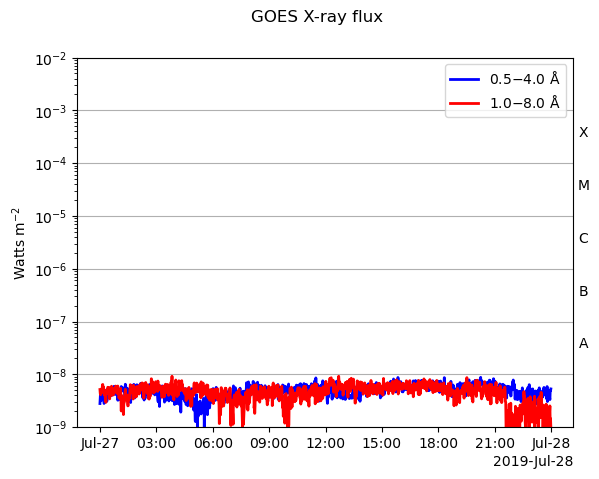

2025-09-04 14:16:56 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:16:57 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2019-07-27 00:00:00
End Date:			2019-07-27 23:59:00
Center Date:			2019-07-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   2.22E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2019-07-27 00:00:00     2.811526      0.000000e+00
2019-07-27 00:01:00     2.811526      0.000000e+00
2019-07-27 00:02:00     2.811526      0.000000e+00
2019-07-27 00:03:00     2.811526      0.000000e+00
2019-07-27 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2019-07-27 23:55:00     2.811526      2.144969e+46
2019-07-27 23:56:00     2.811526      2.536834e+45
2019-07-27 23:57:00     2.811526      2.202614e+45
2019-07-27 23:58:00     2.811526      1.003921e+46
2019-07-27

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2019-07-27 00:00:00
End Date:			2019-07-27 23:59:00
Center Date:			2019-07-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   7.28E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2019-07-27 00:00:00     2.637235      0.000000e+00
2019-07-27 00:01:00     2.637235      0.000000e+00
2019-07-27 00:02:00     2.637235      0.000000e+00
2019-07-27 00:03:00     2.637235      0.000000e+00
2019-07-27 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2019-07-27 23:55:00     2.637235      7.040873e+46
2019-07-27 23:56:00     2.637235      8.327170e+45
2019-07-27 23:57:00     2.637235      7.230092e+45
2019-07-27 23:58:00     2.637235      3.295377e+46
2019-

Files Downloaded: 100%|██████████| 4/4 [00:00<00:00,  6.47file/s]


Cargando datos de 2020-01-11 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2020-01-11 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2020-01-11 00:00:00
End Date:			2020-01-11 23:59:00
Center Date:			2020-01-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           5.62E-09<br>xrsb           2.36E-08<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2020-01-11 00:00:00  3.818388e-09  1.584618e-08             4             4
2020-01-11 00:01:00  4.643588e-09  1.413059e-08             4             4
2020-01-11 00:02:00  5.643764e-09  1.430632e-08           

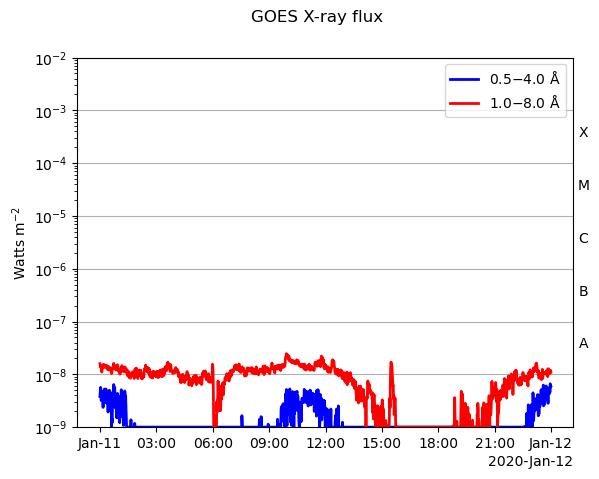

2025-09-04 14:17:11 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:17:12 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2020-01-11 00:00:00
End Date:			2020-01-11 23:59:00
Center Date:			2020-01-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   6.54E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2020-01-11 00:00:00     2.811526      0.000000e+00
2020-01-11 00:01:00     2.811526      0.000000e+00
2020-01-11 00:02:00     2.811526      0.000000e+00
2020-01-11 00:03:00     2.811526      0.000000e+00
2020-01-11 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2020-01-11 23:55:00     2.811526      2.571750e+45
2020-01-11 23:56:00     2.811526     -3.394813e+46
2020-01-11 23:57:00     2.811526     -6.657127e+45
2020-01-11 23:58:00     2.811526      7.673650e+45
2020-01-11

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.76s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2020-01-11 00:00:00
End Date:			2020-01-11 23:59:00
Center Date:			2020-01-11 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   2.15E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2020-01-11 00:00:00     2.637235      0.000000e+00
2020-01-11 00:01:00     2.637235      0.000000e+00
2020-01-11 00:02:00     2.637235      0.000000e+00
2020-01-11 00:03:00     2.637235      0.000000e+00
2020-01-11 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2020-01-11 23:55:00     2.637235      8.441784e+45
2020-01-11 23:56:00     2.637235     -1.114349e+47
2020-01-11 23:57:00     2.637235     -2.185205e+46
2020-01-11 23:58:00     2.637235      2.518880e+46
2020-

/tmp/ipykernel_713106/4282585637.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_anticipation_time = pd.concat([all_anticipation_time, results["anticipation_time"]])


Data found according to the date(2020-06-27 00:00:00): Results from 1 Provider:

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument  Physobs   Source Provider Resolution SatelliteNumber
----------------------- ----------------------- ---------- ---------- ------ -------- ---------- ---------------
2020-06-27 00:00:00.000 2020-06-27 23:59:59.999       GOES irradiance   GOES     NOAA      avg1m              16
2020-06-27 00:00:00.000 2020-06-27 23:59:59.999       GOES irradiance   GOES     NOAA      avg1m              17




Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.54file/s]


Cargando datos de 2020-06-27 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2020-06-27 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2020-06-27 00:00:00
End Date:			2020-06-27 23:59:00
Center Date:			2020-06-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           9.82E-09<br>xrsb           1.61E-08<br>xrsa_quality   4.00E+00<br>xrsb_quality   4.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2020-06-27 00:00:00  8.288866e-09  6.242869e-09             0             0
2020-06-27 00:01:00  7.494636e-09  5.639321e-09             0             0
2020-06-27 00:02:00  7.498209e-09  5.462866e-09           

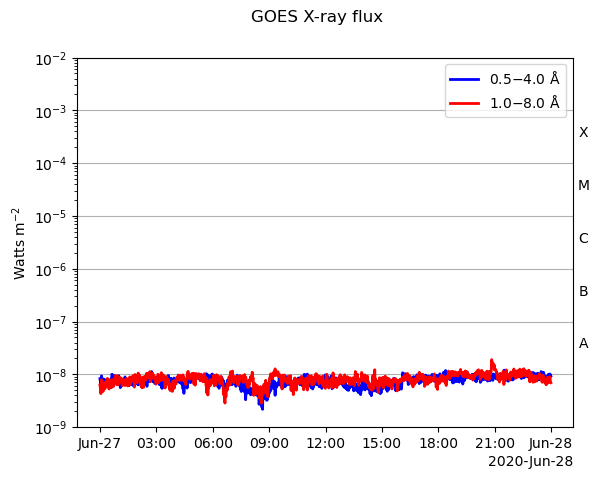

2025-09-04 14:17:23 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:17:24 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2020-06-27 00:00:00
End Date:			2020-06-27 23:59:00
Center Date:			2020-06-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   3.41E+47
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2020-06-27 00:00:00     2.811526      0.000000e+00
2020-06-27 00:01:00     2.811526      0.000000e+00
2020-06-27 00:02:00     2.811526      0.000000e+00
2020-06-27 00:03:00     2.811526      0.000000e+00
2020-06-27 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2020-06-27 23:55:00     2.811526     -1.801777e+46
2020-06-27 23:56:00     2.811526      4.287017e+46
2020-06-27 23:57:00     2.811526     -1.552712e+46
2020-06-27 23:58:00     2.811526     -3.712508e+46
2020-06-27

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2020-06-27 00:00:00
End Date:			2020-06-27 23:59:00
Center Date:			2020-06-27 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        0.00E+00<br>emission_measure   1.12E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2020-06-27 00:00:00     2.637235      0.000000e+00
2020-06-27 00:01:00     2.637235      0.000000e+00
2020-06-27 00:02:00     2.637235      0.000000e+00
2020-06-27 00:03:00     2.637235      0.000000e+00
2020-06-27 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2020-06-27 23:55:00     2.637235     -5.914342e+46
2020-06-27 23:56:00     2.637235      1.407216e+47
2020-06-27 23:57:00     2.637235     -5.096785e+46
2020-06-27 23:58:00     2.637235     -1.218633e+47
2020-

/tmp/ipykernel_713106/4282585637.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_anticipation_time = pd.concat([all_anticipation_time, results["anticipation_time"]])


Data found according to the date(2020-12-12 00:00:00): Results from 1 Provider:

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument  Physobs   Source Provider Resolution SatelliteNumber
----------------------- ----------------------- ---------- ---------- ------ -------- ---------- ---------------
2020-12-12 00:00:00.000 2020-12-12 23:59:59.999       GOES irradiance   GOES     NOAA      avg1m              16
2020-12-12 00:00:00.000 2020-12-12 23:59:59.999       GOES irradiance   GOES     NOAA      avg1m              17




Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.23file/s]


Cargando datos de 2020-12-12 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2020-12-12 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2020-12-12 00:00:00
End Date:			2020-12-12 23:59:00
Center Date:			2020-12-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.12E-08<br>xrsb           6.08E-07<br>xrsa_quality   4.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2020-12-12 00:00:00  4.883154e-09  9.222806e-08             0             0
2020-12-12 00:01:00  6.023997e-09  9.156093e-08             0             0
2020-12-12 00:02:00  5.263107e-09  9.224990e-08           

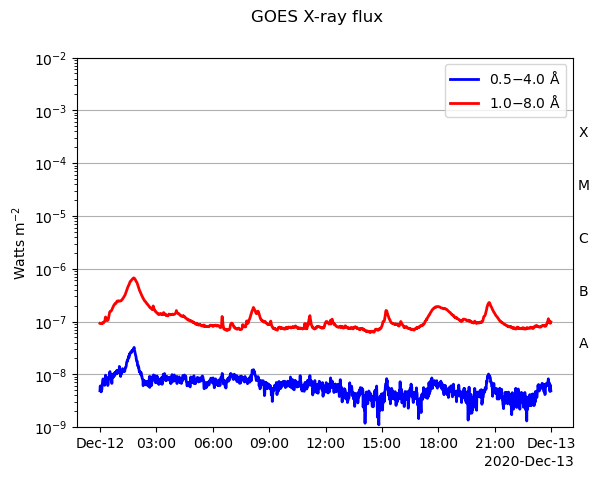

2025-09-04 14:17:34 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:17:35 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2020-12-12 00:00:00
End Date:			2020-12-12 23:59:00
Center Date:			2020-12-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.27E+00<br>emission_measure   2.99E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2020-12-12 00:00:00     2.811526      0.000000e+00
2020-12-12 00:01:00     2.811526      0.000000e+00
2020-12-12 00:02:00     2.811526      0.000000e+00
2020-12-12 00:03:00     2.811526      0.000000e+00
2020-12-12 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2020-12-12 23:55:00     2.811526     -2.187816e+47
2020-12-12 23:56:00     2.811526     -4.424264e+47
2020-12-12 23:57:00     2.811526     -3.146204e+47
2020-12-12 23:58:00     2.811526     -2.349737e+47
2020-12-12

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.38s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2020-12-12 00:00:00
End Date:			2020-12-12 23:59:00
Center Date:			2020-12-12 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.38E+00<br>emission_measure   9.82E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2020-12-12 00:00:00     2.637235      0.000000e+00
2020-12-12 00:01:00     2.637235      0.000000e+00
2020-12-12 00:02:00     2.637235      0.000000e+00
2020-12-12 00:03:00     2.637235      0.000000e+00
2020-12-12 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2020-12-12 23:55:00     2.637235     -7.181519e+47
2020-12-12 23:56:00     2.637235     -1.452267e+48
2020-12-12 23:57:00     2.637235     -1.032743e+48
2020-12-12 23:58:00     2.637235     -7.713024e+47
2020-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.56file/s]


Cargando datos de 2021-05-29 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2021-05-29 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2021-05-29 00:00:00
End Date:			2021-05-29 23:59:00
Center Date:			2021-05-29 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.82E-07<br>xrsb           5.88E-06<br>xrsa_quality   1.80E+01<br>xrsb_quality   1.80E+01
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2021-05-29 00:00:00  3.889178e-07  6.000568e-06             0             0
2021-05-29 00:01:00  3.777507e-07  5.881201e-06             0             0
2021-05-29 00:02:00  3.654659e-07  5.752779e-06           

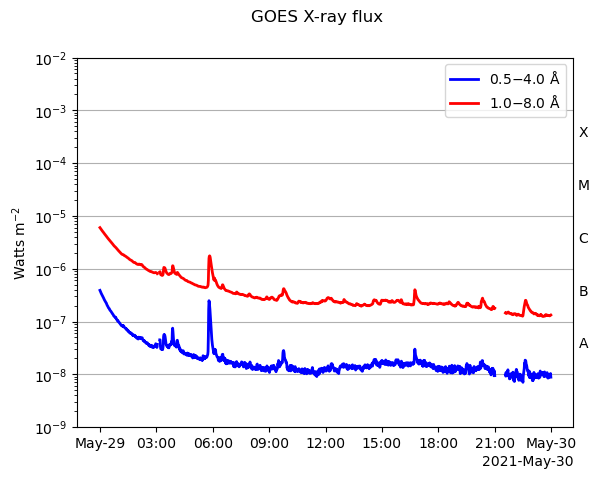

2025-09-04 14:17:46 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:17:47 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2021-05-29 00:00:00
End Date:			2021-05-29 23:59:00
Center Date:			2021-05-29 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.17E+01<br>emission_measure   2.57E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2021-05-29 00:00:00     2.811526      0.000000e+00
2021-05-29 00:01:00     2.811526      0.000000e+00
2021-05-29 00:02:00     2.811526      0.000000e+00
2021-05-29 00:03:00     2.811526      0.000000e+00
2021-05-29 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2021-05-29 23:55:00     2.811526     -3.100727e+46
2021-05-29 23:56:00     2.811526     -2.742650e+46
2021-05-29 23:57:00     2.811526     -2.832423e+46
2021-05-29 23:58:00     2.811526      4.620901e+46
2021-05-29

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.75s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2021-05-29 00:00:00
End Date:			2021-05-29 23:59:00
Center Date:			2021-05-29 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.12E+01<br>emission_measure   8.42E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2021-05-29 00:00:00     2.637235      0.000000e+00
2021-05-29 00:01:00     2.637235      0.000000e+00
2021-05-29 00:02:00     2.637235      0.000000e+00
2021-05-29 00:03:00     2.637235      0.000000e+00
2021-05-29 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2021-05-29 23:55:00     2.637235     -1.017815e+47
2021-05-29 23:56:00     2.637235     -9.002765e+46
2021-05-29 23:57:00     2.637235     -9.297444e+46
2021-05-29 23:58:00     2.637235      1.516813e+47
2021-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.19file/s]


Cargando datos de 2021-11-13 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2021-11-13 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2021-11-13 00:00:00
End Date:			2021-11-13 23:59:00
Center Date:			2021-11-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           1.12E-07<br>xrsb           1.19E-06<br>xrsa_quality   4.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2021-11-13 00:00:00  1.016544e-08  3.315209e-07             4             0
2021-11-13 00:01:00  1.105371e-08  3.228413e-07             4             0
2021-11-13 00:02:00  1.122400e-08  3.139533e-07           

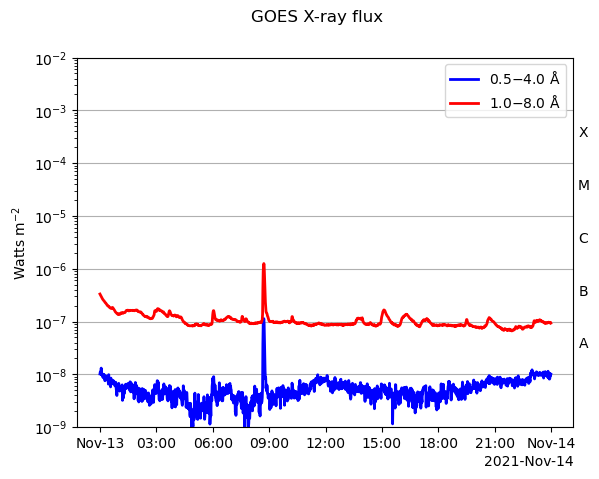

2025-09-04 14:17:59 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:18:00 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2021-11-13 00:00:00
End Date:			2021-11-13 23:59:00
Center Date:			2021-11-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        7.55E+00<br>emission_measure   2.40E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2021-11-13 00:00:00     2.811526      0.000000e+00
2021-11-13 00:01:00     2.811526      0.000000e+00
2021-11-13 00:02:00     2.811526      0.000000e+00
2021-11-13 00:03:00     2.811526      0.000000e+00
2021-11-13 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2021-11-13 23:55:00     2.811526     -1.513880e+46
2021-11-13 23:56:00     2.811526     -3.420813e+46
2021-11-13 23:57:00     2.811526     -6.335082e+46
2021-11-13 23:58:00     2.811526      4.807566e+46
2021-11-13

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2021-11-13 00:00:00
End Date:			2021-11-13 23:59:00
Center Date:			2021-11-13 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.65E+00<br>emission_measure   7.93E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2021-11-13 00:00:00     2.637235      0.000000e+00
2021-11-13 00:01:00     2.637235      0.000000e+00
2021-11-13 00:02:00     2.637235      0.000000e+00
2021-11-13 00:03:00     2.637235      0.000000e+00
2021-11-13 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2021-11-13 23:55:00     2.637235     -4.969320e+46
2021-11-13 23:56:00     2.637235     -1.122884e+47
2021-11-13 23:57:00     2.637235     -2.079494e+47
2021-11-13 23:58:00     2.637235      1.578086e+47
2021-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.55file/s]


Cargando datos de 2022-04-30 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2022-04-30 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2022-04-30 00:00:00
End Date:			2022-04-30 23:59:00
Center Date:			2022-04-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           3.65E-05<br>xrsb           1.12E-04<br>xrsa_quality   4.00E+00<br>xrsb_quality   1.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2022-04-30 00:00:00  1.409262e-08  9.066222e-07             4             0
2022-04-30 00:01:00  1.308756e-08  8.971301e-07             4             0
2022-04-30 00:02:00  1.298290e-08  8.868527e-07           

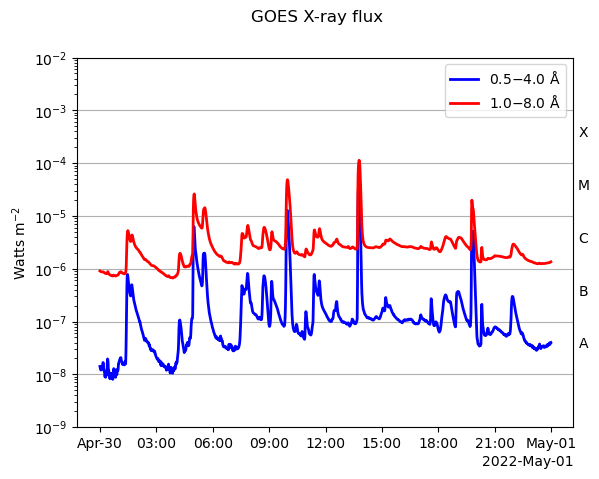

2025-09-04 14:18:10 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:18:12 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2022-04-30 00:00:00
End Date:			2022-04-30 23:59:00
Center Date:			2022-04-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.99E+01<br>emission_measure   2.62E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2022-04-30 00:00:00     2.811526      0.000000e+00
2022-04-30 00:01:00     2.811526      0.000000e+00
2022-04-30 00:02:00     2.811526      0.000000e+00
2022-04-30 00:03:00     2.811526      0.000000e+00
2022-04-30 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2022-04-30 23:55:00     2.811526      3.250464e+47
2022-04-30 23:56:00     2.811526      3.697609e+47
2022-04-30 23:57:00     2.811526      5.715494e+47
2022-04-30 23:58:00     8.283979      2.736507e+46
2022-04-30

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2022-04-30 00:00:00
End Date:			2022-04-30 23:59:00
Center Date:			2022-04-30 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.85E+02<br>emission_measure   8.60E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2022-04-30 00:00:00     2.637235      0.000000e+00
2022-04-30 00:01:00     2.637235      0.000000e+00
2022-04-30 00:02:00     2.637235      0.000000e+00
2022-04-30 00:03:00     2.637235      0.000000e+00
2022-04-30 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2022-04-30 23:55:00     2.637235      1.066967e+48
2022-04-30 23:56:00     2.637235      1.213742e+48
2022-04-30 23:57:00     2.637235      1.876114e+48
2022-04-30 23:58:00     7.323895      8.613689e+46
2022-

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00,  6.78file/s]


Cargando datos de 2022-10-15 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2022-10-15 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2022-10-15 00:00:00
End Date:			2022-10-15 23:59:00
Center Date:			2022-10-15 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           7.50E-07<br>xrsb           6.13E-06<br>xrsa_quality   4.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2022-10-15 00:00:00  1.664097e-08  7.177367e-07             0             0
2022-10-15 00:01:00  1.667414e-08  7.134342e-07             0             0
2022-10-15 00:02:00  1.613070e-08  7.112015e-07           

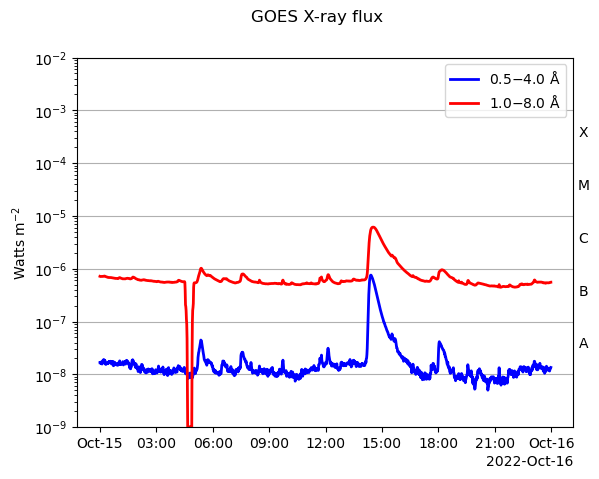

2025-09-04 14:18:23 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:18:24 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2022-10-15 00:00:00
End Date:			2022-10-15 23:59:00
Center Date:			2022-10-15 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.05E+01<br>emission_measure   3.66E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2022-10-15 00:00:00     2.811526      0.000000e+00
2022-10-15 00:01:00     2.811526      0.000000e+00
2022-10-15 00:02:00     2.811526      0.000000e+00
2022-10-15 00:03:00     2.811526      0.000000e+00
2022-10-15 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2022-10-15 23:55:00     2.811526      1.476991e+47
2022-10-15 23:56:00     2.811526      1.794173e+47
2022-10-15 23:57:00     2.811526      2.490056e+47
2022-10-15 23:58:00     2.811526      3.152707e+47
2022-10-15

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2022-10-15 00:00:00
End Date:			2022-10-15 23:59:00
Center Date:			2022-10-15 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        9.83E+00<br>emission_measure   1.20E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2022-10-15 00:00:00     2.637235      0.000000e+00
2022-10-15 00:01:00     2.637235      0.000000e+00
2022-10-15 00:02:00     2.637235      0.000000e+00
2022-10-15 00:03:00     2.637235      0.000000e+00
2022-10-15 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2022-10-15 23:55:00     2.637235      4.848232e+47
2022-10-15 23:56:00     2.637235      5.889384e+47
2022-10-15 23:57:00     2.637235      8.173624e+47
2022-10-15 23:58:00     2.637235      1.034878e+48
2022-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.49file/s]


Cargando datos de 2023-04-01 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2023-04-01 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2023-04-01 00:00:00
End Date:			2023-04-01 23:59:00
Center Date:			2023-04-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           5.03E-07<br>xrsb           6.79E-06<br>xrsa_quality   5.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2023-04-01 00:00:00  5.466145e-08  1.654745e-06             0             0
2023-04-01 00:01:00  4.988622e-08  1.610078e-06             0             0
2023-04-01 00:02:00  4.937549e-08  1.575895e-06           

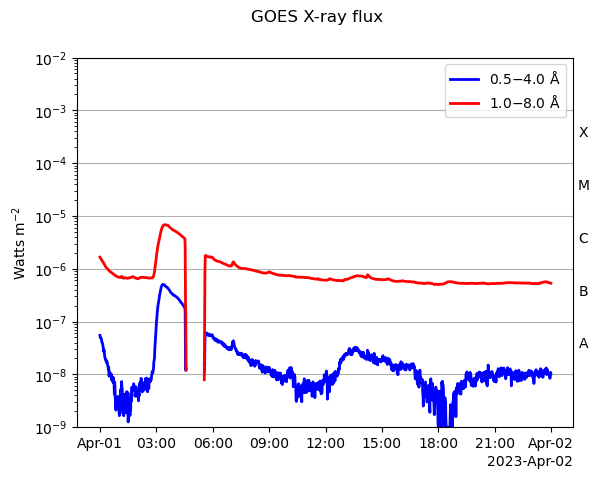

2025-09-04 14:18:34 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.29file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:18:35 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2023-04-01 00:00:00
End Date:			2023-04-01 23:59:00
Center Date:			2023-04-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.98E+00<br>emission_measure   9.38E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2023-04-01 00:00:00     2.811526      0.000000e+00
2023-04-01 00:01:00     2.811526      0.000000e+00
2023-04-01 00:02:00     2.811526      0.000000e+00
2023-04-01 00:03:00     2.811526      0.000000e+00
2023-04-01 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2023-04-01 23:55:00     2.811526     -1.816485e+47
2023-04-01 23:56:00     2.811526     -1.939129e+47
2023-04-01 23:57:00     2.811526     -2.325390e+47
2023-04-01 23:58:00     2.811526     -2.772078e+47
2023-04-01

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2023-04-01 00:00:00
End Date:			2023-04-01 23:59:00
Center Date:			2023-04-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        8.13E+00<br>emission_measure   3.08E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2023-04-01 00:00:00     2.637235      0.000000e+00
2023-04-01 00:01:00     2.637235      0.000000e+00
2023-04-01 00:02:00     2.637235      0.000000e+00
2023-04-01 00:03:00     2.637235      0.000000e+00
2023-04-01 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2023-04-01 23:55:00     2.637235     -5.962622e+47
2023-04-01 23:56:00     2.637235     -6.365201e+47
2023-04-01 23:57:00     2.637235     -7.633104e+47
2023-04-01 23:58:00     2.637235     -9.099361e+47
2023-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.54file/s]


Cargando datos de 2023-09-16 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2023-09-16 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2023-09-16 00:00:00
End Date:			2023-09-16 23:59:00
Center Date:			2023-09-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           7.73E-06<br>xrsb           3.43E-05<br>xrsa_quality   4.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa          xrsb  xrsa_quality  xrsb_quality
2023-09-16 00:00:00  3.248595e-08  1.461206e-06             0             0
2023-09-16 00:01:00  3.105953e-08  1.448248e-06             0             0
2023-09-16 00:02:00  3.194825e-08  1.436688e-06           

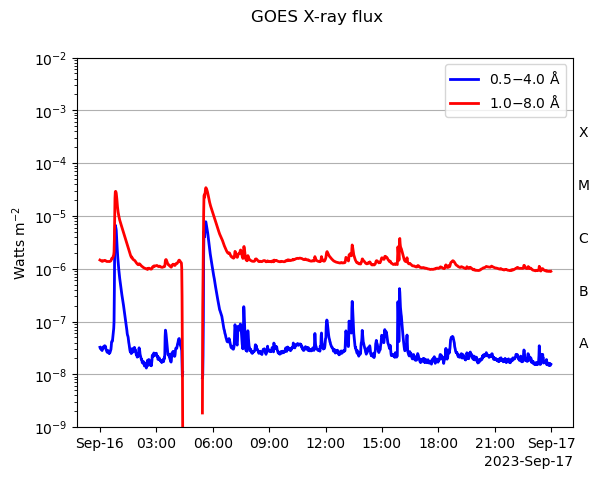

2025-09-04 14:18:44 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.28file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:18:45 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2023-09-16 00:00:00
End Date:			2023-09-16 23:59:00
Center Date:			2023-09-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.56E+01<br>emission_measure   3.79E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2023-09-16 00:00:00     2.811526      0.000000e+00
2023-09-16 00:01:00     2.811526      0.000000e+00
2023-09-16 00:02:00     2.811526      0.000000e+00
2023-09-16 00:03:00     2.811526      0.000000e+00
2023-09-16 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2023-09-16 23:55:00     2.811526      1.246506e+47
2023-09-16 23:56:00     2.811526      6.765775e+46
2023-09-16 23:57:00     2.811526     -4.662601e+46
2023-09-16 23:58:00     2.811526     -2.406721e+47
2023-09-16

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2023-09-16 00:00:00
End Date:			2023-09-16 23:59:00
Center Date:			2023-09-16 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.62E+01<br>emission_measure   1.24E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2023-09-16 00:00:00     2.637235      0.000000e+00
2023-09-16 00:01:00     2.637235      0.000000e+00
2023-09-16 00:02:00     2.637235      0.000000e+00
2023-09-16 00:03:00     2.637235      0.000000e+00
2023-09-16 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2023-09-16 23:55:00     2.637235      4.091662e+47
2023-09-16 23:56:00     2.637235      2.220869e+47
2023-09-16 23:57:00     2.637235     -1.530501e+47
2023-09-16 23:58:00     2.637235     -7.900074e+47
2023-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.55file/s]


Cargando datos de 2024-03-02 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2024-03-02 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2024-03-02 00:00:00
End Date:			2024-03-02 23:59:00
Center Date:			2024-03-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           7.10E-07<br>xrsb           6.62E-06<br>xrsa_quality   4.00E+00<br>xrsb_quality   5.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2024-03-02 00:00:00  7.847415e-08  0.000002             0             0
2024-03-02 00:01:00  7.179885e-08  0.000002             0             0
2024-03-02 00:02:00  6.791873e-08  0.000002             0             

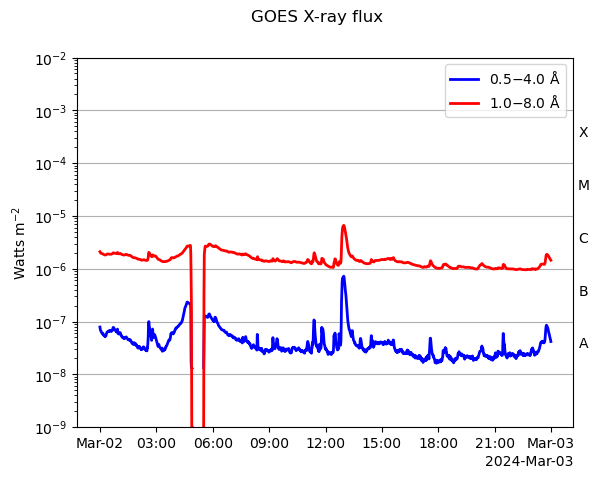

2025-09-04 14:18:55 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:18:57 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-03-02 00:00:00
End Date:			2024-03-02 23:59:00
Center Date:			2024-03-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.57E+01<br>emission_measure   7.98E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-03-02 00:00:00     2.811526      0.000000e+00
2024-03-02 00:01:00     2.811526      0.000000e+00
2024-03-02 00:02:00     2.811526      0.000000e+00
2024-03-02 00:03:00     2.811526      0.000000e+00
2024-03-02 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2024-03-02 23:55:00     2.811526     -4.790537e+48
2024-03-02 23:56:00     2.811526     -4.826334e+48
2024-03-02 23:57:00     2.811526     -4.588583e+48
2024-03-02 23:58:00     2.811526     -4.233904e+48
2024-03-02

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.31file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-03-02 00:00:00
End Date:			2024-03-02 23:59:00
Center Date:			2024-03-02 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.62E+01<br>emission_measure   2.62E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-03-02 00:00:00     2.637235      0.000000e+00
2024-03-02 00:01:00     2.637235      0.000000e+00
2024-03-02 00:02:00     2.637235      0.000000e+00
2024-03-02 00:03:00     2.637235      0.000000e+00
2024-03-02 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2024-03-02 23:55:00     2.637235     -1.572496e+49
2024-03-02 23:56:00     2.637235     -1.584247e+49
2024-03-02 23:57:00     2.637235     -1.506205e+49
2024-03-02 23:58:00     2.637235     -1.389781e+49
2024-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.23file/s]


Cargando datos de 2024-08-17 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2024-08-17 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2024-08-17 00:00:00
End Date:			2024-08-17 23:59:00
Center Date:			2024-08-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           2.33E-06<br>xrsb           1.36E-05<br>xrsa_quality   1.00E+00<br>xrsb_quality   1.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2024-08-17 00:00:00  6.779495e-08  0.000004             0             0
2024-08-17 00:01:00  6.947549e-08  0.000004             0             0
2024-08-17 00:02:00  7.228029e-08  0.000004             0             

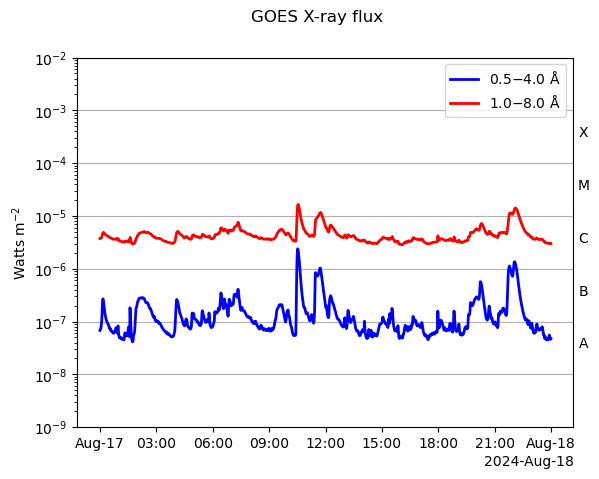

2025-09-04 14:19:07 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:19:08 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-08-17 00:00:00
End Date:			2024-08-17 23:59:00
Center Date:			2024-08-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        4.12E+01<br>emission_measure   1.49E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-08-17 00:00:00     2.811526      0.000000e+00
2024-08-17 00:01:00     2.811526      0.000000e+00
2024-08-17 00:02:00     2.811526      0.000000e+00
2024-08-17 00:03:00     2.811526      0.000000e+00
2024-08-17 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2024-08-17 23:55:00    12.400299      2.194034e+46
2024-08-17 23:56:00     2.811526     -1.814861e+46
2024-08-17 23:57:00     2.811526     -7.381773e+47
2024-08-17 23:58:00     2.811526     -1.807291e+48
2024-08-17

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.34file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-08-17 00:00:00
End Date:			2024-08-17 23:59:00
Center Date:			2024-08-17 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        6.32E+01<br>emission_measure   4.90E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-08-17 00:00:00     2.637235      0.000000e+00
2024-08-17 00:01:00     2.637235      0.000000e+00
2024-08-17 00:02:00     2.637235      0.000000e+00
2024-08-17 00:03:00     2.637235      0.000000e+00
2024-08-17 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2024-08-17 23:55:00    11.439797      5.370430e+46
2024-08-17 23:56:00     2.637235     -5.957293e+46
2024-08-17 23:57:00     2.637235     -2.423071e+48
2024-08-17 23:58:00     2.637235     -5.932444e+48
2024-

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.51file/s]


Cargando datos de 2025-02-01 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2025-02-01 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2025-02-01 00:00:00
End Date:			2025-02-01 23:59:00
Center Date:			2025-02-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           5.74E-06<br>xrsb           2.37E-05<br>xrsa_quality   0.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2025-02-01 00:00:00  5.285039e-08  0.000002             0             0
2025-02-01 00:01:00  5.244849e-08  0.000002             0             0
2025-02-01 00:02:00  5.191779e-08  0.000002             0             

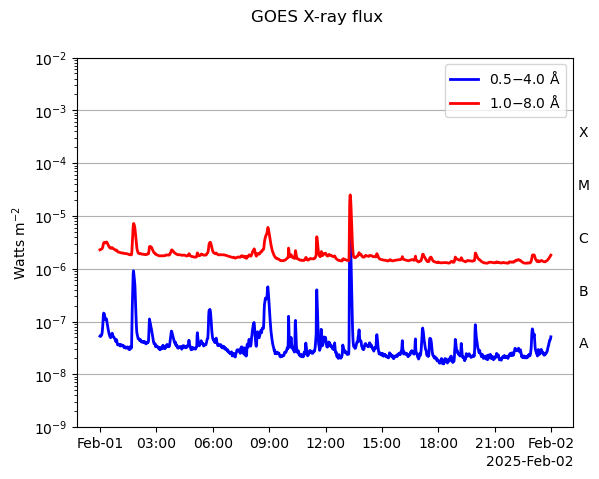

2025-09-04 14:19:17 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.02s/file]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:19:19 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2025-02-01 00:00:00
End Date:			2025-02-01 23:59:00
Center Date:			2025-02-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.89E+01<br>emission_measure   4.52E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2025-02-01 00:00:00     2.811526      0.000000e+00
2025-02-01 00:01:00     2.811526      0.000000e+00
2025-02-01 00:02:00     2.811526      0.000000e+00
2025-02-01 00:03:00     2.811526      0.000000e+00
2025-02-01 00:04:00     2.811526      0.000000e+00
...                          ...               ...
2025-02-01 23:55:00     8.669097      1.043581e+47
2025-02-01 23:56:00     7.511993      1.458101e+47
2025-02-01 23:57:00     7.792952      1.439876e+47
2025-02-01 23:58:00     6.893668      1.811210e+47
2025-02-01

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.32file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2025-02-01 00:00:00
End Date:			2025-02-01 23:59:00
Center Date:			2025-02-01 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        2.07E+01<br>emission_measure   1.48E+51
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2025-02-01 00:00:00     2.637235      0.000000e+00
2025-02-01 00:01:00     2.637235      0.000000e+00
2025-02-01 00:02:00     2.637235      0.000000e+00
2025-02-01 00:03:00     2.637235      0.000000e+00
2025-02-01 00:04:00     2.637235      0.000000e+00
...                          ...               ...
2025-02-01 23:55:00     7.679205      3.209318e+47
2025-02-01 23:56:00     6.617366      4.817015e+47
2025-02-01 23:57:00     6.873562      4.673190e+47
2025-02-01 23:58:00     6.056649      6.226174e+47
2025-

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.28file/s]


Cargando datos de 2025-07-19 00:00:00 en un TimeSeries:
Nos aseguramos que los datos de 2025-07-19 00:00:00 tengan resolución de un min
Resolution = 1 minute
Print data with 1 min resolution: SunPy TimeSeries
----------------
Observatory:			GOES-18
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2025-07-19 00:00:00
End Date:			2025-07-19 23:59:00
Center Date:			2025-07-19 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           4.40E-07<br>xrsb           3.23E-06<br>xrsa_quality   4.00E+00<br>xrsb_quality   0.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2025-07-19 00:00:00  4.261637e-08  0.000002             4             0
2025-07-19 00:01:00  4.258124e-08  0.000002             4             0
2025-07-19 00:02:00  3.954149e-08  0.000002             4             

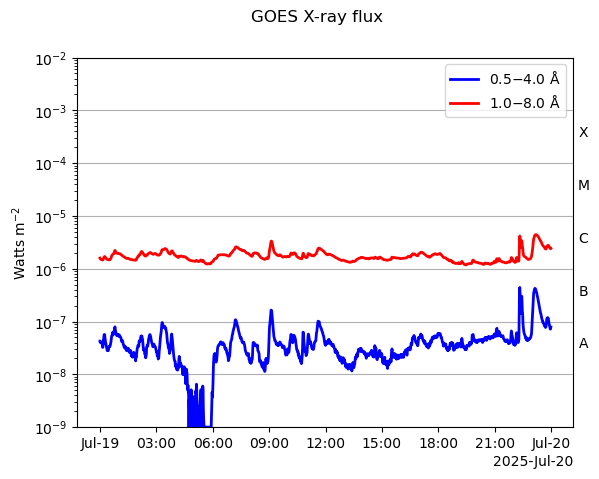

2025-09-04 14:19:29 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2. Restar Background
3. USAR FUNCIÓN SUNPY calculate_t_em
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-09-04 14:19:30 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2025-07-19 00:00:00
End Date:			2025-07-19 23:59:00
Center Date:			2025-07-19 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.73E+01<br>emission_measure   3.83E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2025-07-19 00:00:00     2.825434      0.000000e+00
2025-07-19 00:01:00     2.825434      0.000000e+00
2025-07-19 00:02:00     2.825434      0.000000e+00
2025-07-19 00:03:00     2.825434      0.000000e+00
2025-07-19 00:04:00     2.825434      0.000000e+00
...                          ...               ...
2025-07-19 23:55:00     2.825434     -5.811868e+48
2025-07-19 23:56:00     2.825434     -6.450240e+48
2025-07-19 23:57:00     2.825434     -6.438687e+48
2025-07-19 23:58:00     2.825434     -5.966504e+48
2025-07-19

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.33file/s]
/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2025-07-19 00:00:00
End Date:			2025-07-19 23:59:00
Center Date:			2025-07-19 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		temperature        1.83E+01<br>emission_measure   1.26E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2025-07-19 00:00:00     2.648176      0.000000e+00
2025-07-19 00:01:00     2.648176      0.000000e+00
2025-07-19 00:02:00     2.648176      0.000000e+00
2025-07-19 00:03:00     2.648176      0.000000e+00
2025-07-19 00:04:00     2.648176      0.000000e+00
...                          ...               ...
2025-07-19 23:55:00     2.648176     -1.915444e+49
2025-07-19 23:56:00     2.648176     -2.125835e+49
2025-07-19 23:57:00     2.648176     -2.122028e+49
2025-07-19 23:58:00     2.648176     -1.966408e+49
2025-

In [7]:
# Crear contenedores vacíos
all_df_full = pd.DataFrame()
all_df_fai_selected = pd.DataFrame()
all_anticipation_time = pd.DataFrame()
all_fai_times = pd.DatetimeIndex([])
all_df_flare_data = pd.DataFrame()
all_df_flare_fai_before = pd.DataFrame()

for idx, row in df_intervals.iterrows():
    start_time = row["start_time"]
    end_time   = row["end_time"]
    
    results = analyze_goes_data(start_time=start_time,
                                end_time=end_time,
                                resolution="avg1m",
                                fai_dt=5,
                                fai_temp_range=(7, 14),
                                fai_em_threshold=0.005,
                                peak_time_column="PeakTime",
                                max_gap_minutes=5,
                                plot_diff=False,
                                show_all=False,
                                window_minutes=10
                                )
    
    # Revisar si hubo datos GOES
    if results is None:
        print(f"Día {start_time} - {end_time} saltado (sin datos GOES).")
        continue  # saltar al siguiente día
    
    # Revisar si hay flares
    if results["df_flare_data"].empty:
        print(f"Saltando intervalo {start_time} - {end_time} (sin flares).")
        continue  # aquí sí puedes usar continue, porque ya estamos en el bucle

    # Acumular resultados
    all_df_full = pd.concat([all_df_full, results["df_full"]])
    all_df_fai_selected = pd.concat([all_df_fai_selected, results["df_fai_selected"]])
    all_anticipation_time = pd.concat([all_anticipation_time, results["anticipation_time"]])
    all_fai_times = all_fai_times.append(results["fai_times"])
    all_df_flare_data = pd.concat([all_df_flare_data, results["df_flare_data"]])
    all_df_flare_fai_before = pd.concat([all_df_flare_fai_before, results["df_flare_fai_before"]])
    
    # Guardar resultados de cada intervalo en CSV dentro de la carpeta
    #day_label = pd.to_datetime(start_time).strftime("%Y-%m-%d")
    #results["df_full"].to_csv(os.path.join(output_dir, f"df_full_{day_label}.csv"))
    #results["df_fai_selected"].to_csv(os.path.join(output_dir, f"df_fai_selected_{day_label}.csv"))
    #results["anticipation_time"].to_csv(os.path.join(output_dir, f"anticipation_time_{day_label}.csv"))
    #results["df_flare_data"].to_csv(os.path.join(output_dir, f"df_flare_data_{day_label}.csv"))
    #results["df_flare_fai_before"].to_csv(os.path.join(output_dir, f"df_flare_fai_before_{day_label}.csv"))
    #results["fai_times"].to_series().to_csv(os.path.join(output_dir, f"fai_times_{day_label}.csv"), index=False)

# Guardar acumulado final en la misma carpeta
all_df_full.to_csv(os.path.join(output_dir, f"all_df_full_{n}.csv"))
all_df_fai_selected.to_csv(os.path.join(output_dir, f"all_df_fai_selected_{n}.csv"))
all_anticipation_time.to_csv(os.path.join(output_dir, f"all_anticipation_time_{n}.csv"))
all_df_flare_data.to_csv(os.path.join(output_dir, f"all_df_flare_data_{n}.csv"))
all_df_flare_fai_before.to_csv(os.path.join(output_dir, f"all_df_flare_fai_before_{n}.csv"))
all_fai_times.to_series().to_csv(os.path.join(output_dir, f"all_fai_times_{n}.csv"), index=False)

print("Todos los intervalos han sido procesados y guardados en CSV.")

In [8]:
all_df_full

observatory          xrsa      xrsb     xrsa_corr  \
1980-01-05 00:00:00     Unknown  3.651650e-08  0.000002  0.000000e+00   
1980-01-05 00:01:00     Unknown  3.532950e-08  0.000002  0.000000e+00   
1980-01-05 00:02:00     Unknown  3.238579e-08  0.000002  0.000000e+00   
1980-01-05 00:03:00     Unknown  3.002450e-08  0.000002  0.000000e+00   
1980-01-05 00:04:00     Unknown  2.838632e-08  0.000002  0.000000e+00   
...                         ...           ...       ...           ...   
2025-07-19 23:55:00     GOES-18  8.125213e-08  0.000003 -3.639143e-08   
2025-07-19 23:56:00     GOES-18  7.727353e-08  0.000002 -3.412416e-08   
2025-07-19 23:57:00     GOES-18  7.178356e-08  0.000002 -2.907255e-08   
2025-07-19 23:58:00     GOES-18  7.189623e-08  0.000002 -2.254226e-08   
2025-07-19 23:59:00     GOES-18  7.852900e-08  0.000002 -8.809913e-09   

                        xrsb_corr     T_cor  EM_cor    T_phot  EM_phot  \
1980-01-05 00:00:00  0.000000e+00  2.682203     0.0  2.548023      0.0   
1980-01-05 00:01:00  0.000000e+00  2.682203     0.0  2.548023      0.0   
1980-01-05 00:02:00  0.000000e+00  2.682203     0.0  2.548023      0.0   
1980-01-05 00:03:00  0.000000e+00  2.682203     0.0  2.548023      0.0   
1980-01-05 00:04:00  0.000000e+00  2.682203     0.0  2.548023      0.0   
...                           ...       ...     ...       ...      ...   
2025-07-19 23:55:00 -2.640088e-07  2.825434     0.0  2.648176      0.0   
2025-07-19 23:56:00 -2.930074e-07  2.825434     0.0  2.648176      0.0   
2025-07-19 23:57:00 -2.924826e-07  2.825434     0.0  2.648176      0.0   
2025-07-19 23:58:00 -2.710333e-07  2.825434     0.0  2.648176      0.0   
2025-07-19 23:59:00 -1.768703e-07  2.825434     0.0  2.648176      0.0   

                     EM_cor_norm  EM_phot_norm  
1980-01-05 00:00:00          0.0           0.0  
1980-01-05 00:01:00          0.0           0.0  
1980-01-05 00:02:00          0.0           0.0  
1980-01-05 00:03:00          0.0           0.0  
1980-01-05 00:04:00          0.0           0.0  
...                          ...           ...  
2025-07-19 23:55:00          0.0           0.0  
2025-07-19 23:56:00          0.0           0.0  
2025-07-19 23:57:00          0.0           0.0  
2025-07-19 23:58:00          0.0           0.0  
2025-07-19 23:59:00          0.0           0.0  

[113628 rows x 11 columns]

## Graphs

Flare en 1982-10-10 00:02:00 no encontrado en datos GOES, se salta.
Flare en 1984-02-24 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1987-10-30 22:15:00 no encontrado en datos GOES, se salta.
Flare en 1989-09-01 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1991-07-05 23:23:00 no encontrado en datos GOES, se salta.
Flare en 1993-05-07 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1999-10-15 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2014-01-17 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2017-04-09 00:16:00 no encontrado en datos GOES, se salta.
Flare en 2020-01-10 11:59:00 no encontrado en datos GOES, se salta.
Flare en 2021-05-28 23:13:00 no encontrado en datos GOES, se salta.


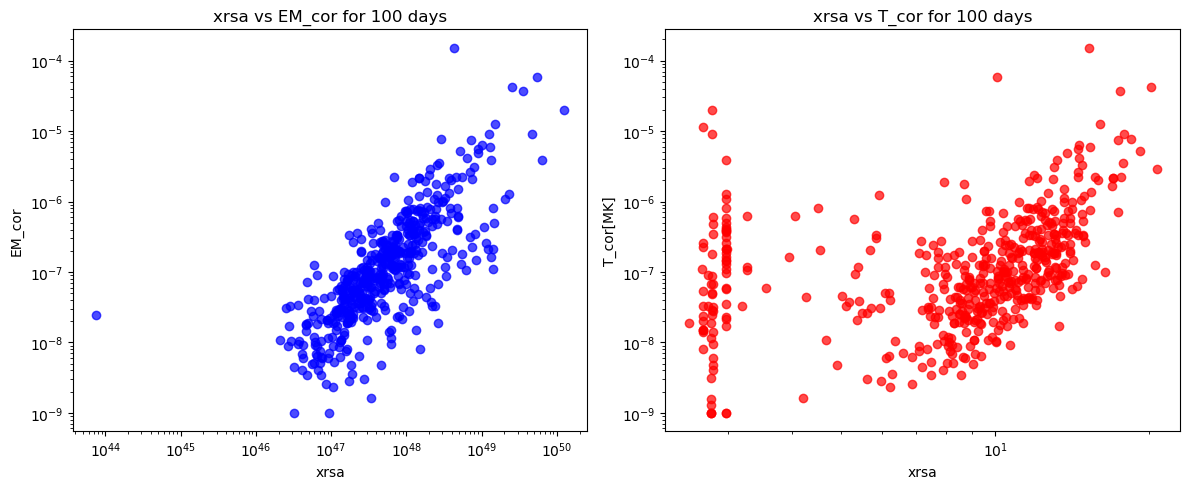

In [10]:
plot_xrs_vs_te_flare(all_df_full, all_df_flare_data, days=n, # número de días
                         time_column='PeakTime', 
                         XRS='xrsa', # 'xrsa' o 'xrsb'
                         T ='T_cor', # 'T_cor' o 'T_phot' o 
                         EM = 'EM_cor' # 'EM_cor' o 'EM_phot' o 'EM_cor_norm' o 'EM_phot_norm'
                         )



## Grapsh .csv

#### Graphs Barras

/tmp/ipykernel_713106/1397895046.py:1127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


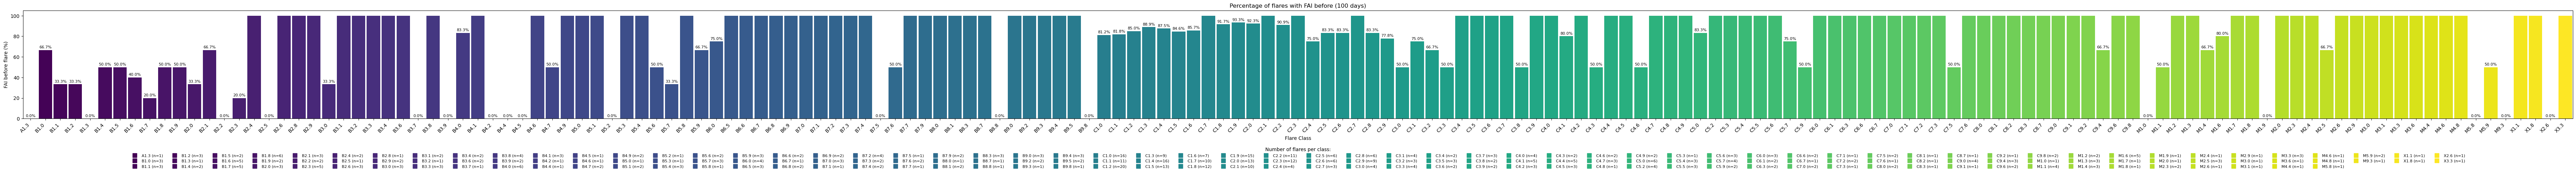

In [22]:
plot_flare_summary_from_csv2(csv_fai_before="Analysis_for_100_days/all_df_flare_fai_before_100.csv",
                                n_days=n,
                                group_subclasses=False,
                                color_mode="palette:viridis")

/tmp/ipykernel_713106/1397895046.py:1127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


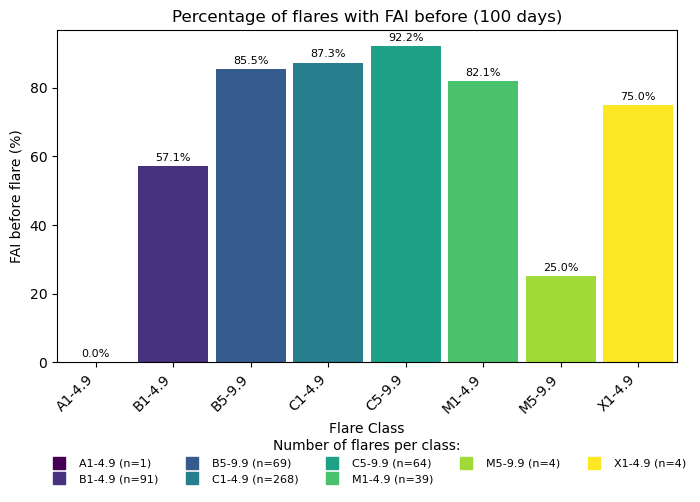

In [24]:
plot_flare_summary_from_csv2(csv_fai_before="Analysis_for_100_days/all_df_flare_fai_before_100.csv",
                                n_days=n,
                                group_subclasses=True,
                                color_mode="palette:viridis")

/tmp/ipykernel_713106/1397895046.py:1127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


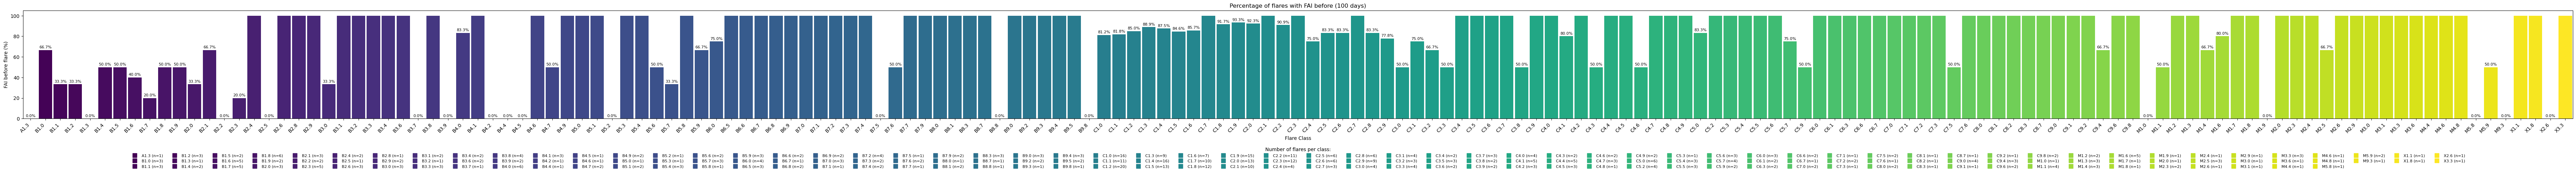

In [25]:
plot_flare_summary_from_csv2(csv_fai_before="Analysis_for_100_days/all_df_flare_fai_before_100.csv",
                                n_days=n,
                                 group_subclasses=False,  # agrupar en 2 cada clase de flare True o False
                                 color_mode="palette:viridis")  #  Elije el modo: "palette:<nombre>", "single:<color>", "by_class", "by_group" (si se activa group_subclasses=True)
                                                                 # cambiar paleta de colores palette:<nombre>:
                                                                 # "plasma", "cividis", "inferno", "magma", "tab10"

#### Graphs EM vs flux

Flare en 1982-10-10 00:02:00 no encontrado en datos GOES, se salta.
Flare en 1984-02-24 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1987-10-30 22:15:00 no encontrado en datos GOES, se salta.
Flare en 1989-09-01 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1991-07-05 23:23:00 no encontrado en datos GOES, se salta.
Flare en 1993-05-07 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1999-10-15 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2014-01-17 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2017-04-09 00:16:00 no encontrado en datos GOES, se salta.
Flare en 2020-01-10 11:59:00 no encontrado en datos GOES, se salta.
Flare en 2021-05-28 23:13:00 no encontrado en datos GOES, se salta.


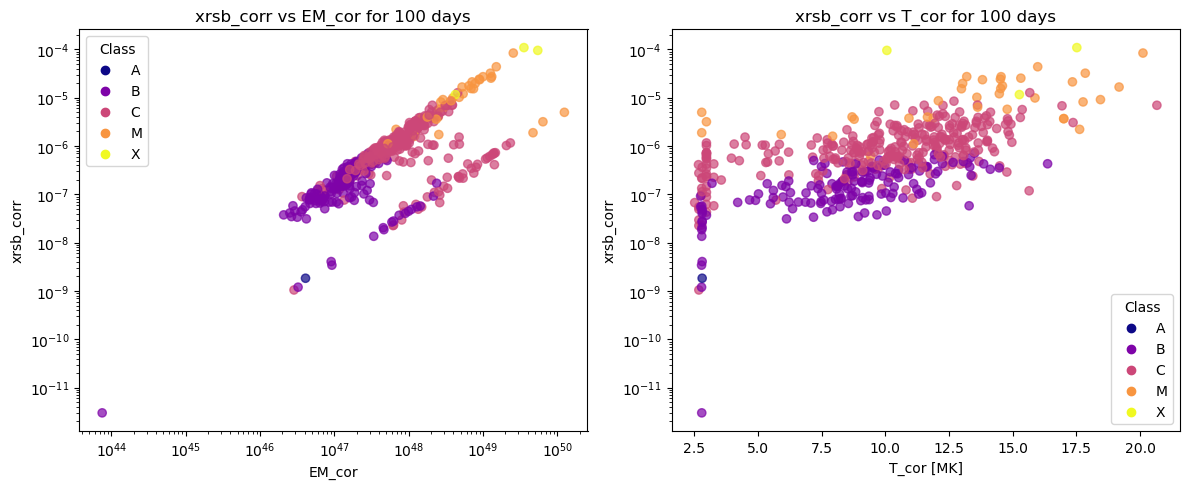

In [26]:
plot_xrs_vs_te_from_csv(days=n, csv_full ="Analysis_for_100_days/all_df_full_100.csv",
                         csv_flares = "Analysis_for_100_days/all_df_flare_data_100.csv", 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor",
                            color_by="Class",   # opcional: colorea puntos según la clase de flare
                            palette="plasma"  # puedes probar 'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                        )

Flare en 1982-10-10 00:02:00 no encontrado en datos GOES, se salta.
Flare en 1984-02-24 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1987-10-30 22:15:00 no encontrado en datos GOES, se salta.
Flare en 1989-09-01 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1991-07-05 23:23:00 no encontrado en datos GOES, se salta.
Flare en 1993-05-07 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1999-10-15 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2014-01-17 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2017-04-09 00:16:00 no encontrado en datos GOES, se salta.
Flare en 2020-01-10 11:59:00 no encontrado en datos GOES, se salta.
Flare en 2021-05-28 23:13:00 no encontrado en datos GOES, se salta.


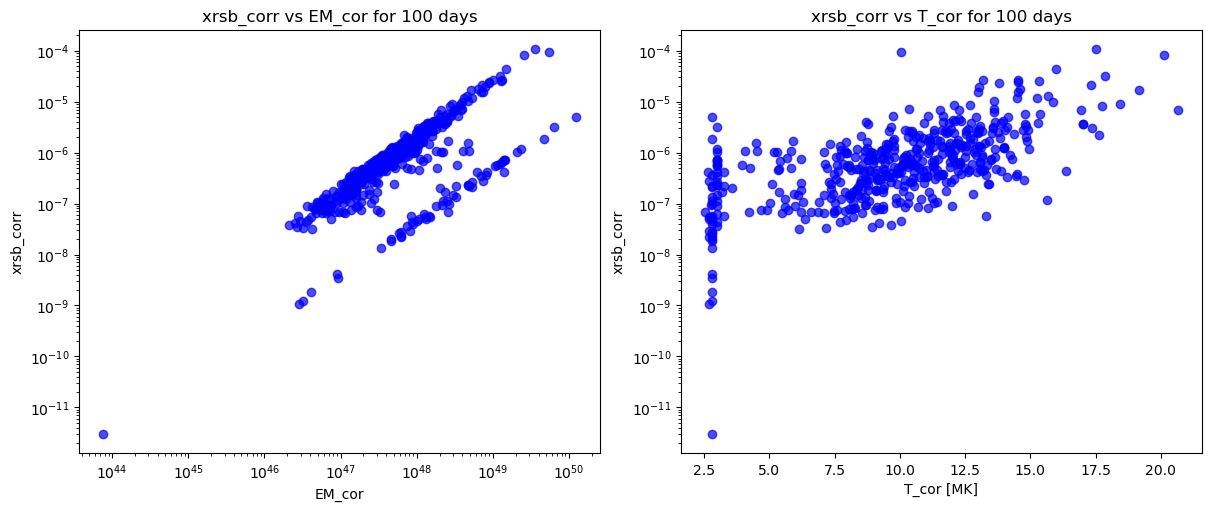

In [27]:
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full ="Analysis_for_100_days/all_df_full_100.csv", 
                            csv_flares = "Analysis_for_100_days/all_df_flare_data_100.csv", 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor",
                            color_by=None,      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )



Flare en 1982-10-10 00:02:00 no encontrado en datos GOES, se salta.
Flare en 1984-02-24 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1987-10-30 22:15:00 no encontrado en datos GOES, se salta.
Flare en 1989-09-01 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1991-07-05 23:23:00 no encontrado en datos GOES, se salta.
Flare en 1993-05-07 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1999-10-15 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2014-01-17 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2017-04-09 00:16:00 no encontrado en datos GOES, se salta.
Flare en 2020-01-10 11:59:00 no encontrado en datos GOES, se salta.
Flare en 2021-05-28 23:13:00 no encontrado en datos GOES, se salta.


/tmp/ipykernel_713106/1397895046.py:1521: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


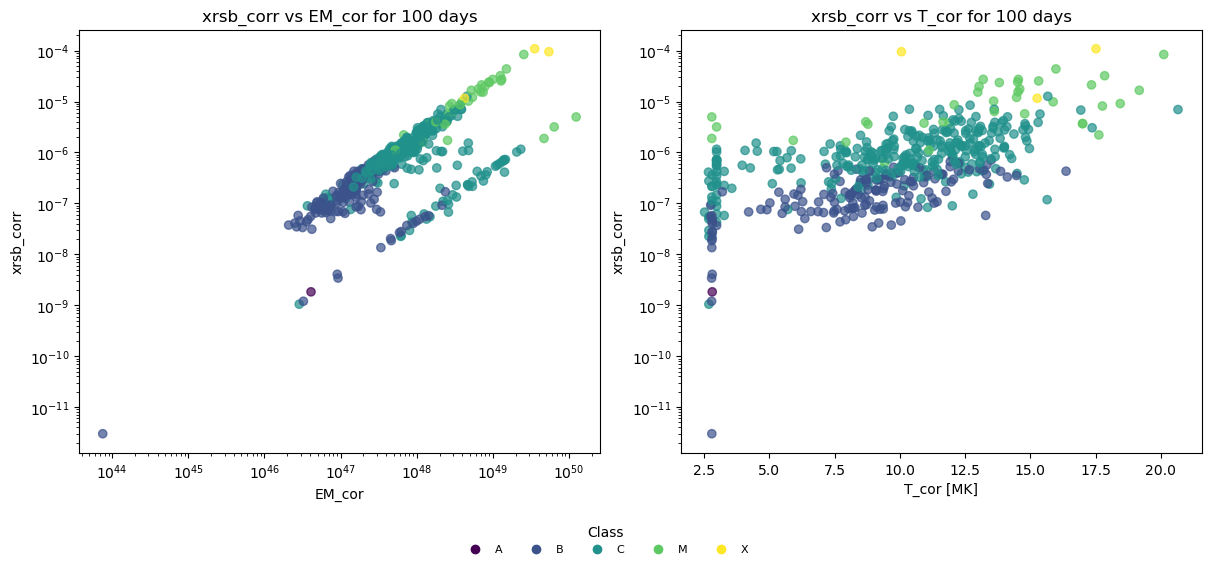

In [28]:
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full ="Analysis_for_100_days/all_df_full_100.csv", 
                            csv_flares = "Analysis_for_100_days/all_df_flare_data_100.csv", 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor",
                            color_by="Class",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1982-10-10 00:02:00 no encontrado en datos GOES, se salta.
Flare en 1984-02-24 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1987-10-30 22:15:00 no encontrado en datos GOES, se salta.
Flare en 1989-09-01 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1991-07-05 23:23:00 no encontrado en datos GOES, se salta.
Flare en 1993-05-07 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1999-10-15 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2014-01-17 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2017-04-09 00:16:00 no encontrado en datos GOES, se salta.
Flare en 2020-01-10 11:59:00 no encontrado en datos GOES, se salta.
Flare en 2021-05-28 23:13:00 no encontrado en datos GOES, se salta.


/tmp/ipykernel_713106/1397895046.py:1521: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


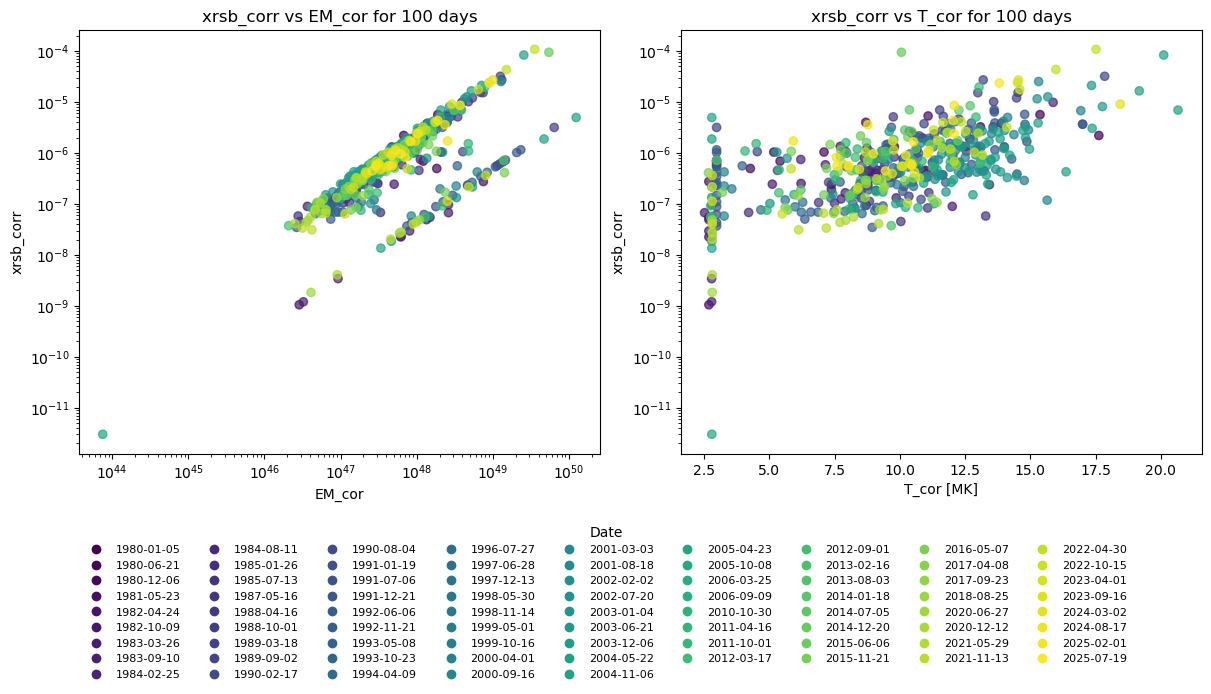

In [29]:
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full ="Analysis_for_100_days/all_df_full_100.csv", 
                            csv_flares = "Analysis_for_100_days/all_df_flare_data_100.csv", 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor",
                            color_by="Date",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1982-10-10 00:02:00 no encontrado en datos GOES, se salta.
Flare en 1984-02-24 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1987-10-30 22:15:00 no encontrado en datos GOES, se salta.
Flare en 1989-09-01 23:55:00 no encontrado en datos GOES, se salta.
Flare en 1991-07-05 23:23:00 no encontrado en datos GOES, se salta.
Flare en 1993-05-07 21:10:00 no encontrado en datos GOES, se salta.
Flare en 1999-10-15 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2014-01-17 23:57:00 no encontrado en datos GOES, se salta.
Flare en 2017-04-09 00:16:00 no encontrado en datos GOES, se salta.
Flare en 2020-01-10 11:59:00 no encontrado en datos GOES, se salta.
Flare en 2021-05-28 23:13:00 no encontrado en datos GOES, se salta.


/tmp/ipykernel_713106/1397895046.py:1521: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


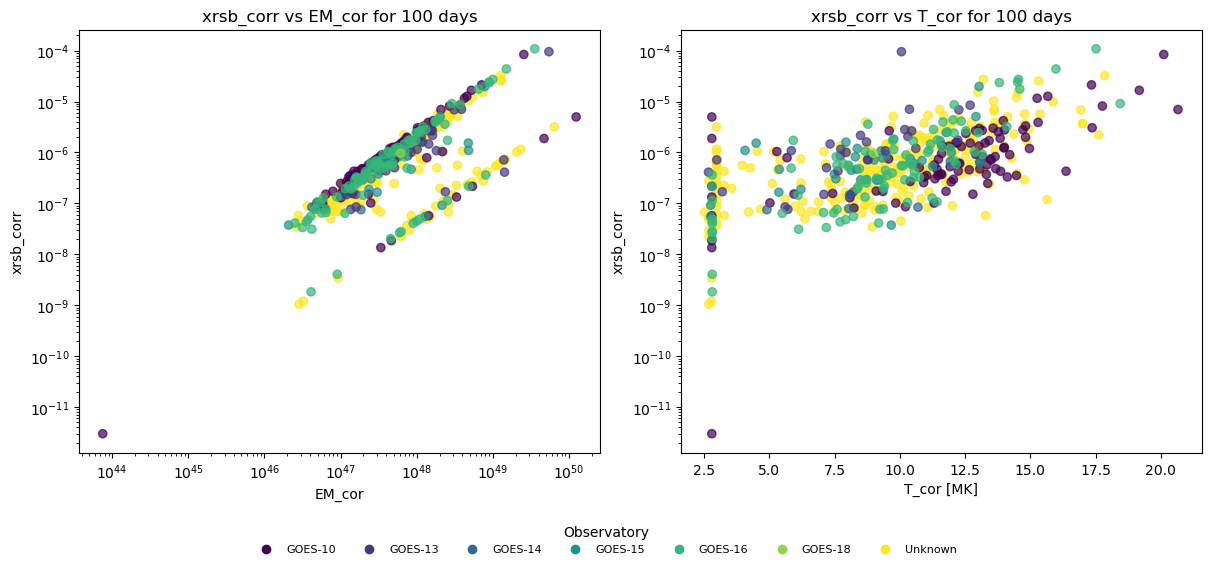

In [30]:
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full ="Analysis_for_100_days/all_df_full_100.csv", 
                            csv_flares = "Analysis_for_100_days/all_df_flare_data_100.csv", 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor",
                            color_by="Observatory",      # "None" o "Class" o "Date" u "Observatory" # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

In [31]:
mask = all_df_full["T_cor"] < 3  # puntos cercanos a 2.5 MK
subset = all_df_full[mask][["T_cor", "EM_cor", "xrsb_corr", "observatory"]]
print(subset)


                        T_cor  EM_cor     xrsb_corr observatory
1980-01-05 00:00:00  2.682203     0.0  0.000000e+00     Unknown
1980-01-05 00:01:00  2.682203     0.0  0.000000e+00     Unknown
1980-01-05 00:02:00  2.682203     0.0  0.000000e+00     Unknown
1980-01-05 00:03:00  2.682203     0.0  0.000000e+00     Unknown
1980-01-05 00:04:00  2.682203     0.0  0.000000e+00     Unknown
...                       ...     ...           ...         ...
2025-07-19 23:55:00  2.825434     0.0 -2.640088e-07     GOES-18
2025-07-19 23:56:00  2.825434     0.0 -2.930074e-07     GOES-18
2025-07-19 23:57:00  2.825434     0.0 -2.924826e-07     GOES-18
2025-07-19 23:58:00  2.825434     0.0 -2.710333e-07     GOES-18
2025-07-19 23:59:00  2.825434     0.0 -1.768703e-07     GOES-18

[86390 rows x 4 columns]


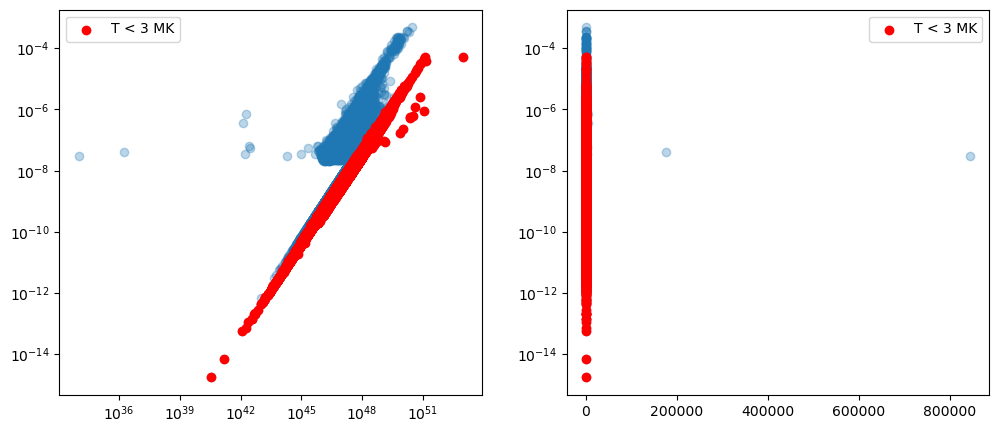

In [36]:
mask = all_df_full["T_cor"] < 3

plt.figure(figsize=(12,5))

# Izquierda
plt.subplot(1,2,1)
plt.scatter(all_df_full["EM_cor"], all_df_full["xrsb_corr"], alpha=0.3)
plt.scatter(all_df_full[mask]["EM_cor"], all_df_full[mask]["xrsb_corr"], color="red", label="T < 3 MK")
plt.xscale("log")
plt.yscale("log")
plt.legend()

# Derecha
plt.subplot(1,2,2)
plt.scatter(all_df_full["T_cor"], all_df_full["xrsb_corr"], alpha=0.3)
plt.scatter(all_df_full[mask]["T_cor"], all_df_full[mask]["xrsb_corr"], color="red", label="T < 3 MK")
plt.yscale("log")
plt.legend()
plt.show()

In [37]:
def filtrar_flujos_positivos(ruta_csv, ruta_salida=None):
    """
    Lee un archivo CSV con los datos de df_full y filtra las filas
    donde los flujos xrsa_corr y xrsb_corr sean negativos.
    
    Parámetros:
    -----------
    ruta_csv : str
        Ruta del archivo CSV de entrada.
    ruta_salida : str, opcional
        Si se especifica, guarda el DataFrame filtrado en esa ruta.
    
    Retorna:
    --------
    df_filtrado : pandas.DataFrame
        DataFrame con solo los datos positivos en xrsa_corr y xrsb_corr.
    """
    # Cargar el CSV
    df_full = pd.read_csv(ruta_csv)
    
    # Filtrar solo valores positivos (>=0)
    df_filtrado = df_full[(df_full["xrsa_corr"] >= 0) & (df_full["xrsb_corr"] >= 0)]
    
    # Guardar si se especifica salida
    if ruta_salida:
        df_filtrado.to_csv(ruta_salida, index=False)
    
    return df_filtrado

In [38]:
df_limpio = filtrar_flujos_positivos("Analysis_for_100_days/all_df_full_100.csv", "Analysis_for_100_days/df_full_filtrado_100.csv")
print(df_limpio.head())

            Unnamed: 0 observatory          xrsa      xrsb  xrsa_corr  \
0  1980-01-05 00:00:00     Unknown  3.651650e-08  0.000002        0.0   
1  1980-01-05 00:01:00     Unknown  3.532950e-08  0.000002        0.0   
2  1980-01-05 00:02:00     Unknown  3.238579e-08  0.000002        0.0   
3  1980-01-05 00:03:00     Unknown  3.002450e-08  0.000002        0.0   
4  1980-01-05 00:04:00     Unknown  2.838632e-08  0.000002        0.0   

   xrsb_corr     T_cor  EM_cor    T_phot  EM_phot  EM_cor_norm  EM_phot_norm  
0        0.0  2.682203     0.0  2.548023      0.0          0.0           0.0  
1        0.0  2.682203     0.0  2.548023      0.0          0.0           0.0  
2        0.0  2.682203     0.0  2.548023      0.0          0.0           0.0  
3        0.0  2.682203     0.0  2.548023      0.0          0.0           0.0  
4        0.0  2.682203     0.0  2.548023      0.0          0.0           0.0  


Flare en 1980-01-05 18:18:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-21 01:25:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-21 12:44:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-21 17:44:00 no encontrado en datos GOES, se salta.
Flare en 1981-05-23 09:55:00 no encontrado en datos GOES, se salta.
Flare en 1981-05-23 18:10:00 no encontrado en datos GOES, se salta.
Flare en 1982-04-24 11:37:00 no encontrado en datos GOES, se salta.
Flare en 1982-10-09 03:40:00 no encontrado en datos GOES, se salta.
Flare en 1982-10-09 19:05:00 no encontrado en datos GOES, se salta.
Flare en 1982-10-10 00:02:00 no encontrado en datos GOES, se salta.
Flare en 1983-03-26 06:10:00 no encontrado en datos GOES, se salta.
Flare en 1983-09-10 08:05:00 no encontrado en datos GOES, se salta.
Flare en 1983-09-10 11:15:00 no encontrado en datos GOES, se salta.
Flare en 1983-09-10 16:27:00 no encontrado en datos GOES, se salta.
Flare en 1983-09-10 18:03:00 no encontrado en da

/tmp/ipykernel_713106/1397895046.py:1521: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


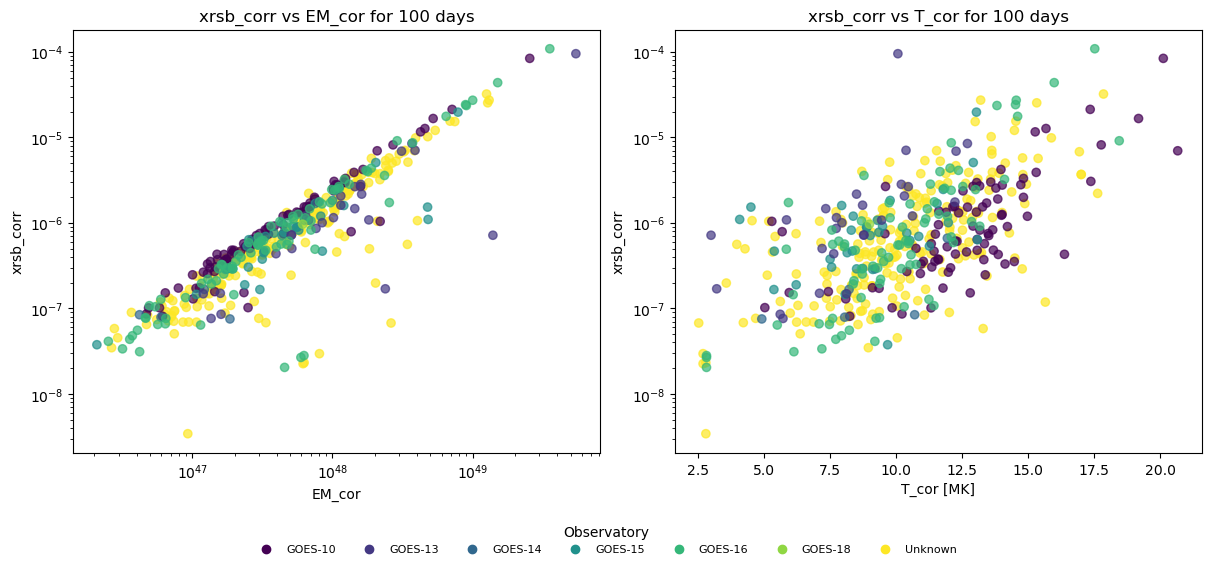

In [39]:
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full ="Analysis_for_100_days/df_full_filtrado_100.csv", 
                            csv_flares = "Analysis_for_100_days/all_df_flare_data_100.csv", 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor",
                            color_by="Observatory",      # "None" o "Class" o "Date" u "Observatory" # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1980-01-05 18:18:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-21 01:25:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-21 12:44:00 no encontrado en datos GOES, se salta.
Flare en 1980-06-21 17:44:00 no encontrado en datos GOES, se salta.
Flare en 1981-05-23 09:55:00 no encontrado en datos GOES, se salta.
Flare en 1981-05-23 18:10:00 no encontrado en datos GOES, se salta.
Flare en 1982-04-24 11:37:00 no encontrado en datos GOES, se salta.
Flare en 1982-10-09 03:40:00 no encontrado en datos GOES, se salta.
Flare en 1982-10-09 19:05:00 no encontrado en datos GOES, se salta.
Flare en 1982-10-10 00:02:00 no encontrado en datos GOES, se salta.
Flare en 1983-03-26 06:10:00 no encontrado en datos GOES, se salta.
Flare en 1983-09-10 08:05:00 no encontrado en datos GOES, se salta.
Flare en 1983-09-10 11:15:00 no encontrado en datos GOES, se salta.
Flare en 1983-09-10 16:27:00 no encontrado en datos GOES, se salta.
Flare en 1983-09-10 18:03:00 no encontrado en da

/tmp/ipykernel_713106/1397895046.py:1521: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


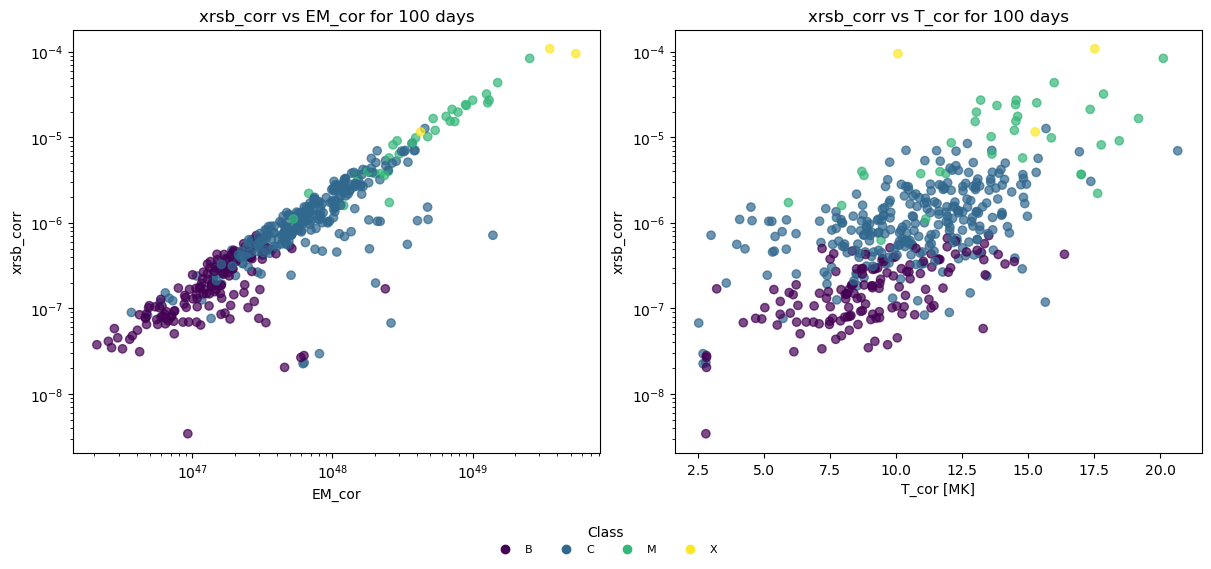

In [40]:
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full ="Analysis_for_100_days/df_full_filtrado_100.csv", 
                            csv_flares = "Analysis_for_100_days/all_df_flare_data_100.csv", 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor",
                            color_by="Class",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

In [20]:
print(all_df_full)

                    observatory          xrsa      xrsb     xrsa_corr  \
1980-01-05 00:00:00     Unknown  3.651650e-08  0.000002  0.000000e+00   
1980-01-05 00:01:00     Unknown  3.532950e-08  0.000002  0.000000e+00   
1980-01-05 00:02:00     Unknown  3.238579e-08  0.000002  0.000000e+00   
1980-01-05 00:03:00     Unknown  3.002450e-08  0.000002  0.000000e+00   
1980-01-05 00:04:00     Unknown  2.838632e-08  0.000002  0.000000e+00   
...                         ...           ...       ...           ...   
2025-07-19 23:55:00     GOES-18  8.125213e-08  0.000003 -3.639143e-08   
2025-07-19 23:56:00     GOES-18  7.727353e-08  0.000002 -3.412416e-08   
2025-07-19 23:57:00     GOES-18  7.178356e-08  0.000002 -2.907255e-08   
2025-07-19 23:58:00     GOES-18  7.189623e-08  0.000002 -2.254226e-08   
2025-07-19 23:59:00     GOES-18  7.852900e-08  0.000002 -8.809913e-09   

                        xrsb_corr     T_cor  EM_cor    T_phot  EM_phot  \
1980-01-05 00:00:00  0.000000e+00  2.682203     0

#### Basic xrsa vs em

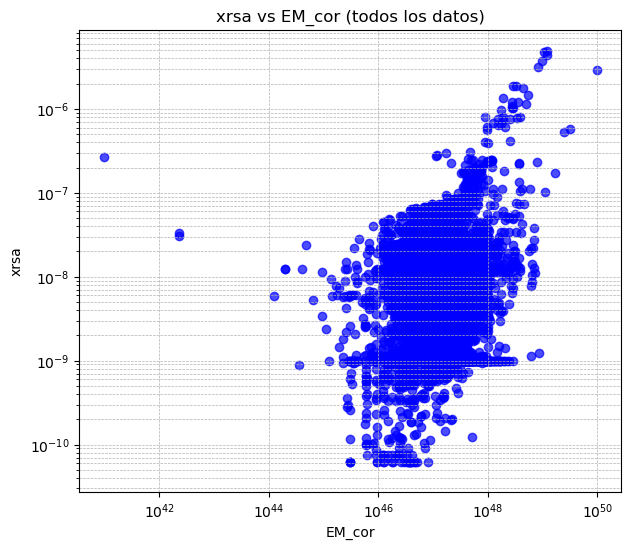

In [21]:
plot_xrsa_vs_em("Analysis_for_10_days/all_df_full_10.csv")